<h1 align="center"> Lending Club Loan Behavior Score Model </h1> <br>


We build a behavior model for the existing loans, written by Stephen Coggeshall. The notebook walks through all aspects of building a practical credit-type score: design, data cleaning, feature engineering, feature selection, models, analysis of results, and score calibraiton.

<h1 align="center"> Build a Predictive Risk Model </h1>

We build a model to predict which of the loans will be good and bad. We don't have a business person to guide us through this process so we'll make many decisions about the data and model design that are not necessarily optimal. the primary examples of these questionable assumptions include exactly what we are to predict, over what time period, and which fields to include as inputs to the prediction.

Since this is a credit type score we'll want high to be good and low to be bad. So we'll set y=1 for the goods and 0 for the bads. This particular kind of a credit score is called a behavior score, since it judges existing loans rather than new loan applications.

Here are the classic steps we go through to build a predictive model after doing basic EDA.

<h4> Data Cleaning </h4>
<ul>
<li> Field imputation, any exclusions (not for this problem), outliers (we'll do this later).</li>
<li> In this section we'll also set up the depoendent variable y and remove any fields that we think might cause target leaks. </li> </ul>

<h4> Build Variables From the Fields </h4>
<ul>
    <li> Determine which fields are numeric and which are categorical. </li>
    <li> Use target encoding to create variables from the categorical fields </li>
    <li> Make all possible ratios of the numeric fields </li>
</ul>
<h4> Feature Selection </h4>
<ul> 
    <li> Use a fast, simple univariate filter to find the variables that are by themselves good predictors. There will be lots of correleted variables found in this step. </li>
    <li> Next run a wrapper on the top strong variables to get a small list of multivariate good predictors. Most of the correlated variables will be removed in this step unless they add substantial additional information. </li>
</ul>
<h4> Stratified/Sampled Data Sets for Imbalanced Data </h4>
<ul>
The original data has bad rate of about 6.7%, so there are many more "good" loans than "bad" loans. With such an imbalanced data set we can either (1) do nothing, which is fine, (2) upsample the bads using something like SMOTE, or (3) downsample the goods. We do all three, so we have three different data sets to do training. Then we evaluate all approaches with the same unsampled validation data. </ul>
<h4> Model Building </h4>
<ul>
We try a variety of machine learning algorithms and compare the results on the validation data.
</ul>
<h4> Model Selection and Results </h4>
<ul>
    We select or algorithm/hyparameters of choice from the previous section and run the model again with these selections to get out final model.
</ul>
<h4> Score Calibration </h4>
<ul>
Here we calibrate the score for odds doubling, as is standard for risk scores.
</ul>


    
    



In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
start_time = datetime.now()

import gc
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

%matplotlib inline
# figure size in inches
rcParams['figure.figsize'] = 8,6


# Plotly visualizations
from plotly import tools
# import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import plotly.offline as pyo
import plotly.express as px
init_notebook_mode(connected=True)

# For oversampling Library (Dealing with Imbalanced Datasets)
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import LabelEncoder
# For undersamping
from imblearn.under_sampling import RandomUnderSampler

# for encoding and normalization
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold

import math
import itertools as it
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import warnings
warnings.filterwarnings("ignore")

# Classifiers
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb

# Other machine learning tools

from sklearn.feature_selection import RFECV
import scipy.stats as sps
from sklearn.decomposition import PCA

print('LOADING DURATION: ', datetime.now() - start_time)

LOADING DURATION:  0:00:10.441686


In [2]:
data = pd.read_csv("loan.csv", low_memory=False)

In [3]:
data.dropna(how='all', axis=1, inplace=True) # drop any empty columns
print('data.shape=',data.shape)
print(data.info())
data.head().transpose()

data.shape= (887379, 74)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           887379 non-null  int64  
 1   member_id                    887379 non-null  int64  
 2   loan_amnt                    887379 non-null  float64
 3   funded_amnt                  887379 non-null  float64
 4   funded_amnt_inv              887379 non-null  float64
 5   term                         887379 non-null  object 
 6   int_rate                     887379 non-null  float64
 7   installment                  887379 non-null  float64
 8   grade                        887379 non-null  object 
 9   sub_grade                    887379 non-null  object 
 10  emp_title                    835917 non-null  object 
 11  emp_length                   842554 non-null  object 
 12  home_ownership               8873

,0,1,2,3,4
id,1077501,1077430,1077175,1076863,1075358
member_id,1296599,1314167,1313524,1277178,1311748
loan_amnt,5000.0,2500.0,2400.0,10000.0,3000.0
funded_amnt,5000.0,2500.0,2400.0,10000.0,3000.0
funded_amnt_inv,4975.0,2500.0,2400.0,10000.0,3000.0
...,...,...,...,...,...
all_util,NaN,NaN,NaN,NaN,NaN
total_rev_hi_lim,NaN,NaN,NaN,NaN,NaN
inq_fi,NaN,NaN,NaN,NaN,NaN
total_cu_tl,NaN,NaN,NaN,NaN,NaN


In [4]:
data.tail().transpose()

,887374,887375,887376,887377,887378
id,36371250,36441262,36271333,36490806,36271262
member_id,39102635,39152692,38982739,39222577,38982659
loan_amnt,10000.0,24000.0,13000.0,12000.0,20000.0
funded_amnt,10000.0,24000.0,13000.0,12000.0,20000.0
funded_amnt_inv,10000.0,24000.0,13000.0,12000.0,20000.0
...,...,...,...,...,...
all_util,NaN,NaN,NaN,NaN,NaN
total_rev_hi_lim,17100.0,10200.0,18000.0,27000.0,41700.0
inq_fi,NaN,NaN,NaN,NaN,NaN
total_cu_tl,NaN,NaN,NaN,NaN,NaN


In [5]:
# Replace the name of some columns
data = data.rename(columns={"loan_amnt": "loan_amount", "funded_amnt": "funded_amount", "funded_amnt_inv": "investor_funds",
                       "int_rate": "interest_rate", "annual_inc": "annual_income"})

In [6]:
# Let's transform the issue dates by year.
data_series = pd.to_datetime(data['issue_d'])
data['year'] = data_series.dt.year

In [7]:
# This code takes the current date and transform it into a year-month format
data['complete_date'] = pd.to_datetime(data['issue_d']).dt.date

In [8]:
df_stats = pd.DataFrame(data.count(),columns=['count'])
df_stats['isna'] = data.isna().sum()
df_stats['% pop'] = 1 - data.isna().sum()/len(data)
df_stats

,count,isna,% pop
id,887379,0,1.000000
member_id,887379,0,1.000000
loan_amount,887379,0,1.000000
funded_amount,887379,0,1.000000
investor_funds,887379,0,1.000000
...,...,...,...
inq_fi,21372,866007,0.024084
total_cu_tl,21372,866007,0.024084
inq_last_12m,21372,866007,0.024084
year,887379,0,1.000000


In [9]:
data.describe(include = 'all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,887379.0,NaN,NaN,NaN,32465133.055024,22827341.721266,54734.0,9206643.0,34433267.0,54908135.0,68617057.0
member_id,887379.0,NaN,NaN,NaN,35001824.815562,24113354.675557,70473.0,10877133.5,37095283.0,58471347.0,73544841.0
loan_amount,887379.0,NaN,NaN,NaN,14755.264605,8435.455601,500.0,8000.0,13000.0,20000.0,35000.0
funded_amount,887379.0,NaN,NaN,NaN,14741.877625,8429.897657,500.0,8000.0,13000.0,20000.0,35000.0
investor_funds,887379.0,NaN,NaN,NaN,14702.464383,8442.106732,0.0,8000.0,13000.0,20000.0,35000.0
...,...,...,...,...,...,...,...,...,...,...,...
inq_fi,21372.0,NaN,NaN,NaN,0.943945,1.446872,0.0,0.0,0.0,1.0,17.0
total_cu_tl,21372.0,NaN,NaN,NaN,1.537058,2.723339,0.0,0.0,0.0,2.0,35.0
inq_last_12m,21372.0,NaN,NaN,NaN,1.977307,2.874067,-4.0,0.0,2.0,3.0,32.0
year,887379.0,NaN,NaN,NaN,2014.021761,1.261741,2007.0,2013.0,2014.0,2015.0,2015.0


<a name="Data-Preparation"></a>
# Data Preparation

Now we prepare the data for modeling.






## Let's carefully define the dependent variable

In [10]:
pd.value_counts(data.loan_status).to_frame().reset_index()

,loan_status,count
0,Current,601779
1,Fully Paid,207723
2,Charged Off,45248
3,Late (31-120 days),11591
4,Issued,8460
5,In Grace Period,6253
6,Late (16-30 days),2357
7,Does not meet the credit policy. Status:Fully ...,1988
8,Default,1219
9,Does not meet the credit policy. Status:Charge...,761



**1 Ajustment: change the classification of good loans and bad loans**

Important note: We really don't know the appropriate way to categorize the good/bad loand using the loan status. We'd really have to talk to the LC business/data people to better understan what this field means. But we're going to just make a decision here and build the models with our data assumption. One can always come back here and change this assumption and redefine the good/bad loans.

We're going to remove the early delinquencies (16-30) and the grace period loans since they haven't yet definitively gone bad. we're also going to set the good/bad flag so higher is better, like a typical credit score.

We'll also drop the "does not meet the credit policy" loans since we're really not sure what those are and probaly don't want our models to learn from them.




Original Kaggle competition labeling:

| Category | Loan Condition | original Loan Status |
| --- | --- | --- |
| Good Loan | 0 | Fully Paid, Current, Issued |
| Bad Loan | 1 | Default, Charged Off, In Grace Period, Late (16-30 days), Late (31-120 days) |



Our modified labeling:

| Category | Loan Condition | adjusted Loan Status |
| --- | --- | --- |
| Good Loan | 1 | Fully Paid, Current, Issued |
| Bad Loan | 0 | Default, Charged Off, Late (31-120 days) |

In [11]:
good_loan = ['Current','Fully Paid','Issued']
bad_loan = ['Charged Off','Late (31-120 days)','Default']

data['loan_condition'] = np.nan

def loan_condition(status):
    if status in good_loan:
        return 'Good Loan'
    elif status in bad_loan:
        return 'Bad Loan'
    else:
        return 'Indeterminate'
      
data['loan_condition'] = data['loan_status'].apply(loan_condition)
pd.value_counts(data['loan_condition']).to_frame()

,count
loan_condition,
Good Loan,817962
Bad Loan,58058
Indeterminate,11359


In [12]:
data = data[data['loan_condition'].isin(['Good Loan','Bad Loan'])]
pd.value_counts(data['loan_condition']).to_frame()

,count
loan_condition,
Good Loan,817962
Bad Loan,58058


In [13]:
# Let's create categories for annual_income since most of the bad loans are located below 100k

data['income_category'] = np.nan
lst = [data]

for col in lst:
    col.loc[col['annual_income'] <= 100000, 'income_category'] = 'Low'
    col.loc[(col['annual_income'] > 100000) & (col['annual_income'] <= 200000), 'income_category'] = 'Medium'
    col.loc[col['annual_income'] > 200000, 'income_category'] = 'High'

In [14]:
# Let's transform the column loan_condition into integrers.

lst = [data]
data['loan_condition_int'] = np.nan

for col in lst:
    col.loc[data['loan_condition'] == 'Good Loan', 'loan_condition_int'] = 0 # Negative (Bad Loan)
    col.loc[data['loan_condition'] == 'Bad Loan', 'loan_condition_int'] = 1 # Positive (Good Loan)
    
# Convert from float to int the column (This is our label for now)  
data['loan_condition_int'] = data['loan_condition_int'].astype(int)

In [15]:
data['interest_rate'].describe()
# Average interest is 13.26% Anything above this will be considered of high risk let's see if this is true.
data['interest_payments'] = np.nan
lst = [data]

for col in lst:
    col.loc[col['interest_rate'] <= 13.23, 'interest_payments'] = 'Low'
    col.loc[col['interest_rate'] > 13.23, 'interest_payments'] = 'High'
    
data.head().transpose()

,0,1,2,3,4
id,1077501,1077430,1077175,1076863,1075358
member_id,1296599,1314167,1313524,1277178,1311748
loan_amount,5000.0,2500.0,2400.0,10000.0,3000.0
funded_amount,5000.0,2500.0,2400.0,10000.0,3000.0
investor_funds,4975.0,2500.0,2400.0,10000.0,3000.0
...,...,...,...,...,...
complete_date,2011-12-01,2011-12-01,2011-12-01,2011-12-01,2011-12-01
loan_condition,Good Loan,Bad Loan,Good Loan,Good Loan,Good Loan
income_category,Low,Low,Low,Low,Low
loan_condition_int,0,1,0,0,0


In [16]:
# Make a list with each of the regions by state.

west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

data['region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'

data['region'] = data['addr_state'].apply(finding_regions)

In [17]:
employment_length = ['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
                    '4 years', '5 years', '6 years', '2 years', '7 years', 'n/a']

# Create a new column and convert emp_length to integers.

lst = [data]
data['emp_length_int'] = np.nan

for col in lst:
    col.loc[col['emp_length'] == '10+ years', "emp_length_int"] = 10
    col.loc[col['emp_length'] == '9 years', "emp_length_int"] = 9
    col.loc[col['emp_length'] == '8 years', "emp_length_int"] = 8
    col.loc[col['emp_length'] == '7 years', "emp_length_int"] = 7
    col.loc[col['emp_length'] == '6 years', "emp_length_int"] = 6
    col.loc[col['emp_length'] == '5 years', "emp_length_int"] = 5
    col.loc[col['emp_length'] == '4 years', "emp_length_int"] = 4
    col.loc[col['emp_length'] == '3 years', "emp_length_int"] = 3
    col.loc[col['emp_length'] == '2 years', "emp_length_int"] = 2
    col.loc[col['emp_length'] == '1 year', "emp_length_int"] = 1
    col.loc[col['emp_length'] == '< 1 year', "emp_length_int"] = 0.5
    col.loc[col['emp_length'] == 'n/a', "emp_length_int"] = 0

In [18]:
pd.value_counts(data.loan_status).to_frame().reset_index()

,loan_status,count
0,Current,601779
1,Fully Paid,207723
2,Charged Off,45248
3,Late (31-120 days),11591
4,Issued,8460
5,Default,1219


In [19]:
# Determining the loans that are bad from loan_status column

good_loan = ['Fully Paid', 'Current', 'Issued' ]

# df['loan_condition'] = np.nan

def loan_condition(status):
    if status in good_loan:
        return 1
    else:
        return 0
      
data['loan_condition_int'] = data['loan_status'].apply(loan_condition)

In [20]:
pd.value_counts(data['loan_condition_int'])

loan_condition_int
1    817962
0     58058
Name: count, dtype: int64

In [21]:
num_goods = len(data[data['loan_condition_int']==1])
num_bads = len(data[data['loan_condition_int']==0])
num_records = num_goods + num_bads
bad_rate = num_bads / num_records
print(num_records, 'records, ', num_goods,'goods, ',num_bads, 'bads.    ', 'bad rate is', bad_rate)

876020 records,  817962 goods,  58058 bads.     bad rate is 0.06627474258578571


In [22]:
# I don't think we'll need 'last_pymnt_d' or 'last_credit_pull_d'. They'll be related to the loan dates, and the 
# last credit pull might be a target leak anyway.
data.drop(columns=['last_pymnt_d', 'last_credit_pull_d'],inplace=True)

<a name="Some EDA"></a>
# Exploratory Data Analysis

Do some business analysis






### OK, let's do some business analysis

In [23]:
# Grouping by our metrics
# First Plotly Graph (We evaluate the operative side of the business)
by_loan_amount = data.groupby(['region','addr_state'], as_index=False).loan_amount.sum()
by_interest_rate = data.groupby(['region', 'addr_state'], as_index=False).interest_rate.mean()
by_income = data.groupby(['region', 'addr_state'], as_index=False).annual_income.mean()

# Take the values to a list for visualization purposes.
states = by_loan_amount['addr_state'].values.tolist()
average_loan_amounts = by_loan_amount['loan_amount'].values.tolist()
average_interest_rates = by_interest_rate['interest_rate'].values.tolist()
average_annual_income = by_income['annual_income'].values.tolist()

from collections import OrderedDict

# Figure Number 1 (Perspective for the Business Operations)
metrics_data = OrderedDict([('state_codes', states),
                            ('issued_loans', average_loan_amounts),
                            ('interest_rate', average_interest_rates),
                            ('annual_income', average_annual_income)])
                     
metrics_data = pd.DataFrame.from_dict(metrics_data)
metrics_data = metrics_data.round(decimals=2)
metrics_data.head()

,state_codes,issued_loans,interest_rate,annual_income
0,IA,70375.0,10.87,47570.86
1,IL,532887475.0,13.07,76938.70
2,IN,200347800.0,13.44,68063.22
3,KS,115356575.0,13.26,68914.75
4,MI,322200050.0,13.27,69406.76


<AxesSubplot: title={'center': '# Loans by Credit Class'}, xlabel='year', ylabel='loan_amount'>

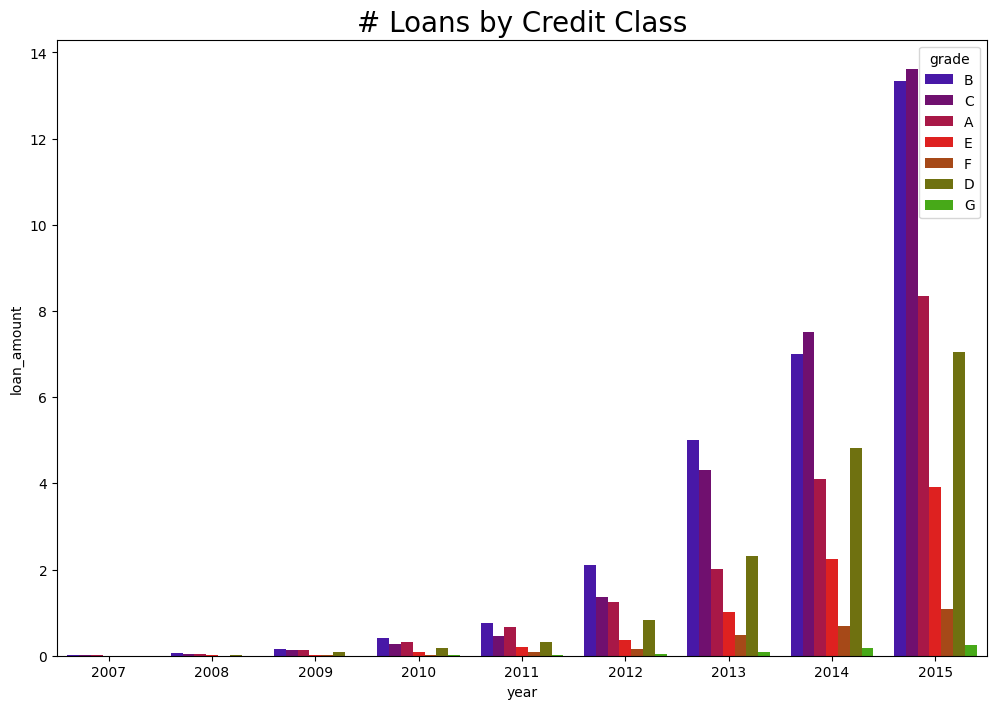

In [24]:
plt.figure(figsize=(12,8))

plt.title('# Loans by Credit Class', fontsize=20)

mypalette = "brg"

sns.barplot(x="year", y="loan_amount", hue="grade", data=data, palette=mypalette, estimator=lambda x: len(x) / len(data) * 100)
# ax[1].set(ylabel="(%)")

[Text(0, 0.5, '(%)')]

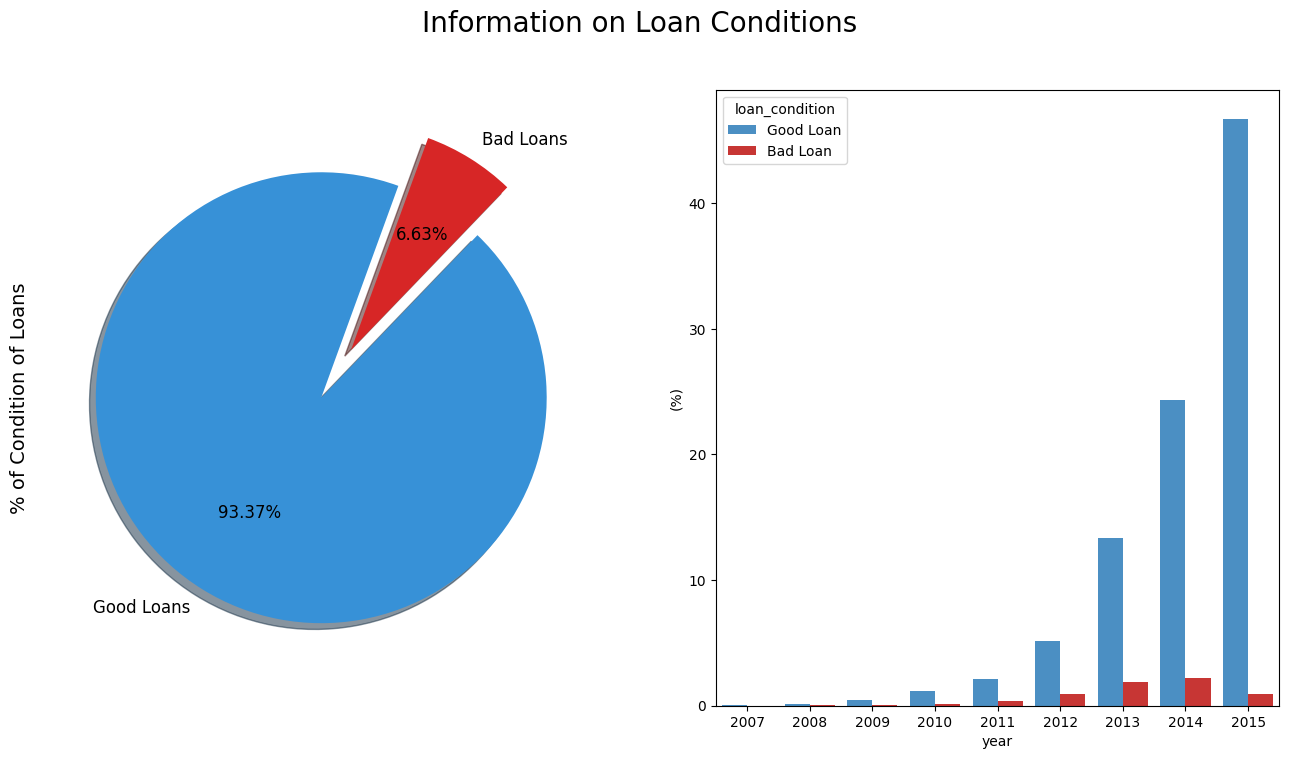

In [25]:
f, ax = plt.subplots(1,2, figsize=(16,8))

colors = ["#3791D7", "#D72626"]
labels ="Good Loans", "Bad Loans"

plt.suptitle('Information on Loan Conditions', fontsize=20)

data["loan_condition_int"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', ax=ax[0], shadow=True, colors=colors, 
                                             labels=labels, fontsize=12, startangle=70)

ax[0].set_ylabel('% of Condition of Loans', fontsize=14)

palette = ["#3791D7", "#E01E1B"]

sns.barplot(x="year", y="loan_amount", hue="loan_condition", data=data, palette=palette, estimator=lambda x: len(x) / len(data) * 100)
ax[1].set(ylabel="(%)")

In [26]:
df = data.copy()

In [27]:
# Grouping by our metrics
# First Plotly Graph (We evaluate the operative side of the business)
by_loan_amount = df.groupby(['region','addr_state'], as_index=False).loan_amount.sum()
by_interest_rate = df.groupby(['region', 'addr_state'], as_index=False).interest_rate.mean()
by_income = df.groupby(['region', 'addr_state'], as_index=False).annual_income.mean()

# Take the values to a list for visualization purposes.
states = by_loan_amount['addr_state'].values.tolist()
average_loan_amounts = by_loan_amount['loan_amount'].values.tolist()
average_interest_rates = by_interest_rate['interest_rate'].values.tolist()
average_annual_income = by_income['annual_income'].values.tolist()

from collections import OrderedDict

# Figure Number 1 (Perspective for the Business Operations)
metrics_data = OrderedDict([('state_codes', states),
                            ('issued_loans', average_loan_amounts),
                            ('interest_rate', average_interest_rates),
                            ('annual_income', average_annual_income)])
                     
metrics_df = pd.DataFrame.from_dict(metrics_data)
metrics_df = metrics_df.round(decimals=2)
metrics_df.head()

,state_codes,issued_loans,interest_rate,annual_income
0,IA,70375.0,10.87,47570.86
1,IL,532887475.0,13.07,76938.70
2,IN,200347800.0,13.44,68063.22
3,KS,115356575.0,13.26,68914.75
4,MI,322200050.0,13.27,69406.76


In [28]:
import plotly.graph_objs as go

for col in metrics_df.columns:
    metrics_df[col] = metrics_df[col].astype(str)
    
scl = [[0.0, 'rgb(210, 241, 198)'],[0.2, 'rgb(188, 236, 169)'],[0.4, 'rgb(171, 235, 145)'],\
            [0.6, 'rgb(140, 227, 105)'],[0.8, 'rgb(105, 201, 67)'],[1.0, 'rgb(59, 159, 19)']]

metrics_df['text'] = metrics_df['state_codes'] + '<br>' +\
'Average loan interest rate: ' + metrics_df['interest_rate'] + '<br>'+\
'Average annual income: ' + metrics_df['annual_income'] 

data1 = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = metrics_df['state_codes'],
        z = metrics_df['issued_loans'], 
        locationmode = 'USA-states',
        text = metrics_df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "$s USD")
        ) ]

layout = dict(
    title = 'Lending Clubs Issued Loans <br> (A Perspective for the Business Operations)',
    geo = dict(
        scope = 'usa',
        projection=dict(type='albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)')
)

fig = dict(data=data1, layout=layout)
iplot(fig, filename='d3-cloropleth-map')

In [29]:
by_condition = df.groupby('addr_state')['loan_condition'].value_counts()/ df.groupby('addr_state')['loan_condition'].count()
by_emp_length = df.groupby(['region', 'addr_state'], as_index=False).emp_length_int.mean().sort_values(by="addr_state")

loan_condition_bystate = pd.crosstab(df['addr_state'], df['loan_condition'] )

cross_condition = pd.crosstab(df["addr_state"], df["loan_condition"])
# Percentage of condition of loan
percentage_loan_contributor = pd.crosstab(df['addr_state'], df['loan_condition']).apply(lambda x: x/x.sum() * 100)
condition_ratio = cross_condition["Bad Loan"]/(cross_condition["Good Loan"]+cross_condition["Bad Loan"])
by_dti = df.groupby(['region', 'addr_state'], as_index=False).dti.mean()
state_codes = sorted(states)

# Take to a list
bad_rate = condition_ratio.values.tolist()
average_dti = by_dti['dti'].values.tolist()
average_emp_length = by_emp_length["emp_length_int"].values.tolist()
number_of_badloans = loan_condition_bystate['Bad Loan'].values.tolist()
number_of_goodloans = loan_condition_bystate['Good Loan'].values.tolist()
percentage_ofall_badloans = percentage_loan_contributor['Bad Loan'].values.tolist()

# Figure Number 2
risk_data = OrderedDict([('state_codes', state_codes),
                         ('bad_rate', bad_rate),
                         ('goodloans_number', number_of_goodloans),
                         ('badloans_number', number_of_badloans),
                         ('percentage_of_badloans', percentage_ofall_badloans),
                         ('average_debt_to_income', average_dti),
                         ('average_emp_length', average_emp_length)])

# Figure 2 Dataframe 
risk_df = pd.DataFrame.from_dict(risk_data)
risk_df = risk_df.round(decimals=3)
risk_df.sort_values('bad_rate', ascending=False)

,state_codes,bad_rate,goodloans_number,badloans_number,percentage_of_badloans,average_debt_to_income,average_emp_length
12,IA,0.143,6,1,0.002,17.005,2.929
13,ID,0.111,8,1,0.002,16.770,2.562
33,NV,0.086,11257,1056,1.819,19.808,6.000
11,HI,0.081,4138,367,0.632,18.830,6.577
1,AL,0.075,10183,831,1.431,17.830,6.613
9,FL,0.075,55627,4506,7.761,19.472,5.841
34,NY,0.074,67606,5380,9.267,18.273,6.056
4,CA,0.072,118776,9184,15.819,18.687,5.970
41,SD,0.072,1672,129,0.222,16.720,6.054
45,VA,0.072,24025,1854,3.193,19.278,6.034


In [30]:
for col in risk_df.columns:
    risk_df[col] = risk_df[col].astype(str)
    
scl = [[0.0, 'rgb(202, 202, 202)'],[0.2, 'rgb(253, 205, 200)'],[0.4, 'rgb(252, 169, 161)'],\
            [0.6, 'rgb(247, 121, 108  )'],[0.8, 'rgb(232, 70, 54)'],[1.0, 'rgb(212, 31, 13)']]

risk_df['text'] = risk_df['state_codes'] + '<br>' +\
'Number of Bad Loans: ' + risk_df['badloans_number'] + '<br>' + \
'Percentage of all Bad Loans: ' + risk_df['percentage_of_badloans'] + '%' +  '<br>' + \
'Average Debt-to-Income Ratio: ' + risk_df['average_debt_to_income'] + '<br>'+\
'Average Length of Employment: ' + risk_df['average_emp_length'] 

data1 = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = risk_df['state_codes'],
        z = risk_df['bad_rate'], 
        locationmode = 'USA-states',
        text = risk_df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "%")
        ) ]

layout = dict(
    title = 'Lending Clubs Default Rates <br> (Analyzing Risks)',
    geo = dict(
        scope = 'usa',
        projection=dict(type='albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)')
)

fig = dict(data=data1, layout=layout)
iplot(fig, filename='d3-cloropleth-map')

Text(0, 0.5, 'Interest Rate (%)')

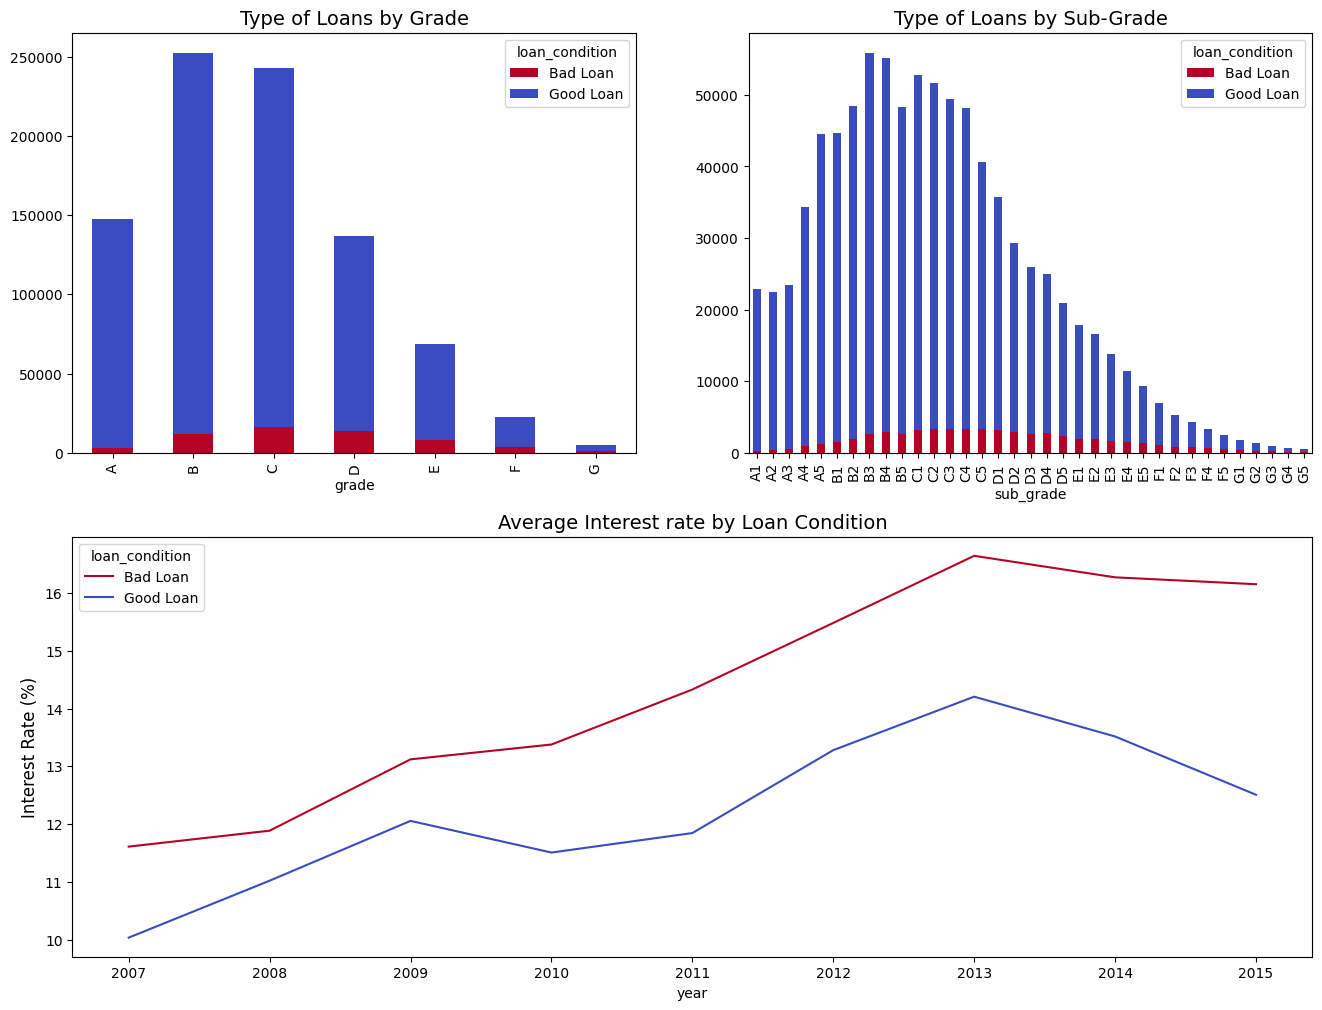

In [31]:
fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

cmap = plt.cm.coolwarm_r

loans_by_grade = df.groupby(['grade', 'loan_condition']).size()
loans_by_grade.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax1, grid=False)
ax1.set_title('Type of Loans by Grade', fontsize=14)

loans_by_subgrade = df.groupby(['sub_grade', 'loan_condition']).size()
loans_by_subgrade.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax2, grid=False)
ax2.set_title('Type of Loans by Sub-Grade', fontsize=14)

by_interest = df.groupby(['year', 'loan_condition']).interest_rate.mean()
by_interest.unstack().plot(ax=ax3, colormap=cmap)
ax3.set_title('Average Interest rate by Loan Condition', fontsize=14)
ax3.set_ylabel('Interest Rate (%)', fontsize=12)

In [32]:
loans_by_grade

grade  loan_condition
A      Bad Loan            3156
       Good Loan         144449
B      Bad Loan           11721
       Good Loan         240810
C      Bad Loan           16341
       Good Loan         226325
D      Bad Loan           13688
       Good Loan         123189
E      Bad Loan            8311
       Good Loan          60582
F      Bad Loan            3781
       Good Loan          18509
G      Bad Loan            1060
       Good Loan           4098
dtype: int64

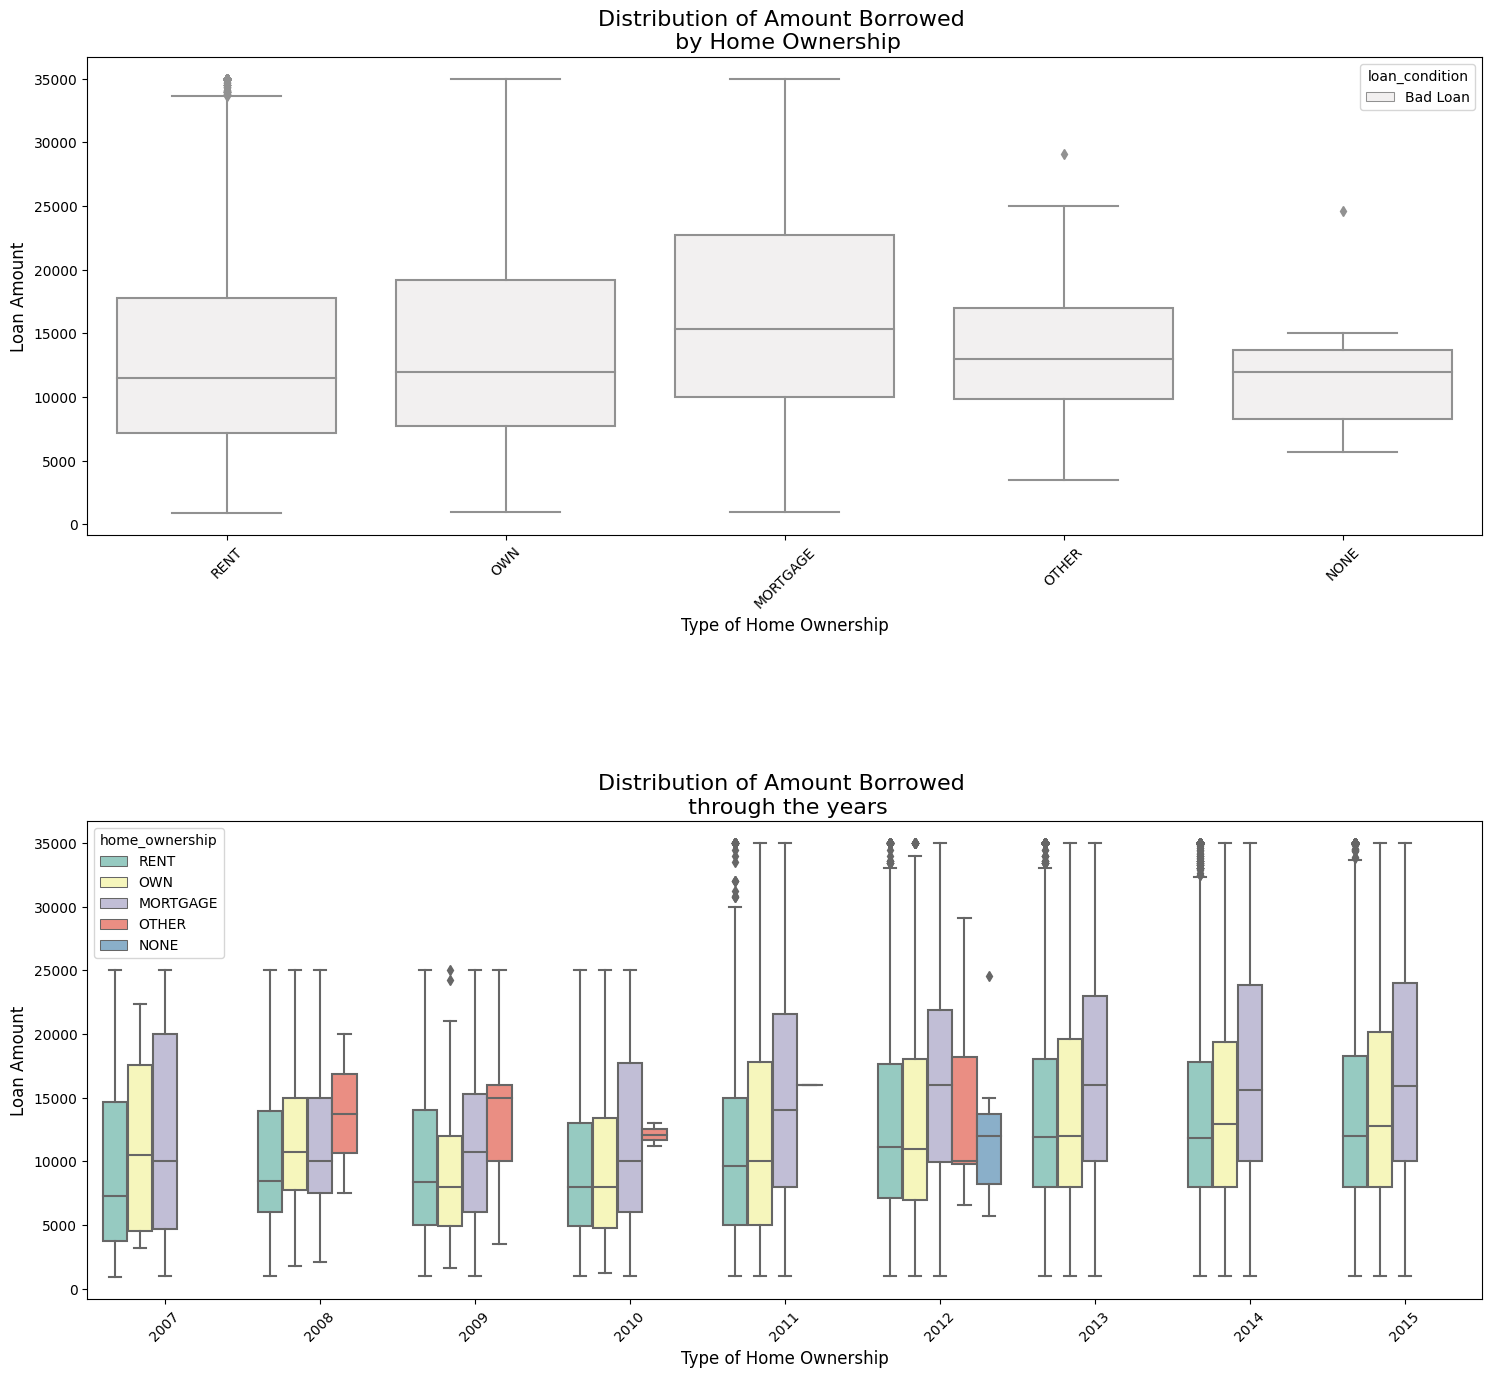

In [33]:
plt.figure(figsize=(18,18))

# Create a dataframe for bad loans
bad_df = df.loc[df['loan_condition'] == 'Bad Loan']

plt.subplot(211)
g = sns.boxplot(x='home_ownership', y='loan_amount', hue='loan_condition',
               data=bad_df, color='r')

g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("Type of Home Ownership", fontsize=12)
g.set_ylabel("Loan Amount", fontsize=12)
g.set_title("Distribution of Amount Borrowed \n by Home Ownership", fontsize=16)

plt.subplot(212)
g1 = sns.boxplot(x='year', y='loan_amount', hue='home_ownership',
               data=bad_df, palette="Set3")
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_xlabel("Type of Home Ownership", fontsize=12)
g1.set_ylabel("Loan Amount", fontsize=12)
g1.set_title("Distribution of Amount Borrowed \n through the years", fontsize=16)

plt.subplots_adjust(hspace = 0.6, top = 0.8)

plt.show()

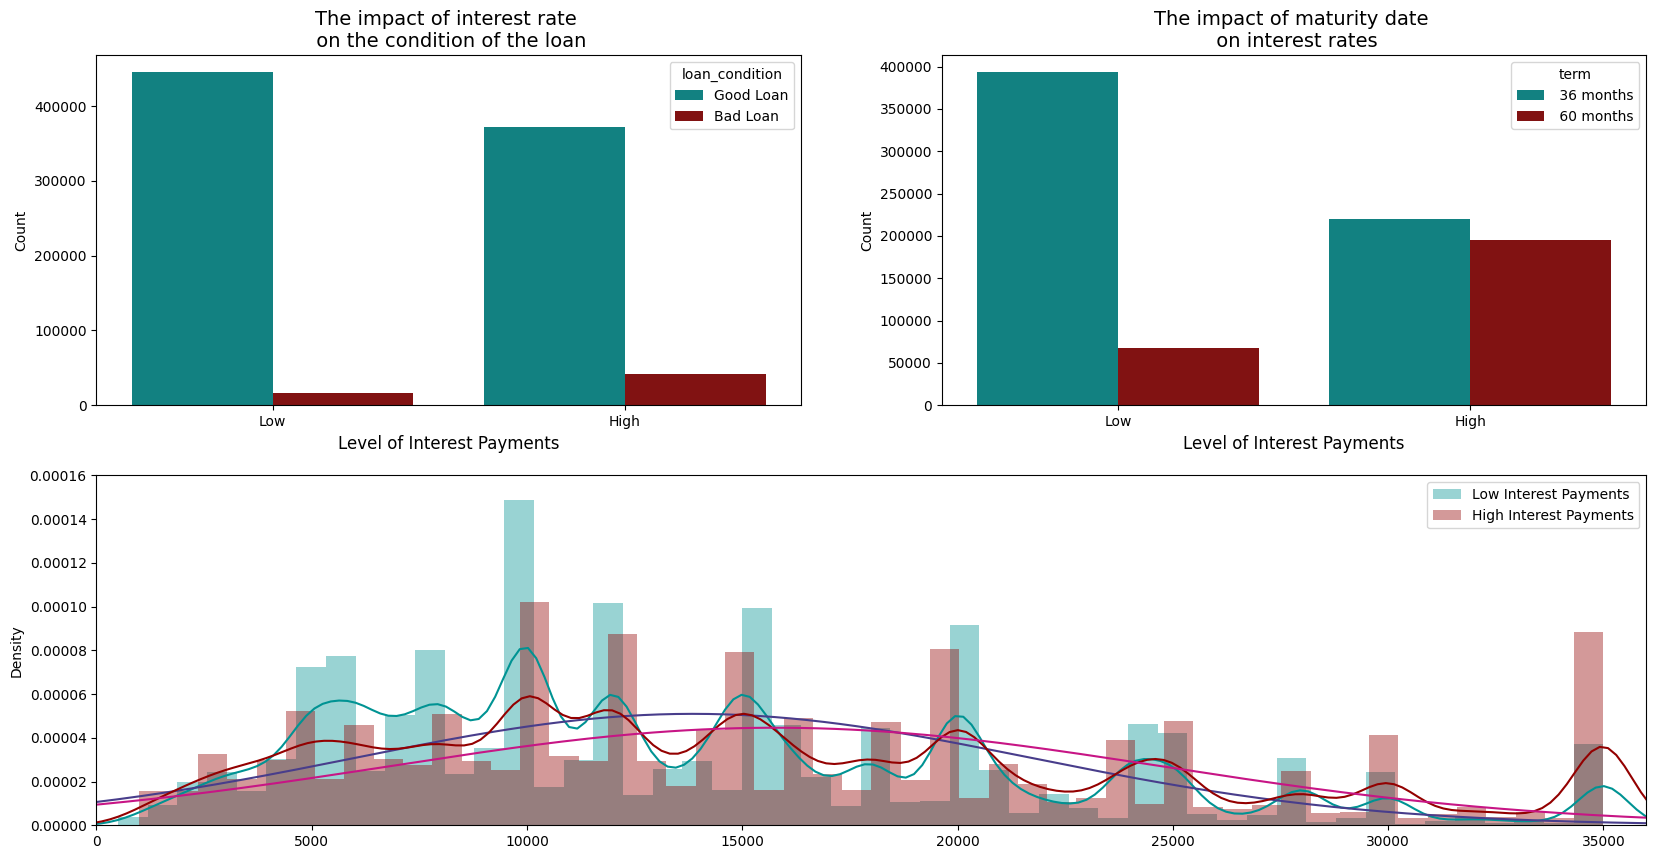

In [34]:
from scipy.stats import norm

plt.figure(figsize=(20,10))

palette = ['#009393', '#930000']
plt.subplot(221)
ax = sns.countplot(x='interest_payments', data=df, 
                  palette=palette, hue='loan_condition')

ax.set_title('The impact of interest rate \n on the condition of the loan', fontsize=14)
ax.set_xlabel('Level of Interest Payments', fontsize=12)
ax.set_ylabel('Count')

plt.subplot(222)
ax1 = sns.countplot(x='interest_payments', data=df, 
                   palette=palette, hue='term')

ax1.set_title('The impact of maturity date \n on interest rates', fontsize=14)
ax1.set_xlabel('Level of Interest Payments', fontsize=12)
ax1.set_ylabel('Count')

plt.subplot(212)
low = df['loan_amount'].loc[df['interest_payments'] == 'Low'].values
high = df['loan_amount'].loc[df['interest_payments'] == 'High'].values

ax2= sns.distplot(low, color='#009393', label='Low Interest Payments', fit=norm, fit_kws={"color":"#483d8b"}) # Dark Blue Norm Color
ax3 = sns.distplot(high, color='#930000', label='High Interest Payments', fit=norm, fit_kws={"color":"#c71585"}) #  Red Norm Color
plt.axis([0, 36000, 0, 0.00016])
plt.legend()

plt.show()

In [35]:
df['purpose'].value_counts()

purpose_condition = round(pd.crosstab(df['loan_condition'], df['purpose']).apply(lambda x: x/x.sum() * 100), 2)
purpose_condition_counts = pd.crosstab(df['loan_condition'], df['purpose'])

purpose_bad_loans = purpose_condition.values[0].tolist()
purpose_good_loans = purpose_condition.values[1].tolist()
purpose = purpose_condition.columns

bad_plot = go.Bar(
    x=purpose,
    y=purpose_bad_loans,
    name = 'Bad Loans',
    text='%',
    marker=dict(
        color='rgba(219, 64, 82, 0.7)',
        line = dict(
            color='rgba(219, 64, 82, 1.0)',
            width=2
        )
    )
)

good_plot = go.Bar(
    x=purpose,
    y=purpose_good_loans,
    name='Good Loans',
    text='%',
    marker=dict(
        color='rgba(50, 171, 96, 0.7)',
        line = dict(
            color='rgba(50, 171, 96, 1.0)',
            width=2
        )
    )
)

data1 = [bad_plot, good_plot]

layout = go.Layout(
    title='Condition of Loan by Purpose',
    xaxis=dict(
        title=''
    ),
    yaxis=dict(
        title='% of the Loan',
    ),
    paper_bgcolor='#FFF8DC',
    plot_bgcolor='#FFF8DC',
    showlegend=True
)

fig = dict(data=data1, layout=layout)
iplot(fig, filename='condition_purposes')

In [36]:
purpose_condition.transpose()

loan_condition,Bad Loan,Good Loan
purpose,,
car,6.04,93.96
credit_card,4.97,95.03
debt_consolidation,6.92,93.08
educational,17.18,82.82
home_improvement,5.83,94.17
house,9.80,90.20
major_purchase,6.45,93.55
medical,8.43,91.57
moving,9.92,90.08


Normally we'd have a business person to interat with in the problem design, but we don't in this case. We're not really sure how to set up the problem with the correct fields for variable creation. It's highlty likely that some of the fields would be inappropriate to include to build input variables for various reasons. One thing we do to identify suspicious fields and variables is to look at which variables are highly predictive. Frequently a variable that's unusually strong in prediction is built from a field that shouldn't be included. We don't have this guidnce for this problem so we'll use our best judgement to eliminate some potentially problematic fields.

<a name="More Data Cleaning"></a>
# More Data Cleaning







## Delete some fields that we think would be target leaks

In [37]:
data.drop(columns=['interest_rate'],inplace=True)
data.drop(columns=['total_rec_late_fee','recoveries','collection_recovery_fee'],inplace=True)
data.drop(columns=['out_prncp','out_prncp_inv','total_rec_prncp','total_rec_int'],inplace=True)
data.drop(columns=['acc_now_delinq','collections_12_mths_ex_med','tot_coll_amt'],inplace=True)
data.drop(['member_id', 'emp_title', 'url', 'desc', 'zip_code', 'title'], axis=1, inplace=True)
data.drop(columns=['issue_d','complete_date','year'],inplace=True)
# data.drop(columns=['interest_rate','purpose'],inplace=True)

## Delete some fields that we transformed already

| delete | but keep |
| --- | --- |
| loan_condition | loan_condition_int |
| emp_length | emp_length_int |

In [38]:
# drop these repeated features
data.drop(['loan_condition','emp_length'], axis=1, inplace=True)
data.drop(['loan_status'], axis=1, inplace=True)

 ## Delete fields with too many missing values

There are a lot of columns which have a ot of data missing. Here we drop any columns where 30% or more data is missing, which means only columns whose number of non-null values is at least 70% of the total number of rows in the dataset will be retained.

This is not always the best thing to do since sometimes even poorly populated fields can contain valuable information. But without direct business guidance it's more likely that we'd overfit if we kept these.

In [39]:
def get_missing_value_stats(input_df):
    df_null = pd.DataFrame({
        'Missing Count': input_df.isnull().sum(),
        'Missing Percent': 100 * input_df.isnull().sum() / len(input_df),
        'Type': input_df.dtypes
    })
    missing_values = df_null[df_null['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False) #改
    return missing_values

def get_value_stats(input_df):
    df_null = pd.DataFrame({
        '#Count': input_df.notna().sum(),
        '%Populated': 100 * input_df.notna().sum() / len(input_df),
        '#Unique Values':input_df.nunique(),
        'Most Common Value': input_df.mode().iloc[0],
        'Type': input_df.dtypes
    })

    missing_values = df_null[df_null['#Count'] > 0].sort_values(by='#Count', ascending=False)

    return missing_values

In [40]:
# Finding the the count and percentage of values that are missing.
get_missing_value_stats(data)

,Missing Count,Missing Percent,Type
dti_joint,875514,99.942239,float64
annual_inc_joint,875512,99.942010,float64
verification_status_joint,875512,99.942010,object
il_util,857478,97.883382,float64
mths_since_rcnt_il,855292,97.633844,float64
open_il_24m,854730,97.569690,float64
open_il_12m,854730,97.569690,float64
open_rv_24m,854730,97.569690,float64
open_rv_12m,854730,97.569690,float64
total_bal_il,854730,97.569690,float64


In [41]:
# Drop any columns where over a certain percentage is missing. This isn't the best thing to do, but without more 
# info about the data or access to domain experts for this dataset, it's the simplest thing to do.
data = data.dropna(axis=1, thresh=int(0.80*len(data)))
get_missing_value_stats(data)

,Missing Count,Missing Percent,Type
tot_cur_bal,67434,7.697769,float64
total_rev_hi_lim,67434,7.697769,float64
emp_length_int,44411,5.069633,float64
revol_util,458,0.052282,float64


<a name="Missing-Value-Imputation"></a>
## Missing Value Imputation

In [42]:
data['sub_grade'].value_counts()

sub_grade
B3    55891
B4    55159
C1    52781
C2    51622
C3    49491
B2    48433
B5    48354
C4    48146
B1    44694
A5    44562
C5    40626
D1    35683
A4    34398
D2    29242
D3    26018
D4    25038
A3    23373
A1    22869
A2    22403
D5    20896
E1    17842
E2    16580
E3    13758
E4    11408
E5     9305
F1     7002
F2     5221
F3     4281
F4     3299
F5     2487
G1     1791
G2     1339
G3      927
G4      597
G5      504
Name: count, dtype: int64

In [43]:
# Not sure what's the best way to group to fill in these missing numeric fields. I'll just use credit class.
missing = ['tot_cur_bal','total_rev_hi_lim','emp_length_int','revol_util']
for col in missing:
    data[col] = data.groupby('sub_grade')[col].transform(lambda x: x.fillna(x.median()))

In [44]:
# Finding the the count and percentage of values that are missing.
get_missing_value_stats(data)

,Missing Count,Missing Percent,Type


In [45]:
data.isnull().sum()

id                     0
loan_amount            0
funded_amount          0
investor_funds         0
term                   0
installment            0
grade                  0
sub_grade              0
home_ownership         0
annual_income          0
verification_status    0
pymnt_plan             0
purpose                0
addr_state             0
dti                    0
delinq_2yrs            0
earliest_cr_line       0
inq_last_6mths         0
open_acc               0
pub_rec                0
revol_bal              0
revol_util             0
total_acc              0
initial_list_status    0
total_pymnt            0
total_pymnt_inv        0
last_pymnt_amnt        0
policy_code            0
application_type       0
tot_cur_bal            0
total_rev_hi_lim       0
income_category        0
loan_condition_int     0
interest_payments      0
region                 0
emp_length_int         0
dtype: int64

In [46]:
data.rename(columns={'loan_condition_int':'target'},inplace=True)

# Build variables from the fields

We'll build variables first, then remove outliers if we want.

The best way to build variables is by a deep understanding of the data and the business problem. 
We try to build clever variales that as best as possible relate to what we are trying to predict.

Let's start with the numeric fields first, then we'll do the categorical fields.

First, let's save the record number (id) and the dependent variable y.

In [47]:
X = pd.DataFrame(data['id'])
Y = pd.DataFrame(data['target'])
print(X.shape,Y.shape)

(876020, 1) (876020, 1)


### Make best guess to automatically set fields as either numeric or categorical

In [48]:
df = data.describe(include='all')
frac_unique = df.loc['unique']/ df.loc['count']
s1 = frac_unique.isna()
s2 = np.where(s1)[0]
s3 = np.where(s1 == False)[0]
numerics = data.columns[s2].tolist()
categoricals = data.columns[s3].tolist()

In [49]:
# look for any field that's unique for all rows. 
# These won't be used for variables, and they are only useful as record identifiers.

for col in data.columns:
    if data[col].nunique() == len(data):
            print(col)
#             numerics.remove(col)
#             categoricals.extend([col])

id


In [50]:
categoricals

['term',
 'grade',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'pymnt_plan',
 'purpose',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'application_type',
 'income_category',
 'interest_payments',
 'region']

In [51]:
numerics

['id',
 'loan_amount',
 'funded_amount',
 'investor_funds',
 'installment',
 'annual_income',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'total_pymnt',
 'total_pymnt_inv',
 'last_pymnt_amnt',
 'policy_code',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'target',
 'emp_length_int']

In [52]:
# manually switch any field between numeric and categorical if desired
switch_nc = ['id','policy_code']
switch_cn = []
numerics = [s for s in numerics if s not in switch_nc]
categoricals = [s for s in categoricals if s not in switch_cn]
numerics.extend(switch_cn)
categoricals.extend(switch_nc)

In [53]:
def count_zeros(data):
    count = 0
    for i in data:
        if i == 0:
            count += 1
    return count

In [54]:
statistics_of_data1 = []
for col in numerics:
    num_zeros = count_zeros(data[col])
    percent_zeros = num_zeros / data.shape[0] * 100
    statistics_of_data1.append((col,
                             'numeric',
                             data[col].notnull().sum(),
                             f'{data[col].notnull().sum()/data.shape[0]*100:.2f}%',
                             f'{percent_zeros:.2f}%',  # convert to percentage with 2 decimal places
                             round(data[col].min(), 2),
                             round(data[col].max(), 2),
                             data[col].mean(),
                             round(np.std(data[col]), 2),
                             data[col].mode()[0]
                             ))

stats_df1 = pd.DataFrame(statistics_of_data1, columns = ['Field Name', 'Field Type','# Records Have Values', '% Populated', '% Zeros', 'Min', 'Max', 'Mean', 'Standard Deviation', 'Most Common'])
stats_df1.to_excel('numerics table.xlsx')
stats_df1

,Field Name,Field Type,# Records Have Values,% Populated,% Zeros,Min,Max,Mean,Standard Deviation,Most Common
0,loan_amount,numeric,876020,100.00%,0.00%,500.00,35000.00,14761.811203,8431.82,10000.00
1,funded_amount,numeric,876020,100.00%,0.00%,500.00,35000.00,14748.887640,8426.10,10000.00
2,investor_funds,numeric,876020,100.00%,0.01%,0.00,35000.00,14717.170830,8432.24,10000.00
3,installment,numeric,876020,100.00%,0.00%,15.69,1445.46,436.762224,243.98,327.34
4,annual_income,numeric,876020,100.00%,0.00%,0.00,9500000.00,75035.717561,64088.46,60000.00
5,dti,numeric,876020,100.00%,0.05%,0.00,9999.00,18.157172,17.27,19.20
6,delinq_2yrs,numeric,876020,100.00%,80.85%,0.00,39.00,0.313136,0.86,0.00
7,inq_last_6mths,numeric,876020,100.00%,56.30%,0.00,8.00,0.682797,0.97,0.00
8,open_acc,numeric,876020,100.00%,0.00%,0.00,90.00,11.551333,5.31,9.00
9,pub_rec,numeric,876020,100.00%,84.69%,0.00,86.00,0.195355,0.58,0.00


In [55]:
statistics_of_data = []
for col in categoricals:
    statistics_of_data.append((col,
                             'categorical',
                             data[col].notnull().sum(),
                             f'{data[col].notnull().sum()/data.shape[0]*100:.2f}%',
                             count_zeros(data[col]),
                             data[col].nunique(),
                             data[col].mode()[0]
                            
                             ))
stats_df = pd.DataFrame(statistics_of_data, columns = ['Field Name', 'Field Type','# Records Have Values', '% Populated', '# Zeros','# Unique Values', 'Most Common',])
stats_df.to_excel('categoricals table.xlsx')
stats_df

,Field Name,Field Type,# Records Have Values,% Populated,# Zeros,# Unique Values,Most Common
0,term,categorical,876020,100.00%,0,2,36 months
1,grade,categorical,876020,100.00%,0,7,B
2,sub_grade,categorical,876020,100.00%,0,35,B3
3,home_ownership,categorical,876020,100.00%,0,6,MORTGAGE
4,verification_status,categorical,876020,100.00%,0,3,Source Verified
5,pymnt_plan,categorical,876020,100.00%,0,2,n
6,purpose,categorical,876020,100.00%,0,14,debt_consolidation
7,addr_state,categorical,876020,100.00%,0,51,CA
8,earliest_cr_line,categorical,876020,100.00%,0,697,Aug-2001
9,initial_list_status,categorical,876020,100.00%,0,2,f


In [56]:
# Looks like the field "policy_code" only has one value so it's useless for modeling. Let's drop it.
data.drop(columns=['policy_code'],inplace=True)

In [57]:
# the id field is a record indicator, not useful for making variables
categoricals.remove('id')

In [58]:
# now remove the target field from the data so we don't use it to make a variable (except for target encoding later).
numerics.remove('target')

In [59]:
data.shape

(876020, 35)

In [60]:
data_num = data.filter(numerics)
data_cat = data.filter(categoricals)
data_cat.shape

(876020, 14)

In [61]:
data_num.shape

(876020, 19)

In [62]:
numerics = data_num.columns
numerics

Index(['loan_amount', 'funded_amount', 'investor_funds', 'installment',
       'annual_income', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'total_pymnt',
       'total_pymnt_inv', 'last_pymnt_amnt', 'tot_cur_bal', 'total_rev_hi_lim',
       'emp_length_int'],
      dtype='object')

In [63]:
categoricals = data_cat.columns
categoricals

Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'pymnt_plan', 'purpose', 'addr_state', 'earliest_cr_line',
       'initial_list_status', 'application_type', 'income_category',
       'interest_payments', 'region'],
      dtype='object')

### Numeric variables

Frequently ratios are some of the most predictive variables. Since we don't have the guidance of a domain/business
expert, we'll just make all possible ratios of the numeric fields.

In [64]:
num_numerics = len(numerics)
num_categoricals = len(categoricals)
print(num_numerics,num_categoricals)

19 14


In [65]:
numerics[0]

'loan_amount'

In [66]:
X.head()

,id
0,1077501
1,1077430
2,1077175
3,1076863
4,1075358


In [67]:
for i in range(num_numerics):
    X[numerics[i]] = data_num[numerics[i]]
    
print(X.columns)
print(X.shape)

Index(['id', 'loan_amount', 'funded_amount', 'investor_funds', 'installment',
       'annual_income', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'total_pymnt',
       'total_pymnt_inv', 'last_pymnt_amnt', 'tot_cur_bal', 'total_rev_hi_lim',
       'emp_length_int'],
      dtype='object')
(876020, 20)


In [68]:
eps = 1.e-6
from itertools import combinations
for a, b in combinations(data_num.columns,2):
    X[f'{a}/{b}'] = data_num[a].div(data_num[b]+eps)
    
print(X.columns)
print(X.shape)

Index(['id', 'loan_amount', 'funded_amount', 'investor_funds', 'installment',
       'annual_income', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
       ...
       'total_pymnt_inv/last_pymnt_amnt', 'total_pymnt_inv/tot_cur_bal',
       'total_pymnt_inv/total_rev_hi_lim', 'total_pymnt_inv/emp_length_int',
       'last_pymnt_amnt/tot_cur_bal', 'last_pymnt_amnt/total_rev_hi_lim',
       'last_pymnt_amnt/emp_length_int', 'tot_cur_bal/total_rev_hi_lim',
       'tot_cur_bal/emp_length_int', 'total_rev_hi_lim/emp_length_int'],
      dtype='object', length=191)
(876020, 191)


In [69]:
X.head()

,id,loan_amount,funded_amount,investor_funds,installment,annual_income,dti,delinq_2yrs,inq_last_6mths,open_acc,...,total_pymnt_inv/last_pymnt_amnt,total_pymnt_inv/tot_cur_bal,total_pymnt_inv/total_rev_hi_lim,total_pymnt_inv/emp_length_int,last_pymnt_amnt/tot_cur_bal,last_pymnt_amnt/total_rev_hi_lim,last_pymnt_amnt/emp_length_int,tot_cur_bal/total_rev_hi_lim,tot_cur_bal/emp_length_int,total_rev_hi_lim/emp_length_int
0,1077501,5000.0,5000.0,4975.0,162.87,24000.0,27.65,0.0,1.0,3.0,...,33.980771,0.065688,0.228697,583.177942,0.001933,0.006730,17.161998,3.481569,8877.999112,2549.999745
1,1077430,2500.0,2500.0,2500.0,59.83,30000.0,1.00,0.0,5.0,3.0,...,8.429801,0.014145,0.046917,2017.415965,0.001678,0.005566,239.319521,3.316884,142625.714749,42999.914000
2,1077175,2400.0,2400.0,2400.0,84.33,12252.0,8.72,0.0,2.0,2.0,...,4.621640,0.040789,0.143031,300.364970,0.008826,0.030948,64.990994,3.506571,7363.799264,2099.999790
3,1076863,10000.0,10000.0,10000.0,339.31,49200.0,20.00,0.0,1.0,10.0,...,34.201354,0.182444,0.568665,1222.629878,0.005334,0.016627,35.747996,3.116930,6701.399330,2149.999785
4,1075358,3000.0,3000.0,3000.0,67.79,80000.0,17.94,0.0,0.0,15.0,...,47.826670,0.048867,0.151503,3242.166758,0.001022,0.003168,67.789932,3.100327,66346.933653,21399.978600


In [70]:
X.shape

(876020, 191)

## Categorical fields to variables

We'll do binary encoding for all categorical fields, then we'll also do target encoding (TE) with smoothing
for any field with cardinality bigger than 3.

We'll also do pairs of all categorical fields with cardinality < 10 and do 2-d TE with smoothing.

Note:
In order to prevent data leakage, target encoding (TE) should generally be done using only the training set, and then use the same rules to change the test set. But since this is a pretty big data set and we do train/test splits many times, we'll just use all the data for TE.


### First do binary/dummy/one-hot encoding of all categorical fields

In [71]:
data_cat.nunique()

term                     2
grade                    7
sub_grade               35
home_ownership           6
verification_status      3
pymnt_plan               2
purpose                 14
addr_state              51
earliest_cr_line       697
initial_list_status      2
application_type         2
income_category          3
interest_payments        2
region                   5
dtype: int64

In [72]:
# Let's do one-hot encoding only for categoricals whose cardinality isn't too high
col_OH = []
for col in data_cat.columns:
    if data_cat[col].nunique() <= 15:
        col_OH.append(col)
        
col_OH

['term',
 'grade',
 'home_ownership',
 'verification_status',
 'pymnt_plan',
 'purpose',
 'initial_list_status',
 'application_type',
 'income_category',
 'interest_payments',
 'region']

In [73]:
data_cat_OH = data_cat[col_OH]
data_cat_OH.head()

,term,grade,home_ownership,verification_status,pymnt_plan,purpose,initial_list_status,application_type,income_category,interest_payments,region
0,36 months,B,RENT,Verified,n,credit_card,f,INDIVIDUAL,Low,Low,SouthWest
1,60 months,C,RENT,Source Verified,n,car,f,INDIVIDUAL,Low,High,SouthEast
2,36 months,C,RENT,Not Verified,n,small_business,f,INDIVIDUAL,Low,High,MidWest
3,36 months,C,RENT,Source Verified,n,other,f,INDIVIDUAL,Low,High,West
4,60 months,B,RENT,Source Verified,n,other,f,INDIVIDUAL,Low,Low,West


In [74]:
temp = pd.get_dummies(data_cat_OH, columns=None, drop_first=True, dtype=float)
temp.head()

,term_ 60 months,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,...,purpose_wedding,initial_list_status_w,application_type_JOINT,income_category_Low,income_category_Medium,interest_payments_Low,region_NorthEast,region_SouthEast,region_SouthWest,region_West
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [75]:
temp.shape

(876020, 37)

In [76]:
X = pd.concat([X,temp],axis=1)
X.shape

(876020, 228)

In [77]:
data_cat.nunique()

term                     2
grade                    7
sub_grade               35
home_ownership           6
verification_status      3
pymnt_plan               2
purpose                 14
addr_state              51
earliest_cr_line       697
initial_list_status      2
application_type         2
income_category          3
interest_payments        2
region                   5
dtype: int64

In [78]:
col_TE = []
for col in data_cat.columns:
    if data_cat[col].nunique() >= 3:
        col_TE.append(col)
        
col_TE

['grade',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'addr_state',
 'earliest_cr_line',
 'income_category',
 'region']

### Now, also do 1- and  2-d target encoding (TE) for all non-high cardinality categoricals

In [79]:
col_2dTE = []
for col in data_cat.columns:
    if data_cat[col].nunique() <= 30:
        col_2dTE.append(col)
        
col_2dTE

['term',
 'grade',
 'home_ownership',
 'verification_status',
 'pymnt_plan',
 'purpose',
 'initial_list_status',
 'application_type',
 'income_category',
 'interest_payments',
 'region']

In [80]:
len(col_2dTE)

11

In [81]:
%%time
# build these 2d categorical fields
for i in range(len(col_2dTE)):
    for j in range(len(col_2dTE)):
        if j <= i: continue;
        data[col_2dTE[i] + '+' + col_2dTE[j]] = data[col_2dTE[i]] + data[col_2dTE[j]]
        col_TE.append(col_2dTE[i] + '+' + col_2dTE[j])
    
data.head().transpose()

CPU times: user 1.29 s, sys: 313 ms, total: 1.6 s
Wall time: 1.61 s


,0,1,2,3,4
id,1077501,1077430,1077175,1076863,1075358
loan_amount,5000.0,2500.0,2400.0,10000.0,3000.0
funded_amount,5000.0,2500.0,2400.0,10000.0,3000.0
investor_funds,4975.0,2500.0,2400.0,10000.0,3000.0
term,36 months,60 months,36 months,36 months,60 months
...,...,...,...,...,...
application_type+interest_payments,INDIVIDUALLow,INDIVIDUALHigh,INDIVIDUALHigh,INDIVIDUALHigh,INDIVIDUALLow
application_type+region,INDIVIDUALSouthWest,INDIVIDUALSouthEast,INDIVIDUALMidWest,INDIVIDUALWest,INDIVIDUALWest
income_category+interest_payments,LowLow,LowHigh,LowHigh,LowHigh,LowLow
income_category+region,LowSouthWest,LowSouthEast,LowMidWest,LowWest,LowWest


In [82]:
col_TE

['grade',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'addr_state',
 'earliest_cr_line',
 'income_category',
 'region',
 'term+grade',
 'term+home_ownership',
 'term+verification_status',
 'term+pymnt_plan',
 'term+purpose',
 'term+initial_list_status',
 'term+application_type',
 'term+income_category',
 'term+interest_payments',
 'term+region',
 'grade+home_ownership',
 'grade+verification_status',
 'grade+pymnt_plan',
 'grade+purpose',
 'grade+initial_list_status',
 'grade+application_type',
 'grade+income_category',
 'grade+interest_payments',
 'grade+region',
 'home_ownership+verification_status',
 'home_ownership+pymnt_plan',
 'home_ownership+purpose',
 'home_ownership+initial_list_status',
 'home_ownership+application_type',
 'home_ownership+income_category',
 'home_ownership+interest_payments',
 'home_ownership+region',
 'verification_status+pymnt_plan',
 'verification_status+purpose',
 'verification_status+initial_list_status',
 'verification_status+ap

In [83]:
print('Duration: ', datetime.now() - start_time)

Duration:  0:00:49.220877


## OK, now we have a bunch of categorical fields ready for target encoding

In [84]:
# Create a data set containing only categorical variables
data_cat = data.filter(col_TE)
data_cat.head()

,grade,sub_grade,home_ownership,verification_status,purpose,addr_state,earliest_cr_line,income_category,region,term+grade,...,initial_list_status+application_type,initial_list_status+income_category,initial_list_status+interest_payments,initial_list_status+region,application_type+income_category,application_type+interest_payments,application_type+region,income_category+interest_payments,income_category+region,interest_payments+region
0,B,B2,RENT,Verified,credit_card,AZ,Jan-1985,Low,SouthWest,36 monthsB,...,fINDIVIDUAL,fLow,fLow,fSouthWest,INDIVIDUALLow,INDIVIDUALLow,INDIVIDUALSouthWest,LowLow,LowSouthWest,LowSouthWest
1,C,C4,RENT,Source Verified,car,GA,Apr-1999,Low,SouthEast,60 monthsC,...,fINDIVIDUAL,fLow,fHigh,fSouthEast,INDIVIDUALLow,INDIVIDUALHigh,INDIVIDUALSouthEast,LowHigh,LowSouthEast,HighSouthEast
2,C,C5,RENT,Not Verified,small_business,IL,Nov-2001,Low,MidWest,36 monthsC,...,fINDIVIDUAL,fLow,fHigh,fMidWest,INDIVIDUALLow,INDIVIDUALHigh,INDIVIDUALMidWest,LowHigh,LowMidWest,HighMidWest
3,C,C1,RENT,Source Verified,other,CA,Feb-1996,Low,West,36 monthsC,...,fINDIVIDUAL,fLow,fHigh,fWest,INDIVIDUALLow,INDIVIDUALHigh,INDIVIDUALWest,LowHigh,LowWest,HighWest
4,B,B5,RENT,Source Verified,other,OR,Jan-1996,Low,West,60 monthsB,...,fINDIVIDUAL,fLow,fLow,fWest,INDIVIDUALLow,INDIVIDUALLow,INDIVIDUALWest,LowLow,LowWest,LowWest


In [85]:
print(type(Y))
Y.head()

<class 'pandas.core.frame.DataFrame'>


,target
0,1
1,0
2,1
3,1
4,1


In [86]:
%%time
# Target encode categorical fields
TE = TargetEncoder()
TE.fit(data_cat,Y)
data_cat_TE = TE.transform(data_cat)
for col in data_cat_TE:
    data_cat_TE.rename(columns={col:col + '_TE'},inplace=True)
data_cat_TE.head(20)

CPU times: user 19 s, sys: 1.47 s, total: 20.4 s
Wall time: 20.5 s


,grade_TE,sub_grade_TE,home_ownership_TE,verification_status_TE,purpose_TE,addr_state_TE,earliest_cr_line_TE,income_category_TE,region_TE,term+grade_TE,...,initial_list_status+application_type_TE,initial_list_status+income_category_TE,initial_list_status+interest_payments_TE,initial_list_status+region_TE,application_type+income_category_TE,application_type+interest_payments_TE,application_type+region_TE,income_category+interest_payments_TE,income_category+region_TE,interest_payments+region_TE
0,0.953586,0.959325,0.922295,0.916014,0.950296,0.932071,0.935961,0.929070,0.938575,0.951036,...,0.911208,0.906247,0.949444,0.918243,0.929027,0.965661,0.938545,0.962401,0.934924,0.968636
1,0.932661,0.930482,0.922295,0.941895,0.939616,0.939362,0.928424,0.929070,0.932416,0.942472,...,0.911208,0.906247,0.875002,0.909240,0.929027,0.898070,0.932376,0.894248,0.928263,0.898677
2,0.932661,0.919264,0.922295,0.942948,0.843363,0.944457,0.921675,0.929070,0.938930,0.927591,...,0.911208,0.906247,0.875002,0.917438,0.929027,0.898070,0.938889,0.894248,0.935017,0.905094
3,0.932661,0.940282,0.922295,0.941895,0.914430,0.928228,0.936842,0.929070,0.930635,0.927591,...,0.911208,0.906247,0.875002,0.907776,0.929027,0.898070,0.930596,0.894248,0.925017,0.893408
4,0.953586,0.944555,0.922295,0.941895,0.914430,0.937999,0.920736,0.929070,0.930635,0.966262,...,0.911208,0.906247,0.949444,0.907776,0.929027,0.965661,0.930596,0.962401,0.925017,0.963567
5,0.978619,0.973690,0.922295,0.941895,0.880682,0.932071,0.930178,0.929070,0.938575,0.978524,...,0.911208,0.906247,0.949444,0.918243,0.929027,0.965661,0.938545,0.962401,0.934924,0.968636
6,0.932661,0.919264,0.922295,0.942948,0.930820,0.930957,0.925989,0.929070,0.932416,0.942472,...,0.911208,0.906247,0.875002,0.909240,0.929027,0.898070,0.932376,0.894248,0.928263,0.898677
7,0.879364,0.894463,0.922295,0.941895,0.939616,0.928228,0.913321,0.929070,0.930635,0.867318,...,0.911208,0.906247,0.875002,0.907776,0.929027,0.898070,0.930596,0.894248,0.925017,0.893408
8,0.830372,0.840452,0.938103,0.941895,0.843363,0.928228,0.928103,0.929070,0.930635,0.831760,...,0.911208,0.906247,0.875002,0.907776,0.929027,0.898070,0.930596,0.894248,0.925017,0.893408
9,0.953586,0.944555,0.922295,0.916014,0.914430,0.942178,0.939648,0.929070,0.938575,0.966262,...,0.911208,0.906247,0.949444,0.918243,0.929027,0.965661,0.938545,0.962401,0.934924,0.968636


In [87]:
# After doing the modeling we find that some of these TE variables are overfitting. Remove them.
# Anytime a TE variable appears as the strongest, let's remove it and rerun.
data_cat_TE.drop(columns=['initial_list_status+interest_payments_TE'],inplace=True)
data_cat_TE.drop(columns=['purpose+interest_payments_TE'],inplace=True)
data_cat_TE.drop(columns=['grade+initial_list_status_TE'],inplace=True)
data_cat_TE.drop(columns=['home_ownership+initial_list_status_TE'],inplace=True)
data_cat_TE.drop(columns=['grade+interest_payments_TE'],inplace=True)
data_cat_TE.drop(columns=['purpose+initial_list_status_TE'],inplace=True)
data_cat_TE.drop(columns=['home_ownership+interest_payments_TE'],inplace=True)
data_cat_TE.drop(columns=['initial_list_status+income_category_TE'],inplace=True)
data_cat_TE.drop(columns=['term+grade_TE'],inplace=True)
data_cat_TE.drop(columns=['income_category+interest_payments_TE'],inplace=True)
data_cat_TE.drop(columns=['application_type+interest_payments_TE'],inplace=True)
data_cat_TE.drop(columns=['initial_list_status+application_type_TE'],inplace=True)
data_cat_TE.drop(columns=['grade+purpose_TE'],inplace=True)
data_cat_TE.drop(columns=['grade+income_category_TE'],inplace=True)
data_cat_TE.drop(columns=['grade+home_ownership_TE'],inplace=True)
data_cat_TE.drop(columns=['interest_payments+region_TE'],inplace=True)
data_cat_TE.drop(columns=['pymnt_plan+initial_list_status_TE'],inplace=True)
data_cat_TE.drop(columns=['verification_status+initial_list_status_TE'],inplace=True)
data_cat_TE.drop(columns=['pymnt_plan+interest_payments_TE'],inplace=True)
data_cat_TE.drop(columns=['grade+verification_status_TE'],inplace=True)
data_cat_TE.drop(columns=['term+interest_payments_TE'],inplace=True)
data_cat_TE.shape

(876020, 43)

In [88]:
type(Y)

pandas.core.frame.DataFrame

In [89]:
print('before TE vars',X.shape)
X = pd.concat([X,data_cat_TE],axis=1)
print('after TE vars:',X.shape)

before TE vars (876020, 228)
after TE vars: (876020, 271)


In [90]:
X.head()

,id,loan_amount,funded_amount,investor_funds,installment,annual_income,dti,delinq_2yrs,inq_last_6mths,open_acc,...,pymnt_plan+application_type_TE,pymnt_plan+income_category_TE,pymnt_plan+region_TE,purpose+application_type_TE,purpose+income_category_TE,purpose+region_TE,initial_list_status+region_TE,application_type+income_category_TE,application_type+region_TE,income_category+region_TE
0,1077501,5000.0,5000.0,4975.0,162.87,24000.0,27.65,0.0,1.0,3.0,...,0.933693,0.929073,0.938574,0.950268,0.945976,0.954664,0.918243,0.929027,0.938545,0.934924
1,1077430,2500.0,2500.0,2500.0,59.83,30000.0,1.00,0.0,5.0,3.0,...,0.933693,0.929073,0.932429,0.939609,0.936260,0.934982,0.909240,0.929027,0.932376,0.928263
2,1077175,2400.0,2400.0,2400.0,84.33,12252.0,8.72,0.0,2.0,2.0,...,0.933693,0.929073,0.938930,0.843332,0.828802,0.844687,0.917438,0.929027,0.938889,0.935017
3,1076863,10000.0,10000.0,10000.0,339.31,49200.0,20.00,0.0,1.0,10.0,...,0.933693,0.929073,0.930639,0.914377,0.909843,0.912262,0.907776,0.929027,0.930596,0.925017
4,1075358,3000.0,3000.0,3000.0,67.79,80000.0,17.94,0.0,0.0,15.0,...,0.933693,0.929073,0.930639,0.914377,0.909843,0.912262,0.907776,0.929027,0.930596,0.925017


In [91]:
X.tail()

,id,loan_amount,funded_amount,investor_funds,installment,annual_income,dti,delinq_2yrs,inq_last_6mths,open_acc,...,pymnt_plan+application_type_TE,pymnt_plan+income_category_TE,pymnt_plan+region_TE,purpose+application_type_TE,purpose+income_category_TE,purpose+region_TE,initial_list_status+region_TE,application_type+income_category_TE,application_type+region_TE,income_category+region_TE
887374,36371250,10000.0,10000.0,10000.0,332.10,31000.0,28.69,0.0,0.0,9.0,...,0.933693,0.929073,0.930639,0.930779,0.926349,0.927956,0.907776,0.929027,0.930596,0.925017
887375,36441262,24000.0,24000.0,24000.0,797.03,79000.0,3.90,0.0,1.0,5.0,...,0.933693,0.929073,0.931819,0.941705,0.936445,0.940516,0.908848,0.929027,0.931792,0.926274
887376,36271333,13000.0,13000.0,13000.0,316.07,35000.0,30.90,0.0,0.0,9.0,...,0.933693,0.929073,0.932429,0.930779,0.926349,0.930054,0.956299,0.929027,0.932376,0.928263
887377,36490806,12000.0,12000.0,12000.0,317.86,64400.0,27.19,1.0,2.0,17.0,...,0.933693,0.929073,0.931819,0.930779,0.926349,0.928406,0.956370,0.929027,0.931792,0.926274
887378,36271262,20000.0,20000.0,20000.0,664.20,100000.0,10.83,0.0,1.0,8.0,...,0.933693,0.929073,0.932429,0.950268,0.945976,0.949309,0.909240,0.929027,0.932376,0.928263


In [92]:
X_id_save = X['id']
X.drop(columns=['id'],inplace=True)
X_id_save.head()

0    1077501
1    1077430
2    1077175
3    1076863
4    1075358
Name: id, dtype: int64

OK, now we've built all our variables. Before we do feature selection let's z scale all the candidate input variables.

In [93]:
X.describe()

,loan_amount,funded_amount,investor_funds,installment,annual_income,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,pymnt_plan+application_type_TE,pymnt_plan+income_category_TE,pymnt_plan+region_TE,purpose+application_type_TE,purpose+income_category_TE,purpose+region_TE,initial_list_status+region_TE,application_type+income_category_TE,application_type+region_TE,income_category+region_TE
count,876020.000000,876020.000000,876020.000000,876020.000000,8.760200e+05,876020.000000,876020.000000,876020.000000,876020.000000,876020.000000,...,876020.000000,876020.000000,876020.000000,876020.000000,876020.000000,876020.000000,876020.000000,876020.000000,876020.000000,876020.000000
mean,14761.811203,14748.887640,14717.170830,436.762224,7.503572e+04,18.157172,0.313136,0.682797,11.551333,0.195355,...,0.933728,0.933728,0.933728,0.933723,0.933727,0.933728,0.933725,0.933725,0.933725,0.933725
std,8431.829680,8426.105577,8432.241712,243.980795,6.408849e+04,17.274523,0.860019,0.965349,5.314247,0.582136,...,0.001532,0.010058,0.003327,0.014628,0.017796,0.015022,0.023319,0.010173,0.003642,0.010801
min,500.000000,500.000000,0.000000,15.690000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.839281,0.856134,0.812240,0.828221,0.828179,0.780028,0.907776,0.929027,0.930596,0.925017
25%,8000.000000,8000.000000,8000.000000,260.850000,4.500000e+04,11.910000,0.000000,0.000000,8.000000,0.000000,...,0.933693,0.929073,0.931819,0.930779,0.926349,0.928406,0.909240,0.929027,0.931792,0.926274
50%,13000.000000,13000.000000,13000.000000,382.550000,6.500000e+04,17.650000,0.000000,0.000000,11.000000,0.000000,...,0.933693,0.929073,0.932429,0.930779,0.926349,0.930054,0.918243,0.929027,0.932376,0.928263
75%,20000.000000,20000.000000,20000.000000,572.600000,9.000000e+04,23.940000,0.000000,1.000000,14.000000,0.000000,...,0.933693,0.929073,0.938574,0.941705,0.945976,0.945344,0.956391,0.929027,0.938545,0.935017
max,35000.000000,35000.000000,35000.000000,1445.460000,9.500000e+06,9999.000000,39.000000,8.000000,90.000000,86.000000,...,0.996063,0.961969,0.943126,0.999995,0.983869,0.954664,0.960292,0.995708,0.999998,0.969669


In [94]:
# zscale
X = (X - X.mean()) / X.std()

In [95]:
X.describe()

,loan_amount,funded_amount,investor_funds,installment,annual_income,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,pymnt_plan+application_type_TE,pymnt_plan+income_category_TE,pymnt_plan+region_TE,purpose+application_type_TE,purpose+income_category_TE,purpose+region_TE,initial_list_status+region_TE,application_type+income_category_TE,application_type+region_TE,income_category+region_TE
count,8.760200e+05,8.760200e+05,8.760200e+05,8.760200e+05,8.760200e+05,8.760200e+05,8.760200e+05,8.760200e+05,8.760200e+05,8.760200e+05,...,8.760200e+05,8.760200e+05,8.760200e+05,8.760200e+05,8.760200e+05,8.760200e+05,8.760200e+05,8.760200e+05,8.760200e+05,8.760200e+05
mean,-1.179669e-16,-8.072100e-17,1.171233e-16,1.980390e-16,-1.096612e-17,1.270512e-16,1.623018e-17,-9.875994e-17,-3.244413e-17,-6.852201e-17,...,-9.666946e-13,1.691410e-14,-5.099098e-14,1.330602e-14,-1.802901e-14,5.650357e-15,-1.629993e-16,-2.941353e-14,3.436483e-15,-2.175561e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.691425e+00,-1.691041e+00,-1.745345e+00,-1.725842e+00,-1.170814e+00,-1.051095e+00,-3.641032e-01,-7.073061e-01,-2.173654e+00,-3.355836e-01,...,-6.166102e+01,-7.714438e+00,-3.651941e+01,-7.212147e+00,-5.930927e+00,-1.023144e+01,-1.112804e+00,-4.617948e-01,-8.591676e-01,-8.062620e-01
25%,-8.019388e-01,-8.009498e-01,-7.966056e-01,-7.210085e-01,-4.686601e-01,-3.616408e-01,-3.641032e-01,-7.073061e-01,-6.682665e-01,-3.355836e-01,...,-2.297959e-02,-4.628078e-01,-5.739623e-01,-2.012456e-01,-4.146123e-01,-3.542477e-01,-1.050014e+00,-4.617948e-01,-5.306719e-01,-6.899036e-01
50%,-2.089477e-01,-2.075559e-01,-2.036435e-01,-2.221987e-01,-1.565916e-01,-2.935953e-02,-3.641032e-01,-7.073061e-01,-1.037463e-01,-3.355836e-01,...,-2.297959e-02,-4.628078e-01,-3.906836e-01,-2.012456e-01,-4.146123e-01,-2.445908e-01,-6.639287e-01,-4.617948e-01,-3.704243e-01,-5.057407e-01
75%,6.212399e-01,6.231957e-01,6.265035e-01,5.567560e-01,2.334941e-01,3.347605e-01,-3.641032e-01,3.285887e-01,4.607739e-01,-3.355836e-01,...,-2.297959e-02,-4.628078e-01,1.456634e+00,5.456261e-01,6.882456e-01,7.732163e-01,9.719686e-01,-4.617948e-01,1.323353e+00,1.196399e-01
max,2.400213e+00,2.403377e+00,2.405390e+00,4.134333e+00,1.470617e+02,5.777782e+02,4.498375e+01,7.579852e+00,1.476195e+01,1.473963e+02,...,4.069616e+01,2.807651e+00,2.825006e+00,4.530332e+00,2.817546e+00,1.393628e+00,1.139243e+00,6.092731e+00,1.819536e+01,3.327895e+00


# Feature Selection

We normally split into training/testing, and then do feature selection using only the training, but since this 
particular data set is reasonably large we'll use the entire thing without much fear of overfitting.

We'll do the standard filter first followed by a wrapper.

## Filter

In [96]:
Y.head()

,target
0,1
1,0
2,1
3,1
4,1


In [97]:
Y_save = Y.copy()
balance = 0
num_filter = 40
filter_score_df_list = []
X['RANDOM'] = np.random.ranf(len(X)) # add a random number variable to make sure it doesn't come up as important
df = pd.concat([X,Y],axis=1)
df.tail()

,loan_amount,funded_amount,investor_funds,installment,annual_income,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,pymnt_plan+region_TE,purpose+application_type_TE,purpose+income_category_TE,purpose+region_TE,initial_list_status+region_TE,application_type+income_category_TE,application_type+region_TE,income_category+region_TE,RANDOM,target
887374,-0.564742,-0.563592,-0.559421,-0.428977,-0.687108,0.609732,-0.364103,-0.707306,-0.480093,1.382229,...,-0.928676,-0.201246,-0.414612,-0.384219,-1.112804,-0.461795,-0.859168,-0.806262,0.206288,1
887375,1.095633,1.097911,1.100873,1.476624,0.061856,-0.825329,-0.364103,0.328589,-1.232787,-0.335584,...,-0.573962,0.545626,0.152714,0.451886,-1.066811,-0.461795,-0.530672,-0.689904,0.550211,1
887376,-0.208948,-0.207556,-0.203643,-0.494679,-0.624694,0.737666,-0.364103,-0.707306,-0.480093,1.382229,...,-0.390684,-0.201246,-0.414612,-0.244591,0.968039,-0.461795,-0.370424,-0.505741,0.317463,1
887377,-0.327546,-0.326235,-0.322236,-0.487343,-0.165954,0.522899,0.798662,1.364484,1.025294,-0.335584,...,-0.573962,-0.201246,-0.414612,-0.354248,0.971091,-0.461795,-0.530672,-0.689904,0.013241,1
887378,0.621240,0.623196,0.626504,0.932195,0.389528,-0.424161,-0.364103,0.328589,-0.668266,1.382229,...,-0.390684,1.131018,0.688246,1.037166,-1.050014,-0.461795,-0.370424,-0.505741,0.915349,1


In [98]:
%%time
goods = df[df['target'] == 1]
bads = df[df['target'] == 0]

num_goods = len(goods)
num_bads = len(bads)
num_vars = len(bads.columns)-2
if(balance != 0):
    if(i == 0):
        num_goods_desired = int(min(num_goods,num_bads*balance))
        goods = goods.sample(n=num_goods_desired,random_state=1)
        goods_keep = list(goods.index)
        goods_keep.sort()
    
    if(i > 0):
        goods = goods.loc[goods_keep] 
        
df_sampled = pd.concat([goods,bads])
df_sampled.sort_index(inplace=True)
filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
filter_score.columns = ['variable','filter score']   
j = 0
for column in df_sampled:
    filter_score.loc[j,'variable'] = column
    filter_score.loc[j,'filter score'] = sps.ks_2samp(goods[column],bads[column])[0]
    j = j+1
    if j%100 == 0:
        print(j)

100
200
CPU times: user 1min 4s, sys: 2.81 s, total: 1min 6s
Wall time: 1min 5s


In [99]:
filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
vars_keep = list(filter_score['variable'][1:num_filter+1]) 
print(filter_score.head(20))
Y = pd.DataFrame(df_sampled['target'], index=df_sampled.index)
df_top = df_sampled.filter(vars_keep, axis=1)
filter_score_df_list.append(filter_score)
    
del goods # delete these before starting the next file, if any
del bads
del df # don't need this file anymore
gc.collect()
filter_score = pd.concat(filter_score_df_list)

                                     variable  filter score
271                                    target      1.000000
176               total_pymnt/last_pymnt_amnt      0.299170
180           total_pymnt_inv/last_pymnt_amnt      0.294869
257  verification_status+interest_payments_TE      0.272043
222                     interest_payments_Low      0.272043
48                  funded_amount/total_pymnt      0.242260
65             investor_funds/total_pymnt_inv      0.242103
31                    loan_amount/total_pymnt      0.241284
49              funded_amount/total_pymnt_inv      0.240020
32                loan_amount/total_pymnt_inv      0.239175
64                 investor_funds/total_pymnt      0.236876
79                    installment/total_pymnt      0.229687
80                installment/total_pymnt_inv      0.228881
228                              sub_grade_TE      0.224076
246                           grade+region_TE      0.218928
245                 grade+application_ty

In [100]:
filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
filter_score.reset_index(drop=True,inplace=True)
filter_score.head(10)

,variable,filter score
0,target,1.000000
1,total_pymnt/last_pymnt_amnt,0.299170
2,total_pymnt_inv/last_pymnt_amnt,0.294869
3,verification_status+interest_payments_TE,0.272043
4,interest_payments_Low,0.272043
5,funded_amount/total_pymnt,0.242260
6,investor_funds/total_pymnt_inv,0.242103
7,loan_amount/total_pymnt,0.241284
8,funded_amount/total_pymnt_inv,0.240020
9,loan_amount/total_pymnt_inv,0.239175


In [101]:
filter_score.tail(10)

,variable,filter score
262,purpose_house,0.002116
263,purpose_educational,0.000634
264,pymnt_plan+application_type_TE,0.000584
265,application_type_JOINT,0.000584
266,purpose_major_purchase,0.000557
267,purpose_vacation,0.000522
268,purpose_renewable_energy,0.000473
269,home_ownership_OTHER,0.000322
270,home_ownership_NONE,0.000074
271,pymnt_plan_y,0.000063


In [102]:
filter_score.shape

(272, 2)

In [103]:
filter_score.head(80).to_csv('filter_top.csv')
vars_keep = list(filter_score['variable'][1:num_filter+4])
print(' vars_keep:',vars_keep)

 vars_keep: ['total_pymnt/last_pymnt_amnt', 'total_pymnt_inv/last_pymnt_amnt', 'verification_status+interest_payments_TE', 'interest_payments_Low', 'funded_amount/total_pymnt', 'investor_funds/total_pymnt_inv', 'loan_amount/total_pymnt', 'funded_amount/total_pymnt_inv', 'loan_amount/total_pymnt_inv', 'investor_funds/total_pymnt', 'installment/total_pymnt', 'installment/total_pymnt_inv', 'sub_grade_TE', 'grade+region_TE', 'grade+application_type_TE', 'grade+pymnt_plan_TE', 'grade_TE', 'inq_last_6mths/last_pymnt_amnt', 'installment/last_pymnt_amnt', 'funded_amount/last_pymnt_amnt', 'loan_amount/last_pymnt_amnt', 'investor_funds/last_pymnt_amnt', 'initial_list_status_w', 'term+initial_list_status_TE', 'initial_list_status+region_TE', 'revol_util/last_pymnt_amnt', 'annual_income/last_pymnt_amnt', 'last_pymnt_amnt', 'open_acc/last_pymnt_amnt', 'total_acc/last_pymnt_amnt', 'dti/last_pymnt_amnt', 'investor_funds/installment', 'last_pymnt_amnt/total_rev_hi_lim', 'funded_amount/installment', 'l

In [104]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,total_pymnt/last_pymnt_amnt,total_pymnt_inv/last_pymnt_amnt,verification_status+interest_payments_TE,interest_payments_Low,funded_amount/total_pymnt,investor_funds/total_pymnt_inv,loan_amount/total_pymnt,funded_amount/total_pymnt_inv,loan_amount/total_pymnt_inv,investor_funds/total_pymnt,...,dti/last_pymnt_amnt,investor_funds/installment,last_pymnt_amnt/total_rev_hi_lim,funded_amount/installment,loan_amount/installment,revol_bal/last_pymnt_amnt,last_pymnt_amnt/emp_length_int,inq_last_6mths/total_pymnt_inv,inq_last_6mths/total_pymnt,inq_last_6mths/total_rev_hi_lim
0,-0.010864,-0.010743,0.690965,0.947580,-0.123073,-0.123074,-0.123073,-0.123403,-0.123437,-0.123074,...,-0.12072,-0.497528,-0.007598,-0.496284,-0.487565,-0.086329,-0.251089,-0.081454,-0.081063,-0.007649
1,-0.010864,-0.010743,-0.715143,-1.055318,-0.123073,-0.123074,-0.123073,-0.123403,-0.123437,-0.123074,...,-0.12072,1.445494,-0.007598,1.461970,1.407320,-0.086329,-0.179466,-0.081454,-0.081063,-0.007649
2,-0.010864,-0.010743,-0.991005,-1.055318,-0.123073,-0.123074,-0.123073,-0.123403,-0.123437,-0.123074,...,-0.12072,-0.858189,-0.007598,-0.891920,-0.870399,-0.086329,-0.235669,-0.081454,-0.081063,-0.007649
3,-0.010864,-0.010743,-0.715143,-1.055318,-0.123073,-0.123074,-0.123073,-0.123403,-0.123437,-0.123074,...,-0.12072,-0.683244,-0.007598,-0.713163,-0.697425,-0.086329,-0.245097,-0.081454,-0.081063,-0.007649
4,-0.010864,-0.010742,1.110677,0.947580,-0.123073,-0.123074,-0.123073,-0.123403,-0.123437,-0.123074,...,-0.12072,1.872376,-0.007598,1.898155,1.829390,-0.086329,-0.234766,-0.081454,-0.081063,-0.007649


In [105]:
df_keep.shape

(876020, 40)

In [106]:
Y = Y_save.values
X = df_keep
print(X.shape,Y.shape)

(876020, 40) (876020, 1)


In [107]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [108]:
X.head()

,total_pymnt/last_pymnt_amnt,total_pymnt_inv/last_pymnt_amnt,verification_status+interest_payments_TE,interest_payments_Low,funded_amount/total_pymnt,investor_funds/total_pymnt_inv,loan_amount/total_pymnt,funded_amount/total_pymnt_inv,loan_amount/total_pymnt_inv,investor_funds/total_pymnt,...,dti/last_pymnt_amnt,investor_funds/installment,last_pymnt_amnt/total_rev_hi_lim,funded_amount/installment,loan_amount/installment,revol_bal/last_pymnt_amnt,last_pymnt_amnt/emp_length_int,inq_last_6mths/total_pymnt_inv,inq_last_6mths/total_pymnt,inq_last_6mths/total_rev_hi_lim
0,-0.010864,-0.010743,0.690965,0.947580,-0.123073,-0.123074,-0.123073,-0.123403,-0.123437,-0.123074,...,-0.12072,-0.497528,-0.007598,-0.496284,-0.487565,-0.086329,-0.251089,-0.081454,-0.081063,-0.007649
1,-0.010864,-0.010743,-0.715143,-1.055318,-0.123073,-0.123074,-0.123073,-0.123403,-0.123437,-0.123074,...,-0.12072,1.445494,-0.007598,1.461970,1.407320,-0.086329,-0.179466,-0.081454,-0.081063,-0.007649
2,-0.010864,-0.010743,-0.991005,-1.055318,-0.123073,-0.123074,-0.123073,-0.123403,-0.123437,-0.123074,...,-0.12072,-0.858189,-0.007598,-0.891920,-0.870399,-0.086329,-0.235669,-0.081454,-0.081063,-0.007649
3,-0.010864,-0.010743,-0.715143,-1.055318,-0.123073,-0.123074,-0.123073,-0.123403,-0.123437,-0.123074,...,-0.12072,-0.683244,-0.007598,-0.713163,-0.697425,-0.086329,-0.245097,-0.081454,-0.081063,-0.007649
4,-0.010864,-0.010742,1.110677,0.947580,-0.123073,-0.123074,-0.123073,-0.123403,-0.123437,-0.123074,...,-0.12072,1.872376,-0.007598,1.898155,1.829390,-0.086329,-0.234766,-0.081454,-0.081063,-0.007649


In [109]:
Y

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [110]:
print(len(Y),Y.sum(),len(Y)-Y.sum())

876020 817962 58058


Before we do a wrapper, let's look at the correlations in the filter-selected variables

In [111]:
import plotly.offline as py
correlation = X.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)

#Plotting
trace = go.Heatmap(z = np.flip(corr_array, axis=1),
                   x = list(reversed(matrix_cols)),
                   y = matrix_cols,
                   colorscale = "Bluered",
                   colorbar   = dict(title = "Pearson Correlation coefficient",
                                     titleside = "right"
                                    ) ,
                  )

layout = go.Layout(dict(title = "Correlation Matrix for fields",
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                      ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9))
                       )
                  )

data_corr = [trace]
# py.init_notebook_mode() # if the figure doesn't show in notebook, uncomment this line
fig = go.Figure(data=data_corr,layout=layout)
py.iplot(fig)

## Run a wrapper on the remaining top variables

In [112]:
detect_rate = .20
num_wrapper = 20

In [113]:
# def fdr(classifier, x, y, cutoff=0.03):
#     # Calculates FDR score for the given classifier on dataset x and y with cutoff value
#     return fdr_prob(y, classifier.predict_proba(x), cutoff)

# def fdr_prob(y, y_prob, cutoff=0.03):
#     if len(y_prob.shape) > 1:  # Check if y_prob is multi-dimensional
#         y_prob = y_prob[:, -1]  # Use the last column if it's for the positive class
#     y_prob = y_prob.flatten()  # Ensure y_prob is 1D
#     num_fraud = np.sum(y == 1)  # Count the total number of frauds

#     # Sort the proba list from high to low while retaining the true (not predicted) fraud label
#     sorted_prob = np.array(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
#     cutoff_index = int(len(y) * cutoff)  # Calculate index for cutoff
#     cutoff_bin = sorted_prob[:cutoff_index, 1]  # Get labels up to the cutoff

#     # Return the FDR score (#fraud_in_cutoff / #total_fraud)
#     return np.sum(cutoff_bin == 1) / num_fraud if num_fraud > 0 else 0

In [114]:
def DR(classifier, x, y, cutoff=0.03):
    # Calculates Detection Rate score for the given classifier on dataset x and y with cutoff value
    return DR_prob(y, classifier.predict_proba(x), cutoff)

def DR_prob(y, y_prob, cutoff=0.03):
    if len(y_prob.shape) > 1:  # Check if y_prob is multi-dimensional
        y_prob = y_prob[:, -1]  # Use the last column if it's for the positive class
    y_prob = y_prob.flatten()  # Ensure y_prob is 1D
    num_fraud = np.sum(y == 1)  # Count the total number of frauds

    # Sort the proba list from high to low while retaining the true (not predicted) target label
    sorted_prob = np.array(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=False))
    cutoff_index = int(len(y) * cutoff)  # Calculate index for cutoff
    cutoff_bin = sorted_prob[:cutoff_index, 1]  # Get labels up to the cutoff

    # Return the DR score (#fraud_in_cutoff / #total_bad)
    return np.sum(cutoff_bin == 1) / num_bad if num_bad > 0 else 0

In [115]:
print(type(X),type(Y))
print(X.shape)
X.head()

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
(876020, 40)


,total_pymnt/last_pymnt_amnt,total_pymnt_inv/last_pymnt_amnt,verification_status+interest_payments_TE,interest_payments_Low,funded_amount/total_pymnt,investor_funds/total_pymnt_inv,loan_amount/total_pymnt,funded_amount/total_pymnt_inv,loan_amount/total_pymnt_inv,investor_funds/total_pymnt,...,dti/last_pymnt_amnt,investor_funds/installment,last_pymnt_amnt/total_rev_hi_lim,funded_amount/installment,loan_amount/installment,revol_bal/last_pymnt_amnt,last_pymnt_amnt/emp_length_int,inq_last_6mths/total_pymnt_inv,inq_last_6mths/total_pymnt,inq_last_6mths/total_rev_hi_lim
0,-0.010864,-0.010743,0.690965,0.947580,-0.123073,-0.123074,-0.123073,-0.123403,-0.123437,-0.123074,...,-0.12072,-0.497528,-0.007598,-0.496284,-0.487565,-0.086329,-0.251089,-0.081454,-0.081063,-0.007649
1,-0.010864,-0.010743,-0.715143,-1.055318,-0.123073,-0.123074,-0.123073,-0.123403,-0.123437,-0.123074,...,-0.12072,1.445494,-0.007598,1.461970,1.407320,-0.086329,-0.179466,-0.081454,-0.081063,-0.007649
2,-0.010864,-0.010743,-0.991005,-1.055318,-0.123073,-0.123074,-0.123073,-0.123403,-0.123437,-0.123074,...,-0.12072,-0.858189,-0.007598,-0.891920,-0.870399,-0.086329,-0.235669,-0.081454,-0.081063,-0.007649
3,-0.010864,-0.010743,-0.715143,-1.055318,-0.123073,-0.123074,-0.123073,-0.123403,-0.123437,-0.123074,...,-0.12072,-0.683244,-0.007598,-0.713163,-0.697425,-0.086329,-0.245097,-0.081454,-0.081063,-0.007649
4,-0.010864,-0.010742,1.110677,0.947580,-0.123073,-0.123074,-0.123073,-0.123403,-0.123437,-0.123074,...,-0.12072,1.872376,-0.007598,1.898155,1.829390,-0.086329,-0.234766,-0.081454,-0.081063,-0.007649


In [116]:
Y

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [117]:
%%time
import warnings 
nthreads = 1
warnings.filterwarnings("ignore") 
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get a sorted list of num_wrapper variables.

nfeatures = len(X.columns)
# clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
clf = LGBMClassifier(n_estimators=10,num_leaves=3) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=0,cv=3,scoring='roc_auc',n_jobs=nthreads) # use for forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=0,scoring='roc_auc',cv=4,n_jobs=-1) # use for backward selection
sfs.fit(X,Y)

CPU times: user 18min 36s, sys: 39.1 s, total: 19min 15s
Wall time: 6min 42s


SequentialFeatureSelector(cv=3,
                          estimator=LGBMClassifier(n_estimators=10,
                                                   num_leaves=3),
                          k_features=(20, 20), scoring='roc_auc')

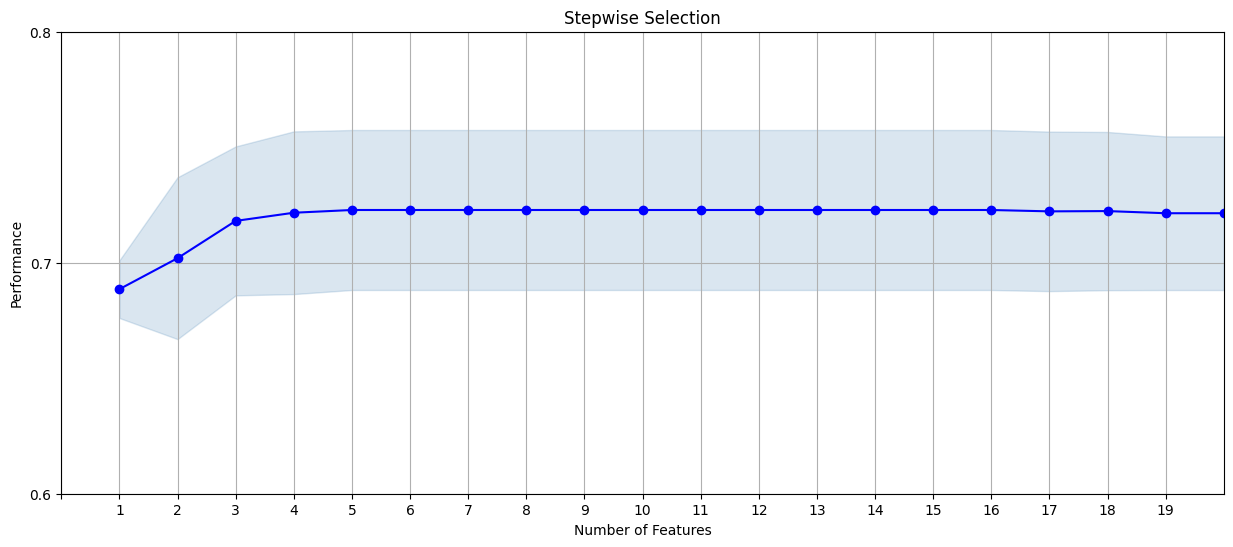

In [118]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
# plt.xticks(np.arange(0, len(X.columns), step=5))
plt.xticks(np.arange(0, num_wrapper, step=1))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([.6, .8])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('performance_nvars.png')
plt.show()

From this curve it looks like performance saturates around 5 or so number of features, but this was using a simple wrapper model. We should be somewhat conservative and we'll use 10 features for the models.

In [119]:
n_vars_keep = 10

In [120]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(ordered_vars_FS.loc[i+1,'feature_names'])[0])
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])))[0]
# You might also need this following line. It converts a list to a string
#         ordered_vars_FS.loc[i+1,'variable name'] = ordered_vars_FS.loc[i+1,'variable name'][0]
ordered_vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(21,)","[0.70557924867998, 0.6760051938577049, 0.68406...",0.68855,"(investor_funds/last_pymnt_amnt,)",0.028091,0.012483,0.008827,1.0,investor_funds/last_pymnt_amnt
2,"(3, 21)","[0.743755918386134, 0.658049196588606, 0.70406...",0.701958,"(interest_payments_Low, investor_funds/last_py...",0.07881,0.035021,0.024764,2.0,interest_payments_Low
3,"(3, 21, 39)","[0.755222135751193, 0.6766343332959117, 0.7224...",0.7181,"(interest_payments_Low, investor_funds/last_py...",0.072528,0.03223,0.02279,3.0,inq_last_6mths/total_rev_hi_lim
4,"(3, 18, 21, 39)","[0.7636115934943097, 0.6774442782388278, 0.723...",0.721639,"(interest_payments_Low, installment/last_pymnt...",0.07924,0.035213,0.024899,4.0,installment/last_pymnt_amnt
5,"(3, 14, 18, 21, 39)","[0.7636115934943097, 0.6789584516979291, 0.725...",0.722825,"(interest_payments_Low, grade+application_type...",0.077924,0.034628,0.024486,5.0,grade+application_type_TE
6,"(3, 14, 18, 21, 25, 39)","[0.7636115934943097, 0.6789584516979291, 0.725...",0.722825,"(interest_payments_Low, grade+application_type...",0.077924,0.034628,0.024486,6.0,revol_util/last_pymnt_amnt
7,"(3, 14, 18, 21, 25, 26, 39)","[0.7636115934943097, 0.6789584516979291, 0.725...",0.722825,"(interest_payments_Low, grade+application_type...",0.077924,0.034628,0.024486,7.0,annual_income/last_pymnt_amnt
8,"(3, 14, 18, 21, 25, 26, 27, 39)","[0.7636115934943097, 0.6789584516979291, 0.725...",0.722825,"(interest_payments_Low, grade+application_type...",0.077924,0.034628,0.024486,8.0,last_pymnt_amnt
9,"(3, 14, 18, 21, 25, 26, 27, 28, 39)","[0.7636115934943097, 0.6789584516979291, 0.725...",0.722825,"(interest_payments_Low, grade+application_type...",0.077924,0.034628,0.024486,9.0,open_acc/last_pymnt_amnt
10,"(3, 14, 18, 21, 25, 26, 27, 28, 29, 39)","[0.7636115934943097, 0.6789584516979291, 0.725...",0.722825,"(interest_payments_Low, grade+application_type...",0.077924,0.034628,0.024486,10.0,total_acc/last_pymnt_amnt


In [121]:
vars_top = ordered_vars_FS['variable name']
vars_top_list = ordered_vars_FS['variable name'].tolist()
vars_top.to_csv('final_vars_list.csv',index=False)
vars_top

1       investor_funds/last_pymnt_amnt
2                interest_payments_Low
3      inq_last_6mths/total_rev_hi_lim
4          installment/last_pymnt_amnt
5            grade+application_type_TE
6           revol_util/last_pymnt_amnt
7        annual_income/last_pymnt_amnt
8                      last_pymnt_amnt
9             open_acc/last_pymnt_amnt
10           total_acc/last_pymnt_amnt
11                 dti/last_pymnt_amnt
12    last_pymnt_amnt/total_rev_hi_lim
13           revol_bal/last_pymnt_amnt
14      last_pymnt_amnt/emp_length_int
15      inq_last_6mths/total_pymnt_inv
16          inq_last_6mths/total_pymnt
17         loan_amount/last_pymnt_amnt
18       funded_amount/last_pymnt_amnt
19                            grade_TE
20                 grade+pymnt_plan_TE
Name: variable name, dtype: object

In [122]:
filter_score.set_index('variable',drop=True,inplace=True)
filter_score = filter_score.iloc[1:,:]
filter_score

,filter score
variable,
total_pymnt/last_pymnt_amnt,0.299170
total_pymnt_inv/last_pymnt_amnt,0.294869
verification_status+interest_payments_TE,0.272043
interest_payments_Low,0.272043
funded_amount/total_pymnt,0.242260
...,...
purpose_vacation,0.000522
purpose_renewable_energy,0.000473
home_ownership_OTHER,0.000322


In [123]:
vars_top_sorted = pd.DataFrame(vars_top_list)
vars_top_sorted.columns=['variable']
vars_top_sorted.set_index('variable',drop=True,inplace=True)
vars_top_sorted.head(20)

""
variable
investor_funds/last_pymnt_amnt
interest_payments_Low
inq_last_6mths/total_rev_hi_lim
installment/last_pymnt_amnt
grade+application_type_TE
revol_util/last_pymnt_amnt
annual_income/last_pymnt_amnt
last_pymnt_amnt
open_acc/last_pymnt_amnt


In [124]:
vars_top_sorted = pd.concat([vars_top_sorted,filter_score],axis=1,join='inner')

In [125]:
vars_top_sorted.reset_index(inplace=True)
vars_top_sorted.reset_index(inplace=True)
vars_top_sorted['index'] = vars_top_sorted['index'] + 1
vars_top_sorted.rename(columns={'index':'wrapper order'},inplace=True)
vars_top_sorted.to_csv('vars_top_sorted.csv',index=False)
vars_top_sorted

,wrapper order,variable,filter score
0,1,investor_funds/last_pymnt_amnt,0.192803
1,2,interest_payments_Low,0.272043
2,3,inq_last_6mths/total_rev_hi_lim,0.151578
3,4,installment/last_pymnt_amnt,0.195808
4,5,grade+application_type_TE,0.215192
5,6,revol_util/last_pymnt_amnt,0.185191
6,7,annual_income/last_pymnt_amnt,0.183966
7,8,last_pymnt_amnt,0.183944
8,9,open_acc/last_pymnt_amnt,0.181133
9,10,total_acc/last_pymnt_amnt,0.178302


In [126]:
vars_top_list = vars_top_sorted['variable'].tolist()
vars_keep_list = vars_top_list[:n_vars_keep]
vars_keep_list.append('id')
vars_keep_list.append('target')
vars_keep_list

['investor_funds/last_pymnt_amnt',
 'interest_payments_Low',
 'inq_last_6mths/total_rev_hi_lim',
 'installment/last_pymnt_amnt',
 'grade+application_type_TE',
 'revol_util/last_pymnt_amnt',
 'annual_income/last_pymnt_amnt',
 'last_pymnt_amnt',
 'open_acc/last_pymnt_amnt',
 'total_acc/last_pymnt_amnt',
 'id',
 'target']

In [127]:
filter_score

,filter score
variable,
total_pymnt/last_pymnt_amnt,0.299170
total_pymnt_inv/last_pymnt_amnt,0.294869
verification_status+interest_payments_TE,0.272043
interest_payments_Low,0.272043
funded_amount/total_pymnt,0.242260
...,...
purpose_vacation,0.000522
purpose_renewable_energy,0.000473
home_ownership_OTHER,0.000322


In [128]:
X = X.filter(vars_keep_list, axis=1)
X.head()

,investor_funds/last_pymnt_amnt,interest_payments_Low,inq_last_6mths/total_rev_hi_lim,installment/last_pymnt_amnt,grade+application_type_TE,revol_util/last_pymnt_amnt,annual_income/last_pymnt_amnt,last_pymnt_amnt,open_acc/last_pymnt_amnt,total_acc/last_pymnt_amnt
0,-0.122419,0.947580,-0.007649,-0.122967,0.560320,-0.128681,-0.101072,-0.417166,-0.127977,-0.128025
1,-0.122419,-1.055318,-0.007649,-0.122967,-0.031003,-0.128681,-0.101072,-0.427949,-0.127977,-0.128025
2,-0.122419,-1.055318,-0.007649,-0.122967,-0.031003,-0.128681,-0.101072,-0.317902,-0.127977,-0.128025
3,-0.122419,-1.055318,-0.007649,-0.122967,-0.031003,-0.128681,-0.101072,-0.378593,-0.127977,-0.128025
4,-0.122419,0.947580,-0.007649,-0.122967,0.560320,-0.128681,-0.101072,-0.438714,-0.127977,-0.128025


In [129]:
# z scale the inputs
means = X.mean()
stdevs = X.std()
X = (X - means) / stdevs
X.describe()

,investor_funds/last_pymnt_amnt,interest_payments_Low,inq_last_6mths/total_rev_hi_lim,installment/last_pymnt_amnt,grade+application_type_TE,revol_util/last_pymnt_amnt,annual_income/last_pymnt_amnt,last_pymnt_amnt,open_acc/last_pymnt_amnt,total_acc/last_pymnt_amnt
count,8.760200e+05,8.760200e+05,8.760200e+05,8.760200e+05,8.760200e+05,8.760200e+05,8.760200e+05,8.760200e+05,8.760200e+05,8.760200e+05
mean,-2.958905e-17,-4.412402e-17,1.512708e-18,-1.297765e-19,-3.098415e-18,3.633743e-18,8.046145e-18,-3.244413e-18,1.751983e-17,-1.116078e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.224186e-01,-1.055318e+00,-7.649053e-03,-1.229674e-01,-3.942592e+00,-1.286811e-01,-1.010717e-01,-4.527833e-01,-1.279769e-01,-1.280251e-01
25%,-1.224186e-01,-1.055318e+00,-7.649053e-03,-1.229674e-01,-9.546140e-01,-1.286811e-01,-1.010717e-01,-3.945751e-01,-1.279769e-01,-1.280251e-01
50%,-1.224186e-01,9.475803e-01,-7.649053e-03,-1.229674e-01,-3.100273e-02,-1.286811e-01,-1.010717e-01,-3.565291e-01,-1.279769e-01,-1.280251e-01
75%,-1.224186e-01,9.475803e-01,-7.649049e-03,-1.229674e-01,5.603199e-01,-1.286810e-01,-1.010717e-01,-2.794826e-01,-1.279769e-01,-1.280251e-01
max,1.418151e+01,9.475803e-01,3.252701e+02,1.893157e+01,1.870899e+00,1.669312e+01,3.913202e+02,7.117296e+00,3.457580e+01,2.796756e+01


In [130]:
Y = data.filter(['target'], axis=1)
Y.head()

,target
0,1
1,0
2,1
3,1
4,1


In [131]:
df_model = pd.concat([X,Y], axis=1)
print(X.shape,Y.shape,df_model)
df_model.head()

(876020, 10) (876020, 1)         investor_funds/last_pymnt_amnt  interest_payments_Low  \
0                            -0.122419               0.947580   
1                            -0.122419              -1.055318   
2                            -0.122419              -1.055318   
3                            -0.122419              -1.055318   
4                            -0.122419               0.947580   
...                                ...                    ...   
887374                       -0.122419               0.947580   
887375                       -0.122419               0.947580   
887376                       -0.122419              -1.055318   
887377                       -0.122419              -1.055318   
887378                       -0.122419               0.947580   

        inq_last_6mths/total_rev_hi_lim  installment/last_pymnt_amnt  \
0                             -0.007649                    -0.122967   
1                             -0.007649           

,investor_funds/last_pymnt_amnt,interest_payments_Low,inq_last_6mths/total_rev_hi_lim,installment/last_pymnt_amnt,grade+application_type_TE,revol_util/last_pymnt_amnt,annual_income/last_pymnt_amnt,last_pymnt_amnt,open_acc/last_pymnt_amnt,total_acc/last_pymnt_amnt,target
0,-0.122419,0.947580,-0.007649,-0.122967,0.560320,-0.128681,-0.101072,-0.417166,-0.127977,-0.128025,1
1,-0.122419,-1.055318,-0.007649,-0.122967,-0.031003,-0.128681,-0.101072,-0.427949,-0.127977,-0.128025,0
2,-0.122419,-1.055318,-0.007649,-0.122967,-0.031003,-0.128681,-0.101072,-0.317902,-0.127977,-0.128025,1
3,-0.122419,-1.055318,-0.007649,-0.122967,-0.031003,-0.128681,-0.101072,-0.378593,-0.127977,-0.128025,1
4,-0.122419,0.947580,-0.007649,-0.122967,0.560320,-0.128681,-0.101072,-0.438714,-0.127977,-0.128025,1


### Let's look again at the correlations in the final modeling data

In [132]:
correlation = df_model.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)

#Plotting
trace = go.Heatmap(z = np.flip(corr_array, axis=1),
                   x = list(reversed(matrix_cols)),
                   y = matrix_cols,
                   colorscale = "Bluered",
                   colorbar   = dict(title = "Pearson Correlation coefficient",
                                     titleside = "right"
                                    ) ,
                  )

layout = go.Layout(dict(title = "Correlation Matrix for fields",
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                      ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9))
                       )
                  )

data_corr = [trace]
# py.init_notebook_mode() # if the figure doesn't show in notebook, uncomment this line
fig = go.Figure(data=data_corr,layout=layout)
py.iplot(fig)

In [133]:
df_model = pd.concat([X,Y], axis=1)
Y_df = df_model['target']
print(X.shape,Y.shape,df_model)
df_model.head()

(876020, 10) (876020, 1)         investor_funds/last_pymnt_amnt  interest_payments_Low  \
0                            -0.122419               0.947580   
1                            -0.122419              -1.055318   
2                            -0.122419              -1.055318   
3                            -0.122419              -1.055318   
4                            -0.122419               0.947580   
...                                ...                    ...   
887374                       -0.122419               0.947580   
887375                       -0.122419               0.947580   
887376                       -0.122419              -1.055318   
887377                       -0.122419              -1.055318   
887378                       -0.122419               0.947580   

        inq_last_6mths/total_rev_hi_lim  installment/last_pymnt_amnt  \
0                             -0.007649                    -0.122967   
1                             -0.007649           

,investor_funds/last_pymnt_amnt,interest_payments_Low,inq_last_6mths/total_rev_hi_lim,installment/last_pymnt_amnt,grade+application_type_TE,revol_util/last_pymnt_amnt,annual_income/last_pymnt_amnt,last_pymnt_amnt,open_acc/last_pymnt_amnt,total_acc/last_pymnt_amnt,target
0,-0.122419,0.947580,-0.007649,-0.122967,0.560320,-0.128681,-0.101072,-0.417166,-0.127977,-0.128025,1
1,-0.122419,-1.055318,-0.007649,-0.122967,-0.031003,-0.128681,-0.101072,-0.427949,-0.127977,-0.128025,0
2,-0.122419,-1.055318,-0.007649,-0.122967,-0.031003,-0.128681,-0.101072,-0.317902,-0.127977,-0.128025,1
3,-0.122419,-1.055318,-0.007649,-0.122967,-0.031003,-0.128681,-0.101072,-0.378593,-0.127977,-0.128025,1
4,-0.122419,0.947580,-0.007649,-0.122967,0.560320,-0.128681,-0.101072,-0.438714,-0.127977,-0.128025,1


In [134]:
X.head()

,investor_funds/last_pymnt_amnt,interest_payments_Low,inq_last_6mths/total_rev_hi_lim,installment/last_pymnt_amnt,grade+application_type_TE,revol_util/last_pymnt_amnt,annual_income/last_pymnt_amnt,last_pymnt_amnt,open_acc/last_pymnt_amnt,total_acc/last_pymnt_amnt
0,-0.122419,0.947580,-0.007649,-0.122967,0.560320,-0.128681,-0.101072,-0.417166,-0.127977,-0.128025
1,-0.122419,-1.055318,-0.007649,-0.122967,-0.031003,-0.128681,-0.101072,-0.427949,-0.127977,-0.128025
2,-0.122419,-1.055318,-0.007649,-0.122967,-0.031003,-0.128681,-0.101072,-0.317902,-0.127977,-0.128025
3,-0.122419,-1.055318,-0.007649,-0.122967,-0.031003,-0.128681,-0.101072,-0.378593,-0.127977,-0.128025
4,-0.122419,0.947580,-0.007649,-0.122967,0.560320,-0.128681,-0.101072,-0.438714,-0.127977,-0.128025


## 🔪Train Test Split

Generally this should better be done before target encoding and normalization to avoid data leakage, but our data is pretty large so it's probably OK.

In [135]:
from sklearn.model_selection import train_test_split
X_model, X_val, Y_model, Y_val = train_test_split(X,Y,test_size=.2,shuffle=True)
print(X_model.shape,Y_model.shape,X_val.shape,Y_val.shape)

(700816, 10) (700816, 1) (175204, 10) (175204, 1)


In [136]:
# let's truncate all the outliers in the training X to max of 10 stdevs
X_model.clip(lower = -10, upper = 10, inplace = True)
X_model.describe()

,investor_funds/last_pymnt_amnt,interest_payments_Low,inq_last_6mths/total_rev_hi_lim,installment/last_pymnt_amnt,grade+application_type_TE,revol_util/last_pymnt_amnt,annual_income/last_pymnt_amnt,last_pymnt_amnt,open_acc/last_pymnt_amnt,total_acc/last_pymnt_amnt
count,700816.000000,700816.000000,700816.000000,700816.000000,700816.000000,700816.000000,700816.000000,700816.000000,700816.000000,700816.000000
mean,-0.007334,0.000415,-0.006821,-0.007583,0.000184,-0.003004,-0.006269,-0.000326,-0.006081,-0.005871
std,0.910705,0.999978,0.091039,0.902810,1.000557,0.967373,0.741329,0.999434,0.921366,0.927949
min,-0.122419,-1.055318,-0.007649,-0.122967,-3.942592,-0.128681,-0.101072,-0.452783,-0.127977,-0.128025
25%,-0.122419,-1.055318,-0.007649,-0.122967,-0.954614,-0.128681,-0.101072,-0.394561,-0.127977,-0.128025
50%,-0.122419,0.947580,-0.007649,-0.122967,-0.031003,-0.128681,-0.101072,-0.356560,-0.127977,-0.128025
75%,-0.122419,0.947580,-0.007649,-0.122967,0.560320,-0.128681,-0.101072,-0.279483,-0.127977,-0.128025
max,10.000000,0.947580,10.000000,10.000000,1.870899,10.000000,10.000000,7.117296,10.000000,10.000000


<a name="Dealing-with-Imbalanced-Dataset"></a>
# Dealing with Imbalanced Dataset
Our data set is an unbalanced data set (80% good loans). What we are more concerned about is the accuracy of bad loan prediction, so balancing the data is particularly important.



Balanced data can be oversampled or undersampled. Random undersampling and SMOTE (oversampling) methods are provided below. Since the data set is very large, the data set after undersampling is used subsequently. In comparison, the authenticity of the data is guaranteed.

image.png

### One method of oversampling to balance the data is SMOTE (Synthetic Minority Oversampling Technique)

In [137]:
smote = SMOTE(random_state=42)
# oversample the training set
X_model_smote, Y_model_smote = smote.fit_resample(X_model, Y_model)

In [138]:
print(X_model_smote.shape,Y_model_smote.shape)

(1309054, 10) (1309054, 1)


The smote training set is balanced in y but is really large. If we subsample it we are thrrowing away some of the actual bads along with the artificial bads. For this large data set it would be better to do undersampling: Go back to the unbalanced data, keep all the bads and subsample the goods.

In [139]:
df_model = pd.concat([X_model,Y_model], axis=1)
print(X_model.shape,Y_model.shape,df_model)
df_model.head()

(700816, 10) (700816, 1)         investor_funds/last_pymnt_amnt  interest_payments_Low  \
549499                       -0.122419              -1.055318   
549853                       -0.122419               0.947580   
459054                       -0.122419               0.947580   
665664                       -0.122419              -1.055318   
590574                       -0.122419               0.947580   
...                                ...                    ...   
173933                       -0.122419               0.947580   
830979                       -0.122419               0.947580   
176651                       -0.122419              -1.055318   
185998                       -0.122419               0.947580   
498417                       -0.122419              -1.055318   

        inq_last_6mths/total_rev_hi_lim  installment/last_pymnt_amnt  \
549499                        -0.007649                    -0.122967   
549853                        -0.007649           

,investor_funds/last_pymnt_amnt,interest_payments_Low,inq_last_6mths/total_rev_hi_lim,installment/last_pymnt_amnt,grade+application_type_TE,revol_util/last_pymnt_amnt,annual_income/last_pymnt_amnt,last_pymnt_amnt,open_acc/last_pymnt_amnt,total_acc/last_pymnt_amnt,target
549499,-0.122419,-1.055318,-0.007649,-0.122967,-0.031003,-0.128681,-0.101072,-0.300550,-0.127977,-0.128025,1
549853,-0.122419,0.947580,-0.007649,-0.122967,0.560320,-0.128681,-0.101072,-0.388505,-0.127977,-0.128025,1
459054,-0.122419,0.947580,-0.007649,-0.122967,1.267607,-0.128681,-0.101072,-0.387843,-0.127977,-0.128025,1
665664,-0.122419,-1.055318,-0.007649,-0.122967,-0.031003,-0.128681,-0.101072,-0.391890,-0.127977,-0.128025,1
590574,-0.122419,0.947580,-0.007649,-0.122967,-0.031003,-0.128681,-0.101072,-0.397018,-0.127977,-0.128025,1


In [140]:
df_model_bads = df_model[df_model['target'] == 0]
df_model_goods = df_model[df_model['target'] == 1]
ratio = len(df_model_bads)/len(df_model)
print(len(df_model_bads),ratio)

46289 0.06605014725691194


In [141]:
df_model_goods_sample = df_model_goods.sample(frac=ratio)
print(df_model_goods.shape,df_model_goods_sample.shape)

(654527, 11) (43232, 11)


In [142]:
df_model_sample = pd.concat([df_model_bads,df_model_goods_sample])
df_model_sample_shuffle = df_model_sample.sample(frac=1)
print(df_model_sample_shuffle.shape)
df_model_sample_shuffle.head(10)

(89521, 11)


,investor_funds/last_pymnt_amnt,interest_payments_Low,inq_last_6mths/total_rev_hi_lim,installment/last_pymnt_amnt,grade+application_type_TE,revol_util/last_pymnt_amnt,annual_income/last_pymnt_amnt,last_pymnt_amnt,open_acc/last_pymnt_amnt,total_acc/last_pymnt_amnt,target
86563,-0.122419,-1.055318,-0.007649,-0.122967,-1.539419,-0.128681,-0.101072,-0.366093,-0.127977,-0.128025,0
213788,-0.122419,-1.055318,-0.007649,-0.122967,-0.954614,-0.128681,-0.101072,-0.294660,-0.127977,-0.128025,1
140710,-0.122419,0.947580,-0.007649,-0.122967,1.267607,-0.128681,-0.101072,2.727394,-0.127977,-0.128025,1
303844,-0.122419,0.947580,-0.007649,-0.122967,1.267607,-0.128681,-0.101072,-0.375747,-0.127977,-0.128025,1
19362,-0.122419,0.947580,-0.007649,-0.122967,0.560320,-0.128681,-0.101072,1.727470,-0.127977,-0.128025,1
50477,-0.122419,0.947580,-0.007649,-0.122967,1.267607,-0.128681,-0.101072,-0.386882,-0.127977,-0.128025,0
444864,-0.122419,-1.055318,-0.007649,-0.122967,-0.031003,-0.128681,-0.101072,0.719019,-0.127977,-0.128025,1
159820,-0.122419,-1.055318,-0.007649,-0.122967,-0.031003,-0.128681,-0.101072,-0.435678,-0.127977,-0.128025,0
340375,-0.122419,0.947580,-0.007649,-0.122967,0.560320,-0.128681,-0.101072,0.916471,-0.127977,-0.128025,1
112235,-0.122419,0.947580,-0.007649,-0.122967,0.560320,-0.128681,-0.101072,-0.244942,-0.127977,-0.128025,0


In [143]:
X_model_sample = df_model_sample_shuffle.drop(columns=['target'])
Y_model_sample = pd.DataFrame(df_model_sample_shuffle['target'])

In [144]:
print('Duration: ', datetime.now() - start_time)

Duration:  0:09:24.963236


<a name="Model-Building"></a>
# Model Building




We now have 3 different data sets to train on, and one set to test with. We have
X_model (normal), X_model_smote (oversampled via smote - large!), X_model_sample (kept all the bads, sampled the goods).

I'm going to do a "manual cross validation", where I train and evaluate each model multiple times, each using a different trn/tst split. This is a bootstrap cross validation process. I do it manually so I can watch the variation of model results across each model train.

So for each model build I will have a performance measure for training, testing and a validation, which is the real holdout tesing sample.

In [145]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','Val'],index=range(1000))
counter = 0
model_counter = 0
nitermax = 10 # this is the number of bootstrap cross validations

In [146]:
X_model.head()

,investor_funds/last_pymnt_amnt,interest_payments_Low,inq_last_6mths/total_rev_hi_lim,installment/last_pymnt_amnt,grade+application_type_TE,revol_util/last_pymnt_amnt,annual_income/last_pymnt_amnt,last_pymnt_amnt,open_acc/last_pymnt_amnt,total_acc/last_pymnt_amnt
549499,-0.122419,-1.055318,-0.007649,-0.122967,-0.031003,-0.128681,-0.101072,-0.300550,-0.127977,-0.128025
549853,-0.122419,0.947580,-0.007649,-0.122967,0.560320,-0.128681,-0.101072,-0.388505,-0.127977,-0.128025
459054,-0.122419,0.947580,-0.007649,-0.122967,1.267607,-0.128681,-0.101072,-0.387843,-0.127977,-0.128025
665664,-0.122419,-1.055318,-0.007649,-0.122967,-0.031003,-0.128681,-0.101072,-0.391890,-0.127977,-0.128025
590574,-0.122419,0.947580,-0.007649,-0.122967,-0.031003,-0.128681,-0.101072,-0.397018,-0.127977,-0.128025


In [147]:
Y_model.head()

,target
549499,1
549853,1
459054,1
665664,1
590574,1


In [148]:
detect_rate = .2
num_X_val = len(X_val)

In [149]:
X_val_save = X_val.copy()
X_val_save.head()

,investor_funds/last_pymnt_amnt,interest_payments_Low,inq_last_6mths/total_rev_hi_lim,installment/last_pymnt_amnt,grade+application_type_TE,revol_util/last_pymnt_amnt,annual_income/last_pymnt_amnt,last_pymnt_amnt,open_acc/last_pymnt_amnt,total_acc/last_pymnt_amnt
188277,-0.122419,0.947580,-0.007649,-0.122967,0.560320,-0.128681,-0.101072,-0.390636,-0.127977,-0.128025
568541,-0.122419,-1.055318,-0.007649,-0.122967,-2.922979,-0.128681,-0.101072,-0.280859,-0.127977,-0.128025
320353,-0.122419,-1.055318,-0.007649,-0.122967,-0.954614,-0.128681,-0.101072,-0.315046,-0.127977,-0.128025
749613,-0.122419,-1.055318,-0.007649,-0.122967,-0.031003,-0.128681,-0.101072,-0.382523,-0.127977,-0.128025
7517,-0.122419,0.947580,-0.007649,-0.122967,1.267607,-0.128681,-0.101072,-0.418936,-0.127977,-0.128025


In [150]:
X_model.head()

,investor_funds/last_pymnt_amnt,interest_payments_Low,inq_last_6mths/total_rev_hi_lim,installment/last_pymnt_amnt,grade+application_type_TE,revol_util/last_pymnt_amnt,annual_income/last_pymnt_amnt,last_pymnt_amnt,open_acc/last_pymnt_amnt,total_acc/last_pymnt_amnt
549499,-0.122419,-1.055318,-0.007649,-0.122967,-0.031003,-0.128681,-0.101072,-0.300550,-0.127977,-0.128025
549853,-0.122419,0.947580,-0.007649,-0.122967,0.560320,-0.128681,-0.101072,-0.388505,-0.127977,-0.128025
459054,-0.122419,0.947580,-0.007649,-0.122967,1.267607,-0.128681,-0.101072,-0.387843,-0.127977,-0.128025
665664,-0.122419,-1.055318,-0.007649,-0.122967,-0.031003,-0.128681,-0.101072,-0.391890,-0.127977,-0.128025
590574,-0.122419,0.947580,-0.007649,-0.122967,-0.031003,-0.128681,-0.101072,-0.397018,-0.127977,-0.128025


In [151]:
%%time
MODEL = 'log reg'

DR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'val'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_model, Y_model, test_size = .3)

    model = LogisticRegression(max_iter=1000)
 
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()
    X_val = X_val_save.copy()
    num_X_tst = len(X_tst)
    num_X_trn = len(X_trn)

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['target'] = Y_trn_save['target']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=True).head(topRows)
    needed = temp.loc[:,'target']
    DR.loc[niter, 'trn'] = (topRows - sum(needed))/(num_X_trn - sum(X_trn.loc[:,'target']))

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['target'] = Y_tst['target']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=True).head(topRows)
    needed = temp.loc[:,'target']
    DR.loc[niter, 'tst'] = (topRows - sum(needed))/(num_X_tst - sum(X_tst.loc[:,'target']))

    predictions = model.predict_proba(X_val)[:,1]
    X_val['predicted']=predictions
    X_val['target'] = Y_val['target']
    topRows = int(round(X_val.shape[0]*detect_rate))
    temp = X_val.sort_values('predicted',ascending=True).head(topRows)
    needed = temp.loc[:,'target']
    DR.loc[niter, 'val'] = (topRows - sum(needed))/(num_X_val - sum(X_val.loc[:,'target']))
    
    print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
    Modeling_output.iloc[counter] = [MODEL,DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
    counter = counter + 1
    
print(DR.mean())
model_counter = model_counter + 1

0 0.42402445048160037 0.4268547168453623 0.4259495284221259
1 0.4260167113742176 0.43158198614318705 0.4283286600390857
2 0.4284133861897299 0.4214431189991271 0.42917834990228565
3 0.4288362321974729 0.4266522988505747 0.42849859801172574
4 0.4298958558669922 0.4185929648241206 0.4286685359843657
5 0.42773226155510896 0.42046758462421113 0.42679921828532585
6 0.425008467530868 0.42788879235447436 0.42739400118956583
7 0.4287887253988949 0.42017761989342806 0.4282436910527657
8 0.42543832476302584 0.430856000571143 0.4287535049706857
9 0.4263396296182171 0.42584562012142235 0.42849859801172574
trn    0.427049
tst    0.425036
val    0.428031
dtype: float64
CPU times: user 1min 7s, sys: 7.41 s, total: 1min 15s
Wall time: 10.5 s


In [152]:
# %%time
# MODEL = 'log reg sampled'

# DR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'val'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_model_sample, Y_model_sample, test_size = .3)

#     model = LogisticRegression(max_iter=1000)
 
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()
#     X_val = X_val_save.copy()
#     num_X_tst = len(X_tst)
#     num_X_trn = len(X_trn)

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['target'] = Y_trn_save['target']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=True).head(topRows)
#     needed = temp.loc[:,'target']
#     DR.loc[niter, 'trn'] = (topRows - sum(needed))/(num_X_trn - sum(X_trn.loc[:,'target']))

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['target'] = Y_tst['target']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=True).head(topRows)
#     needed = temp.loc[:,'target']
#     DR.loc[niter, 'tst'] = (topRows - sum(needed))/(num_X_tst - sum(X_tst.loc[:,'target']))

#     predictions = model.predict_proba(X_val)[:,1]
#     X_val['predicted']=predictions
#     X_val['target'] = Y_val['target']
#     topRows = int(round(X_val.shape[0]*detect_rate))
#     temp = X_val.sort_values('predicted',ascending=True).head(topRows)
#     needed = temp.loc[:,'target']
#     DR.loc[niter, 'val'] = (topRows - sum(needed))/(num_X_val - sum(X_val.loc[:,'target']))
    
#     print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
#     Modeling_output.iloc[counter] = [MODEL,DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
#     counter = counter + 1
    
# print(DR.mean())
# model_counter = model_counter + 1

In [153]:
# %%time
# MODEL = 'log reg smote'

# DR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'val'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_model_smote, Y_model_smote, test_size = .3)

#     model = LogisticRegression(max_iter=1000)
 
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()
#     X_val = X_val_save.copy()
#     num_X_tst = len(X_tst)
#     num_X_trn = len(X_trn)

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['target'] = Y_trn_save['target']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=True).head(topRows)
#     needed = temp.loc[:,'target']
#     DR.loc[niter, 'trn'] = (topRows - sum(needed))/(num_X_trn - sum(X_trn.loc[:,'target']))

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['target'] = Y_tst['target']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=True).head(topRows)
#     needed = temp.loc[:,'target']
#     DR.loc[niter, 'tst'] = (topRows - sum(needed))/(num_X_tst - sum(X_tst.loc[:,'target']))

#     predictions = model.predict_proba(X_val)[:,1]
#     X_val['predicted']=predictions
#     X_val['target'] = Y_val['target']
#     topRows = int(round(X_val.shape[0]*detect_rate))
#     temp = X_val.sort_values('predicted',ascending=True).head(topRows)
#     needed = temp.loc[:,'target']
#     DR.loc[niter, 'val'] = (topRows - sum(needed))/(num_X_val - sum(X_val.loc[:,'target']))
    
#     print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
#     Modeling_output.iloc[counter] = [MODEL,DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
#     counter = counter + 1
    
# print(DR.mean())
# model_counter = model_counter + 1

In [154]:
%%time
MODEL = 'RF'

DR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'val'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_model, Y_model, test_size = .3)

    model = RandomForestClassifier(n_estimators=30,max_depth=7,min_samples_split=50,min_samples_leaf=20,max_features=5)
 
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()
    X_val = X_val_save.copy()
    num_X_tst = len(X_tst)
    num_X_trn = len(X_trn)

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['target'] = Y_trn_save['target']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=True).head(topRows)
    needed = temp.loc[:,'target']
    DR.loc[niter, 'trn'] = (topRows - sum(needed))/(num_X_trn - sum(X_trn.loc[:,'target']))

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['target'] = Y_tst['target']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=True).head(topRows)
    needed = temp.loc[:,'target']
    DR.loc[niter, 'tst'] = (topRows - sum(needed))/(num_X_tst - sum(X_tst.loc[:,'target']))

    predictions = model.predict_proba(X_val)[:,1]
    X_val['predicted']=predictions
    X_val['target'] = Y_val['target']
    topRows = int(round(X_val.shape[0]*detect_rate))
    temp = X_val.sort_values('predicted',ascending=True).head(topRows)
    needed = temp.loc[:,'target']
    DR.loc[niter, 'val'] = (topRows - sum(needed))/(num_X_val - sum(X_val.loc[:,'target']))
    
    print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
    Modeling_output.iloc[counter] = [MODEL,DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
    counter = counter + 1
    
print(DR.mean())
model_counter = model_counter + 1

0 0.4426910299003322 0.4398084318989914 0.4401393491375648
1 0.4422839124520836 0.43920809124166127 0.4412439459597247
2 0.4412129096202688 0.43797757623366423 0.43818506245220495
3 0.44308166409861327 0.4428788207240408 0.4397994731922848
4 0.4422934420155613 0.43996834760089204 0.4420086668366046
5 0.4407615057605816 0.44572213784624287 0.44047922508284476
6 0.43886138613861386 0.43839931276397737 0.43657065171212506
7 0.43755375353237497 0.44542343260758754 0.43928965927436486
8 0.44243168560024565 0.44135869961367447 0.44166879089132466
9 0.44267080745341614 0.4428277379515934 0.43996941116492483
trn    0.441384
tst    0.441357
val    0.439935
dtype: float64
CPU times: user 1min 5s, sys: 1.29 s, total: 1min 7s
Wall time: 1min 6s


In [155]:
# %%time
# MODEL = 'RF sampled'

# DR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'val'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_model_sample, Y_model_sample, test_size = .3)

#     model = RandomForestClassifier(n_estimators=30,max_depth=7,min_samples_split=50,min_samples_leaf=20,max_features=5)
 
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()
#     X_val = X_val_save.copy()
#     num_X_tst = len(X_tst)
#     num_X_trn = len(X_trn)

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['target'] = Y_trn_save['target']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=True).head(topRows)
#     needed = temp.loc[:,'target']
#     DR.loc[niter, 'trn'] = (topRows - sum(needed))/(num_X_trn - sum(X_trn.loc[:,'target']))

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['target'] = Y_tst['target']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=True).head(topRows)
#     needed = temp.loc[:,'target']
#     DR.loc[niter, 'tst'] = (topRows - sum(needed))/(num_X_tst - sum(X_tst.loc[:,'target']))

#     predictions = model.predict_proba(X_val)[:,1]
#     X_val['predicted']=predictions
#     X_val['target'] = Y_val['target']
#     topRows = int(round(X_val.shape[0]*detect_rate))
#     temp = X_val.sort_values('predicted',ascending=True).head(topRows)
#     needed = temp.loc[:,'target']
#     DR.loc[niter, 'val'] = (topRows - sum(needed))/(num_X_val - sum(X_val.loc[:,'target']))
    
#     print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
#     Modeling_output.iloc[counter] = [MODEL,DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
#     counter = counter + 1
    
# print(DR.mean())
# model_counter = model_counter + 1

In [156]:
# %%time
# MODEL = 'RF smote'

# DR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'val'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_model_smote, Y_model_smote, test_size = .3)

#     model = RandomForestClassifier(n_estimators=30,max_depth=7,min_samples_split=50,min_samples_leaf=20,max_features=7)
 
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()
#     X_val = X_val_save.copy()
#     num_X_tst = len(X_tst)
#     num_X_trn = len(X_trn)

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['target'] = Y_trn_save['target']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=True).head(topRows)
#     needed = temp.loc[:,'target']
#     DR.loc[niter, 'trn'] = (topRows - sum(needed))/(num_X_trn - sum(X_trn.loc[:,'target']))

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['target'] = Y_tst['target']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=True).head(topRows)
#     needed = temp.loc[:,'target']
#     DR.loc[niter, 'tst'] = (topRows - sum(needed))/(num_X_tst - sum(X_tst.loc[:,'target']))

#     predictions = model.predict_proba(X_val)[:,1]
#     X_val['predicted']=predictions
#     X_val['target'] = Y_val['target']
#     topRows = int(round(X_val.shape[0]*detect_rate))
#     temp = X_val.sort_values('predicted',ascending=True).head(topRows)
#     needed = temp.loc[:,'target']
#     DR.loc[niter, 'val'] = (topRows - sum(needed))/(num_X_val - sum(X_val.loc[:,'target']))
# 
#     print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
#     Modeling_output.iloc[counter] = [MODEL,DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
#     counter = counter + 1
    
# print(DR.mean())
# model_counter = model_counter + 1

In [157]:
%%time
MODEL = 'Cat boost'

DR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'val'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_model, Y_model, test_size = .3)

    model = CatBoostClassifier(verbose=0, iterations=50, learning_rate=.1, l2_leaf_reg=10)
 
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()
    X_val = X_val_save.copy()
    num_X_tst = len(X_tst)
    num_X_trn = len(X_trn)

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['target'] = Y_trn_save['target']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=True).head(topRows)
    needed = temp.loc[:,'target']
    DR.loc[niter, 'trn'] = (topRows - sum(needed))/(num_X_trn - sum(X_trn.loc[:,'target']))

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['target'] = Y_tst['target']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=True).head(topRows)
    needed = temp.loc[:,'target']
    DR.loc[niter, 'tst'] = (topRows - sum(needed))/(num_X_tst - sum(X_tst.loc[:,'target']))

    predictions = model.predict_proba(X_val)[:,1]
    X_val['predicted']=predictions
    X_val['target'] = Y_val['target']
    topRows = int(round(X_val.shape[0]*detect_rate))
    temp = X_val.sort_values('predicted',ascending=True).head(topRows)
    needed = temp.loc[:,'target']
    DR.loc[niter, 'val'] = (topRows - sum(needed))/(num_X_val - sum(X_val.loc[:,'target']))
    
    print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
    Modeling_output.iloc[counter] = [MODEL,DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
    counter = counter + 1
    
print(DR.mean())
model_counter = model_counter + 1

0 0.4970022869151369 0.49364726150312255 0.4940946554507605
1 0.4963663238282934 0.4951863916033297 0.4946044693686804
2 0.4966463602239862 0.49394357002973815 0.49426459342340046
3 0.4949513606698682 0.5008330315103223 0.49596397314980034
4 0.497995435761426 0.49332756257664284 0.4952842212592404
5 0.4961000371425034 0.49438523710750304 0.4951142832866004
6 0.49528491481928083 0.4962713322816578 0.4946894383550004
7 0.4944466664615574 0.5014507471347744 0.49579403517716036
8 0.49815259560317754 0.4888856708420824 0.4945195003823604
9 0.4975621798432389 0.4944896636173738 0.4957090661908403
trn    0.496451
tst    0.495242
val    0.495004
dtype: float64
CPU times: user 35.6 s, sys: 2.31 s, total: 37.9 s
Wall time: 9.46 s


In [158]:
# %%time
# MODEL = 'Cat boost sampled'

# DR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'val'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_model_sample, Y_model_sample, test_size = .3)

#     model = CatBoostClassifier(verbose=0, iterations=50, learning_rate=.1, l2_leaf_reg=10)
 
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()
#     X_val = X_val_save.copy()
#     num_X_tst = len(X_tst)
#     num_X_trn = len(X_trn)

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['target'] = Y_trn_save['target']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=True).head(topRows)
#     needed = temp.loc[:,'target']
#     DR.loc[niter, 'trn'] = (topRows - sum(needed))/(num_X_trn - sum(X_trn.loc[:,'target']))

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['target'] = Y_tst['target']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=True).head(topRows)
#     needed = temp.loc[:,'target']
#     DR.loc[niter, 'tst'] = (topRows - sum(needed))/(num_X_tst - sum(X_tst.loc[:,'target']))

#     predictions = model.predict_proba(X_val)[:,1]
#     X_val['predicted']=predictions
#     X_val['target'] = Y_val['target']
#     topRows = int(round(X_val.shape[0]*detect_rate))
#     temp = X_val.sort_values('predicted',ascending=True).head(topRows)
#     needed = temp.loc[:,'target']
#     DR.loc[niter, 'val'] = (topRows - sum(needed))/(num_X_val - sum(X_val.loc[:,'target']))
    
#     print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
#     Modeling_output.iloc[counter] = [MODEL,DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
#     counter = counter + 1
    
# print(DR.mean())
# model_counter = model_counter + 1

In [159]:
# %%time
# MODEL = 'Cat boost smote'

# DR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'val'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_model_smote, Y_model_smote, test_size = .3)

#     model = CatBoostClassifier(verbose=0, iterations=50, learning_rate=.1, l2_leaf_reg=10)
 
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()
#     X_val = X_val_save.copy()
#     num_X_tst = len(X_tst)
#     num_X_trn = len(X_trn)

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['target'] = Y_trn_save['target']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=True).head(topRows)
#     needed = temp.loc[:,'target']
#     DR.loc[niter, 'trn'] = (topRows - sum(needed))/(num_X_trn - sum(X_trn.loc[:,'target']))

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['target'] = Y_tst['target']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=True).head(topRows)
#     needed = temp.loc[:,'target']
#     DR.loc[niter, 'tst'] = (topRows - sum(needed))/(num_X_tst - sum(X_tst.loc[:,'target']))

#     predictions = model.predict_proba(X_val)[:,1]
#     X_val['predicted']=predictions
#     X_val['target'] = Y_val['target']
#     topRows = int(round(X_val.shape[0]*detect_rate))
#     temp = X_val.sort_values('predicted',ascending=True).head(topRows)
#     needed = temp.loc[:,'target']
#     DR.loc[niter, 'val'] = (topRows - sum(needed))/(num_X_val - sum(X_val.loc[:,'target']))
# 
#     print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
#     Modeling_output.iloc[counter] = [MODEL,DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
#     counter = counter + 1
    
# print(DR.mean())
# model_counter = model_counter + 1

In [160]:
%%time
MODEL = 'LGBM'

DR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'val'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_model, Y_model, test_size = .3)

    model = lgb.LGBMClassifier(num_leaves=4,n_estimators=80)

    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()
    X_val = X_val_save.copy()
    num_X_tst = len(X_tst)
    num_X_trn = len(X_trn)

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['target'] = Y_trn_save['target']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=True).head(topRows)
    needed = temp.loc[:,'target']
    DR.loc[niter, 'trn'] = (topRows - sum(needed))/(num_X_trn - sum(X_trn.loc[:,'target']))

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['target'] = Y_tst['target']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=True).head(topRows)
    needed = temp.loc[:,'target']
    DR.loc[niter, 'tst'] = (topRows - sum(needed))/(num_X_tst - sum(X_tst.loc[:,'target']))

    predictions = model.predict_proba(X_val)[:,1]
    X_val['predicted']=predictions
    X_val['target'] = Y_val['target']
    topRows = int(round(X_val.shape[0]*detect_rate))
    temp = X_val.sort_values('predicted',ascending=True).head(topRows)
    needed = temp.loc[:,'target']
    DR.loc[niter, 'val'] = (topRows - sum(needed))/(num_X_val - sum(X_val.loc[:,'target']))
    
    print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
    Modeling_output.iloc[counter] = [MODEL,DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
    counter = counter + 1
    
print(DR.mean())
model_counter = model_counter + 1

0 0.5393793273986153 0.5321805266556647 0.5329254821989974
1 0.5402483971877227 0.5424225110698472 0.537088962528677
2 0.5356844288943245 0.5360920526014865 0.5297816297051576
3 0.5358402971216342 0.542313470205308 0.5338601410485173
4 0.5381132772798669 0.5333574529667149 0.5301215056504376
5 0.5415450775610505 0.5323285277413717 0.5361543036791571
6 0.5301537126565018 0.5387632836459596 0.5269776531565978
7 0.5377451585049957 0.5307697857297453 0.5296116917325177
8 0.5410109754212398 0.536144578313253 0.5361543036791571
9 0.5474382419489818 0.5412804791102239 0.5431217605573966
trn    0.538716
tst    0.536565
val    0.533580
dtype: float64
CPU times: user 27.1 s, sys: 1.15 s, total: 28.2 s
Wall time: 7.11 s


In [161]:
# %%time
# MODEL = 'LGBM sampled'

# DR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'val'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_model_sample, Y_model_sample, test_size = .3)

#     model = lgb.LGBMClassifier(num_leaves=3,n_estimators=40)

#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()
#     X_val = X_val_save.copy()
#     num_X_tst = len(X_tst)
#     num_X_trn = len(X_trn)

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['target'] = Y_trn_save['target']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=True).head(topRows)
#     needed = temp.loc[:,'target']
#     DR.loc[niter, 'trn'] = (topRows - sum(needed))/(num_X_trn - sum(X_trn.loc[:,'target']))

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['target'] = Y_tst['target']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=True).head(topRows)
#     needed = temp.loc[:,'target']
#     DR.loc[niter, 'tst'] = (topRows - sum(needed))/(num_X_tst - sum(X_tst.loc[:,'target']))

#     predictions = model.predict_proba(X_val)[:,1]
#     X_val['predicted']=predictions
#     X_val['target'] = Y_val['target']
#     topRows = int(round(X_val.shape[0]*detect_rate))
#     temp = X_val.sort_values('predicted',ascending=True).head(topRows)
#     needed = temp.loc[:,'target']
#     DR.loc[niter, 'val'] = (topRows - sum(needed))/(num_X_val - sum(X_val.loc[:,'target']))
    
#     print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
#     Modeling_output.iloc[counter] = [MODEL,DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
#     counter = counter + 1
    
# print(DR.mean())
# model_counter = model_counter + 1

In [162]:
# %%time
# MODEL = 'LGBM smote'

# DR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'val'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_model_smote, Y_model_smote, test_size = .3)

#     model = lgb.LGBMClassifier(num_leaves=3,n_estimators=40)

#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()
#     X_val = X_val_save.copy()
#     num_X_tst = len(X_tst)
#     num_X_trn = len(X_trn)

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['target'] = Y_trn_save['target']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=True).head(topRows)
#     needed = temp.loc[:,'target']
#     DR.loc[niter, 'trn'] = (topRows - sum(needed))/(num_X_trn - sum(X_trn.loc[:,'target']))

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['target'] = Y_tst['target']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=True).head(topRows)
#     needed = temp.loc[:,'target']
#     DR.loc[niter, 'tst'] = (topRows - sum(needed))/(num_X_tst - sum(X_tst.loc[:,'target']))

#     predictions = model.predict_proba(X_val)[:,1]
#     X_val['predicted']=predictions
#     X_val['target'] = Y_val['target']
#     topRows = int(round(X_val.shape[0]*detect_rate))
#     temp = X_val.sort_values('predicted',ascending=True).head(topRows)
#     needed = temp.loc[:,'target']
#     DR.loc[niter, 'val'] = (topRows - sum(needed))/(num_X_val - sum(X_val.loc[:,'target']))
    
#     print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
#     Modeling_output.iloc[counter] = [MODEL,DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
#     counter = counter + 1
    
# print(DR.mean())
# model_counter = model_counter + 1

In [163]:
df = Modeling_output.dropna()
df.head(20)

,Model,Trn,Tst,Val
0,log reg,0.424024,0.426855,0.42595
1,log reg,0.426017,0.431582,0.428329
2,log reg,0.428413,0.421443,0.429178
3,log reg,0.428836,0.426652,0.428499
4,log reg,0.429896,0.418593,0.428669
5,log reg,0.427732,0.420468,0.426799
6,log reg,0.425008,0.427889,0.427394
7,log reg,0.428789,0.420178,0.428244
8,log reg,0.425438,0.430856,0.428754
9,log reg,0.42634,0.425846,0.428499


In [164]:
df_unpivot = df.melt(id_vars='Model', value_vars=['Trn','Tst','Val'], var_name='Type', value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,log reg,Trn,0.424024
1,log reg,Trn,0.426017
2,log reg,Trn,0.428413
3,log reg,Trn,0.428836
4,log reg,Trn,0.429896


In [165]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='Val')]
df_compare.head()

,Model,Type,Value
0,log reg,Trn,0.424024
1,log reg,Trn,0.426017
2,log reg,Trn,0.428413
3,log reg,Trn,0.428836
4,log reg,Trn,0.429896


In [166]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'Val':['mean','std']})
output

Trn                 Tst                 Val          
               mean       std      mean       std      mean       std
Model                                                                
Cat boost  0.496451  0.001274  0.495242  0.003659  0.495004  0.000667
LGBM       0.538716  0.004524  0.536565  0.004421   0.53358  0.004747
RF         0.441384  0.001839  0.441357  0.002773  0.439935  0.001639
log reg    0.427049  0.001947  0.425036  0.004599  0.428031  0.001004

In [167]:
df.head(20)

,Model,Trn,Tst,Val
0,log reg,0.424024,0.426855,0.42595
1,log reg,0.426017,0.431582,0.428329
2,log reg,0.428413,0.421443,0.429178
3,log reg,0.428836,0.426652,0.428499
4,log reg,0.429896,0.418593,0.428669
5,log reg,0.427732,0.420468,0.426799
6,log reg,0.425008,0.427889,0.427394
7,log reg,0.428789,0.420178,0.428244
8,log reg,0.425438,0.430856,0.428754
9,log reg,0.42634,0.425846,0.428499


In [168]:
best_Val= df['Val'].max()
best_Val

0.5431217605573966

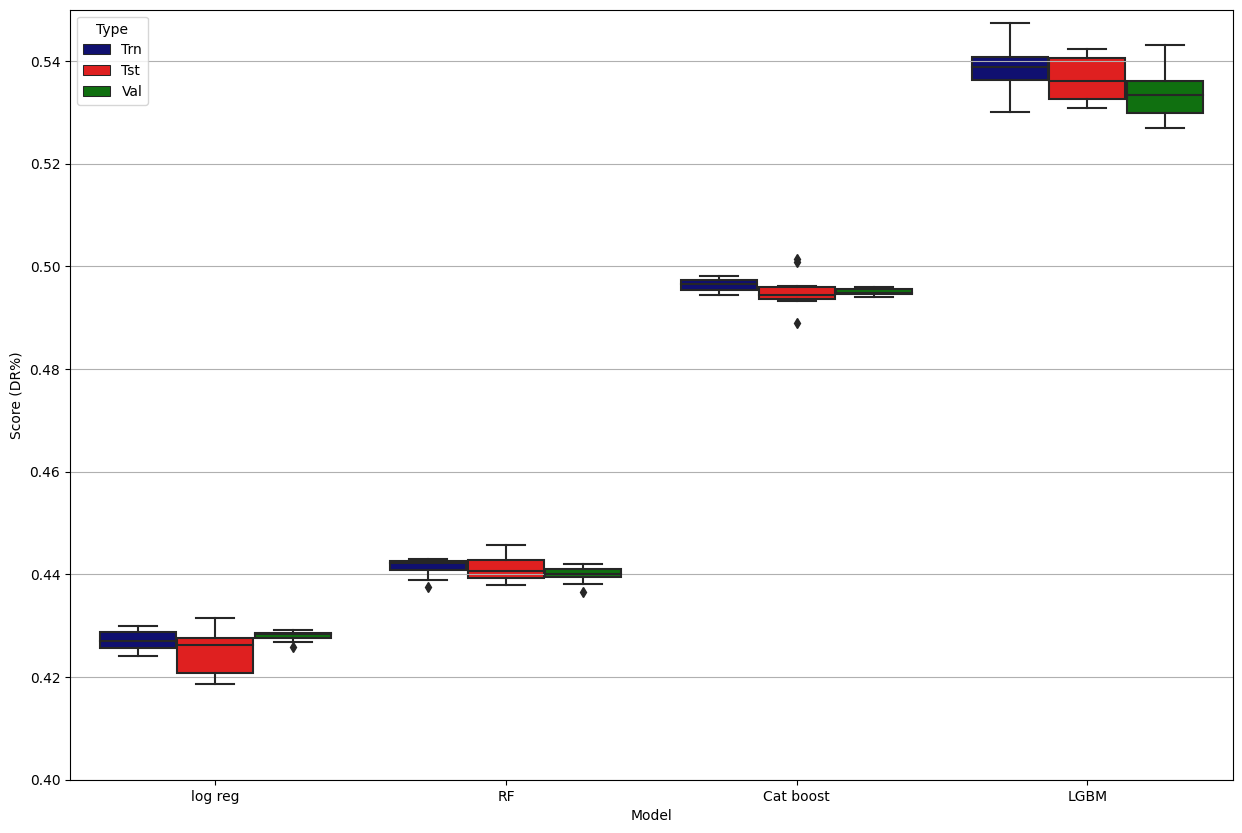

In [169]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(.4,.55)
plt.ylabel('Score (DR%)')
plt.grid(axis='y')
plt.savefig('modeling.pdf')
plt.show()

In [170]:
Val_only = df.drop(columns=['Trn','Tst'])

In [171]:
Val_only.head()

,Model,Val
0,log reg,0.42595
1,log reg,0.428329
2,log reg,0.429178
3,log reg,0.428499
4,log reg,0.428669


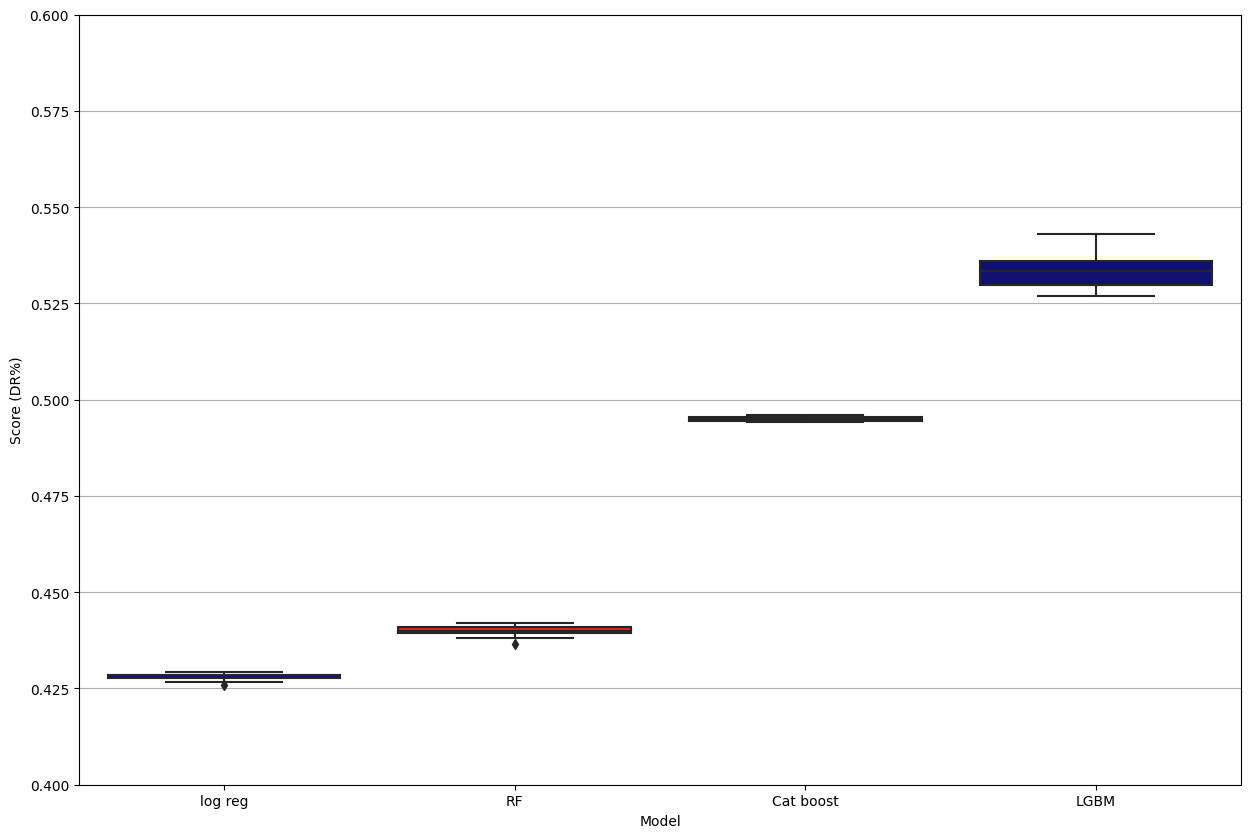

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='Model',y='Val',data=Val_only, palette=['navy','r','g'])

plt.ylim(.4,.6)
plt.ylabel('Score (DR%)')
plt.grid(axis='y')
plt.show()

### Let's run a random forest to see the most predictive variables.

In [173]:
%%time
model = RandomForestClassifier(n_estimators=30,max_depth=7,min_samples_split=50,min_samples_leaf=20,max_features=n_vars_keep)
model.fit(X_model, Y_model)

CPU times: user 15.3 s, sys: 162 ms, total: 15.5 s
Wall time: 15.2 s


RandomForestClassifier(max_depth=7, max_features=10, min_samples_leaf=20,
                       min_samples_split=50, n_estimators=30)

In [174]:
n_vars_keep

10

In [175]:
vars_keep_list.remove('target')
vars_keep_list.remove('id')
vars_keep_list

['investor_funds/last_pymnt_amnt',
 'interest_payments_Low',
 'inq_last_6mths/total_rev_hi_lim',
 'installment/last_pymnt_amnt',
 'grade+application_type_TE',
 'revol_util/last_pymnt_amnt',
 'annual_income/last_pymnt_amnt',
 'last_pymnt_amnt',
 'open_acc/last_pymnt_amnt',
 'total_acc/last_pymnt_amnt']

In [176]:
def feature_importance_plot(model,title):
    feature_importance = pd.DataFrame({'Importance':model.feature_importances_*100},index = vars_keep_list)\
                    .sort_values(by='Importance')
    feature_importance[-15:].plot(kind='barh')
    plt.title(title);
    plt.savefig('feature_importance.pdf')

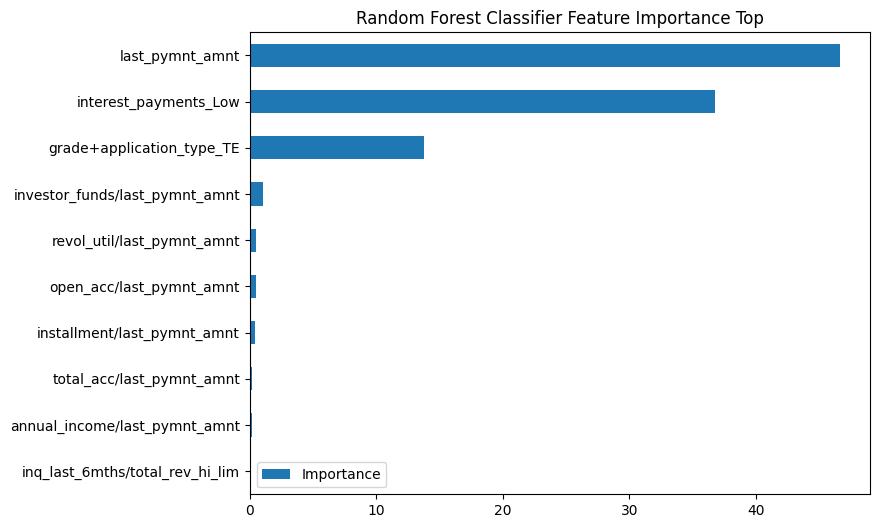

In [177]:
feature_importance_plot(model,'Random Forest Classifier Feature Importance Top')

The most important few variables all seem to make sense so everything looks fine.

OK, now we've explored lots of model types and hyperparameters, and we've seleced our favorite model and settings. We now need to run this model one more time with these settings "frozen" and get the best model that we can. That will be our final result.

In [178]:
detect_rate

0.2

In [179]:
%%time
# Note - need to set this next value to around the highest val DR for your model of choice.
# The model then runs a number of times with your fixed hyperparameters until it finds a good model.

# Here I tell it to stop when I get above 99% of the previous best run.

desire = .49
print('desired is:', desire)

for niter in range(10):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_model, Y_model, test_size = .3)

# here's where you put your final model of choice
# I run this loop a large number of times with an unreasonably high stopping criterion (the break condition)
# I then look at all these runs and select a value of the val performance where I want to break out this loop
# and that will be my final model run of choice
    model = CatBoostClassifier(verbose=0, iterations=50, learning_rate=.1, l2_leaf_reg=10)
#     model = RandomForestClassifier(n_estimators=30,max_depth=7,min_samples_split=50,min_samples_leaf=20,max_features=5)

    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()
    X_val = X_val_save.copy()
    num_X_tst = len(X_tst)
    num_X_trn = len(X_trn)

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['target'] = Y_trn_save['target']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=True).head(topRows)
    needed = temp.loc[:,'target']
    DR.loc[niter, 'trn'] = (topRows - sum(needed))/(num_X_trn - sum(X_trn.loc[:,'target']))

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['target'] = Y_tst['target']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=True).head(topRows)
    needed = temp.loc[:,'target']
    DR.loc[niter, 'tst'] = (topRows - sum(needed))/(num_X_tst - sum(X_tst.loc[:,'target']))

    predictions = model.predict_proba(X_val)[:,1]
    X_val['predicted']=predictions
    X_val['target'] = Y_val['target']
    topRows = int(round(X_val.shape[0]*detect_rate))
    temp = X_val.sort_values('predicted',ascending=True).head(topRows)
    needed = temp.loc[:,'target']
    DR.loc[niter, 'val'] = (topRows - sum(needed))/(num_X_val - sum(X_val.loc[:,'target']))
    
    print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])

# choose a good break point
    if(DR.loc[niter, 'val'] > desire): break
    
model_counter = model_counter + 1

desired is: 0.49
0 0.49650609115082556 0.49594894959489494 0.4957090661908403
CPU times: user 3.88 s, sys: 221 ms, total: 4.1 s
Wall time: 942 ms


In [180]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_val_eval = X_val.copy()

In [181]:
nbins = 40
cols = ['bin','score_avg','#recs','#B','#G','%B','%G','cum_tot','cum %pop','cB','cG','%cB (DR)','%cG','KS','FP_ratio']
DR_trn = pd.DataFrame(np.zeros((nbins, 15)), columns = cols)
DR_tst = pd.DataFrame(np.zeros((nbins, 15)), columns = cols)
DR_val = pd.DataFrame(np.zeros((nbins, 15)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
val_sorted = X_val_eval.sort_values('predicted',ascending=False)
GOOD_tot_trn = sum(X_trn_eval.loc[:, 'target'])
GOOD_tot_tst = sum(X_tst_eval.loc[:, 'target'])
GOOD_tot_val = sum(X_val_eval.loc[:, 'target'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_val = len(X_val_eval)
BAD_tot_trn = num_tot_trn - GOOD_tot_trn
BAD_tot_tst = num_tot_tst - GOOD_tot_tst
BAD_tot_val = num_tot_val - GOOD_tot_val

In [182]:
# set first bin
num_all = len(val_sorted)
num_all_good = val_sorted['target'].sum()
num_all_bad = num_all - num_all_good
row_increment = int(len(val_sorted) / nbins)
in_bin = val_sorted.head(row_increment)
DR_trn.loc[0,'bin'] = 1
DR_trn.loc[0,'score_avg'] = in_bin['predicted'].mean()
DR_trn.loc[0,'#recs'] = row_increment
DR_trn.loc[0,'#G'] = in_bin['target'].sum()
DR_trn.loc[0,'#B'] = row_increment - DR_trn.loc[0,'#G']
DR_trn.loc[0,'%G'] = 100 * DR_trn.loc[0,'#G'] / row_increment
DR_trn.loc[0,'%B'] = 100 * DR_trn.loc[0,'#B'] / row_increment
DR_trn.loc[0,'cum_tot'] = row_increment
DR_trn.loc[0,'cum %pop'] = 100/nbins
DR_trn.loc[0,'cB'] = DR_trn.loc[0,'#B']
DR_trn.loc[0,'cG'] = DR_trn.loc[0,'#G']
DR_trn.loc[0,'%cB (DR)'] = 100 * DR_trn.loc[0,'cB'] / num_all_bad
DR_trn.loc[0,'%cG'] = 100 * DR_trn.loc[0,'cG'] / num_all_good
    
# do bins
for i in range(1,nbins,1):
#     j = nbins - i
    in_bin = val_sorted[row_increment * (i):row_increment * (i+1)]
    num_bin = len(in_bin)
    DR_trn.loc[i,'bin'] = i + 1
    DR_trn.loc[i,'score_avg'] = in_bin['predicted'].mean()
    DR_trn.loc[i,'#recs'] = num_bin
    DR_trn.loc[i,'#G'] = in_bin['target'].sum()
    DR_trn.loc[i,'#B'] = num_bin - DR_trn.loc[i,'#G']
    DR_trn.loc[i,'%G'] = 100 * DR_trn.loc[i,'#G'] / num_bin
    DR_trn.loc[i,'%B'] = 100 * DR_trn.loc[i,'#B'] / num_bin
    DR_trn.loc[i,'cum_tot'] = DR_trn.loc[i-1,'cum_tot'] + num_bin
    DR_trn.loc[i,'cum %pop'] = 100*(i+1)/nbins
    DR_trn.loc[i,'cB'] = DR_trn.loc[i-1,'cB'] + DR_trn.loc[i,'#B']
    DR_trn.loc[i,'cG'] = DR_trn.loc[i-1,'cG'] + DR_trn.loc[i,'#G']
    DR_trn.loc[i,'%cB (DR)'] = 100 * DR_trn.loc[i,'cB'] / num_all_bad
    DR_trn.loc[i,'%cG'] = 100 * DR_trn.loc[i,'cG'] / num_all_good
    DR_trn.loc[i,'KS'] = DR_trn.loc[i,'%cG'] - DR_trn.loc[i,'%cB (DR)']
    DR_trn.loc[i,'FP_ratio'] = DR_trn.loc[i,'cB'] / DR_trn.loc[i,'cG']
    
# do the final, putting in any left-over records
in_bin = val_sorted[row_increment * (nbins-1):]
num_bin = len(in_bin)
DR_trn.loc[i,'bin'] = nbins
DR_trn.loc[i,'score_avg'] = in_bin['predicted'].mean()
DR_trn.loc[i,'#recs'] = num_bin
DR_trn.loc[i,'#G'] = in_bin['target'].sum()
DR_trn.loc[i,'#B'] = num_bin - DR_trn.loc[i,'#G']
DR_trn.loc[i,'%G'] = 100 * DR_trn.loc[i,'#G'] / num_bin
DR_trn.loc[i,'%B'] = 100 * DR_trn.loc[i,'#B'] / num_bin
DR_trn.loc[i,'cum_tot'] = DR_trn.loc[i-1,'cum_tot'] + num_bin
DR_trn.loc[i,'cum %pop'] = 100
DR_trn.loc[i,'cB'] = DR_trn.loc[i-1,'cB'] + DR_trn.loc[i,'#B']
DR_trn.loc[i,'cG'] = DR_trn.loc[i-1,'cG'] + DR_trn.loc[i,'#G']
DR_trn.loc[i,'%cB (DR)'] = 100 * DR_trn.loc[i,'cB'] / num_all_bad
DR_trn.loc[i,'%cG'] = 100 * DR_trn.loc[i,'cG'] / num_all_good
DR_trn.loc[i,'KS'] = DR_trn.loc[i,'%cG'] - DR_trn.loc[i,'%cB (DR)']
DR_trn.loc[i,'FP_ratio'] = DR_trn.loc[i,'cB'] / DR_trn.loc[i,'cG']

In [183]:
# set first bin
num_all = len(val_sorted)
num_all_good = val_sorted['target'].sum()
num_all_bad = num_all - num_all_good
row_increment = int(len(val_sorted) / nbins)
in_bin = val_sorted.head(row_increment)
DR_tst.loc[0,'bin'] = 1
DR_tst.loc[0,'score_avg'] = in_bin['predicted'].mean()
DR_tst.loc[0,'#recs'] = row_increment
DR_tst.loc[0,'#G'] = in_bin['target'].sum()
DR_tst.loc[0,'#B'] = row_increment - DR_tst.loc[0,'#G']
DR_tst.loc[0,'%G'] = 100 * DR_tst.loc[0,'#G'] / row_increment
DR_tst.loc[0,'%B'] = 100 * DR_tst.loc[0,'#B'] / row_increment
DR_tst.loc[0,'cum_tot'] = row_increment
DR_tst.loc[0,'cum %pop'] = 100/nbins
DR_tst.loc[0,'cB'] = DR_tst.loc[0,'#B']
DR_tst.loc[0,'cG'] = DR_tst.loc[0,'#G']
DR_tst.loc[0,'%cB (DR)'] = 100 * DR_tst.loc[0,'cB'] / num_all_bad
DR_tst.loc[0,'%cG'] = 100 * DR_tst.loc[0,'cG'] / num_all_good
    
# do bins
for i in range(1,nbins,1):
#     j = nbins - i
    in_bin = val_sorted[row_increment * (i):row_increment * (i+1)]
    num_bin = len(in_bin)
    DR_tst.loc[i,'bin'] = i + 1
    DR_tst.loc[i,'score_avg'] = in_bin['predicted'].mean()
    DR_tst.loc[i,'#recs'] = num_bin
    DR_tst.loc[i,'#G'] = in_bin['target'].sum()
    DR_tst.loc[i,'#B'] = num_bin - DR_tst.loc[i,'#G']
    DR_tst.loc[i,'%G'] = 100 * DR_tst.loc[i,'#G'] / num_bin
    DR_tst.loc[i,'%B'] = 100 * DR_tst.loc[i,'#B'] / num_bin
    DR_tst.loc[i,'cum_tot'] = DR_tst.loc[i-1,'cum_tot'] + num_bin
    DR_tst.loc[i,'cum %pop'] = 100*(i+1)/nbins
    DR_tst.loc[i,'cB'] = DR_tst.loc[i-1,'cB'] + DR_tst.loc[i,'#B']
    DR_tst.loc[i,'cG'] = DR_tst.loc[i-1,'cG'] + DR_tst.loc[i,'#G']
    DR_tst.loc[i,'%cB (DR)'] = 100 * DR_tst.loc[i,'cB'] / num_all_bad
    DR_tst.loc[i,'%cG'] = 100 * DR_tst.loc[i,'cG'] / num_all_good
    DR_tst.loc[i,'KS'] = DR_tst.loc[i,'%cG'] - DR_tst.loc[i,'%cB (DR)']
    DR_tst.loc[i,'FP_ratio'] = DR_tst.loc[i,'cB'] / DR_tst.loc[i,'cG']
    
# do the final, putting in any left-over records
in_bin = val_sorted[row_increment * (nbins-1):]
num_bin = len(in_bin)
DR_tst.loc[i,'bin'] = nbins
DR_tst.loc[i,'score_avg'] = in_bin['predicted'].mean()
DR_tst.loc[i,'#recs'] = num_bin
DR_tst.loc[i,'#G'] = in_bin['target'].sum()
DR_tst.loc[i,'#B'] = num_bin - DR_tst.loc[i,'#G']
DR_tst.loc[i,'%G'] = 100 * DR_tst.loc[i,'#G'] / num_bin
DR_tst.loc[i,'%B'] = 100 * DR_tst.loc[i,'#B'] / num_bin
DR_tst.loc[i,'cum_tot'] = DR_tst.loc[i-1,'cum_tot'] + num_bin
DR_tst.loc[i,'cum %pop'] = 100
DR_tst.loc[i,'cB'] = DR_tst.loc[i-1,'cB'] + DR_tst.loc[i,'#B']
DR_tst.loc[i,'cG'] = DR_tst.loc[i-1,'cG'] + DR_tst.loc[i,'#G']
DR_tst.loc[i,'%cB (DR)'] = 100 * DR_tst.loc[i,'cB'] / num_all_bad
DR_tst.loc[i,'%cG'] = 100 * DR_tst.loc[i,'cG'] / num_all_good
DR_tst.loc[i,'KS'] = DR_tst.loc[i,'%cG'] - DR_tst.loc[i,'%cB (DR)']
DR_tst.loc[i,'FP_ratio'] = DR_tst.loc[i,'cB'] / DR_tst.loc[i,'cG']

In [184]:
# set first bin
num_all = len(val_sorted)
num_all_good = val_sorted['target'].sum()
num_all_bad = num_all - num_all_good
row_increment = int(len(val_sorted) / nbins)
in_bin = val_sorted.head(row_increment)
DR_val.loc[0,'bin'] = 1
DR_val.loc[0,'score_avg'] = in_bin['predicted'].mean()
DR_val.loc[0,'#recs'] = row_increment
DR_val.loc[0,'#G'] = in_bin['target'].sum()
DR_val.loc[0,'#B'] = row_increment - DR_val.loc[0,'#G']
DR_val.loc[0,'%G'] = 100 * DR_val.loc[0,'#G'] / row_increment
DR_val.loc[0,'%B'] = 100 * DR_val.loc[0,'#B'] / row_increment
DR_val.loc[0,'cum_tot'] = row_increment
DR_val.loc[0,'cum %pop'] = 100/nbins
DR_val.loc[0,'cB'] = DR_val.loc[0,'#B']
DR_val.loc[0,'cG'] = DR_val.loc[0,'#G']
DR_val.loc[0,'%cB (DR)'] = 100 * DR_val.loc[0,'cB'] / num_all_bad
DR_val.loc[0,'%cG'] = 100 * DR_val.loc[0,'cG'] / num_all_good
    
# do bins
for i in range(1,nbins,1):
#     j = nbins - i
    in_bin = val_sorted[row_increment * (i):row_increment * (i+1)]
    num_bin = len(in_bin)
    DR_val.loc[i,'bin'] = i + 1
    DR_val.loc[i,'score_avg'] = in_bin['predicted'].mean()
    DR_val.loc[i,'#recs'] = num_bin
    DR_val.loc[i,'#G'] = in_bin['target'].sum()
    DR_val.loc[i,'#B'] = num_bin - DR_val.loc[i,'#G']
    DR_val.loc[i,'%G'] = 100 * DR_val.loc[i,'#G'] / num_bin
    DR_val.loc[i,'%B'] = 100 * DR_val.loc[i,'#B'] / num_bin
    DR_val.loc[i,'cum_tot'] = DR_val.loc[i-1,'cum_tot'] + num_bin
    DR_val.loc[i,'cum %pop'] = 100*(i+1)/nbins
    DR_val.loc[i,'cB'] = DR_val.loc[i-1,'cB'] + DR_val.loc[i,'#B']
    DR_val.loc[i,'cG'] = DR_val.loc[i-1,'cG'] + DR_val.loc[i,'#G']
    DR_val.loc[i,'%cB (DR)'] = 100 * DR_val.loc[i,'cB'] / num_all_bad
    DR_val.loc[i,'%cG'] = 100 * DR_val.loc[i,'cG'] / num_all_good
    DR_val.loc[i,'KS'] = DR_val.loc[i,'%cG'] - DR_val.loc[i,'%cB (DR)']
    DR_val.loc[i,'FP_ratio'] = DR_val.loc[i,'cB'] / DR_val.loc[i,'cG']
    
# do the final, putting in any left-over records
in_bin = val_sorted[row_increment * (nbins-1):]
num_bin = len(in_bin)
DR_val.loc[i,'bin'] = nbins
DR_val.loc[i,'score_avg'] = in_bin['predicted'].mean()
DR_val.loc[i,'#recs'] = num_bin
DR_val.loc[i,'#G'] = in_bin['target'].sum()
DR_val.loc[i,'#B'] = num_bin - DR_val.loc[i,'#G']
DR_val.loc[i,'%G'] = 100 * DR_val.loc[i,'#G'] / num_bin
DR_val.loc[i,'%B'] = 100 * DR_val.loc[i,'#B'] / num_bin
DR_val.loc[i,'cum_tot'] = DR_val.loc[i-1,'cum_tot'] + num_bin
DR_val.loc[i,'cum %pop'] = 100
DR_val.loc[i,'cB'] = DR_val.loc[i-1,'cB'] + DR_val.loc[i,'#B']
DR_val.loc[i,'cG'] = DR_val.loc[i-1,'cG'] + DR_val.loc[i,'#G']
DR_val.loc[i,'%cB (DR)'] = 100 * DR_val.loc[i,'cB'] / num_all_bad
DR_val.loc[i,'%cG'] = 100 * DR_val.loc[i,'cG'] / num_all_good
DR_val.loc[i,'KS'] = DR_val.loc[i,'%cG'] - DR_val.loc[i,'%cB (DR)']
DR_val.loc[i,'FP_ratio'] = DR_val.loc[i,'cB'] / DR_val.loc[i,'cG']

In [185]:
DR_val

,bin,score_avg,#recs,#B,#G,%B,%G,cum_tot,cum %pop,cB,cG,%cB (DR),%cG,KS,FP_ratio
0,1.0,0.992753,4380.0,0.0,4380.0,0.000000,100.000000,4380.0,2.5,0.0,4380.0,0.000000,2.679965,0.000000,0.000000
1,2.0,0.992320,4380.0,1.0,4379.0,0.022831,99.977169,8760.0,5.0,1.0,8759.0,0.008497,5.359317,5.350820,0.000114
2,3.0,0.991599,4380.0,1.0,4379.0,0.022831,99.977169,13140.0,7.5,2.0,13138.0,0.016994,8.038670,8.021676,0.000152
3,4.0,0.991134,4380.0,2.0,4378.0,0.045662,99.954338,17520.0,10.0,4.0,17516.0,0.033988,10.717411,10.683423,0.000228
4,5.0,0.990449,4380.0,5.0,4375.0,0.114155,99.885845,21900.0,12.5,9.0,21891.0,0.076472,13.394316,13.317844,0.000411
5,6.0,0.989487,4380.0,8.0,4372.0,0.182648,99.817352,26280.0,15.0,17.0,26263.0,0.144447,16.069385,15.924938,0.000647
6,7.0,0.987293,4380.0,24.0,4356.0,0.547945,99.452055,30660.0,17.5,41.0,30619.0,0.348373,18.734665,18.386292,0.001339
7,8.0,0.977625,4380.0,58.0,4322.0,1.324201,98.675799,35040.0,20.0,99.0,34941.0,0.841193,21.379142,20.537949,0.002833
8,9.0,0.971786,4380.0,66.0,4314.0,1.506849,98.493151,39420.0,22.5,165.0,39255.0,1.401988,24.018723,22.616735,0.004203
9,10.0,0.970372,4380.0,66.0,4314.0,1.506849,98.493151,43800.0,25.0,231.0,43569.0,1.962784,26.658305,24.695521,0.005302


In [186]:
DR_val['#B'].sum()

11769.0

Max possible savings: 42,501,500.0


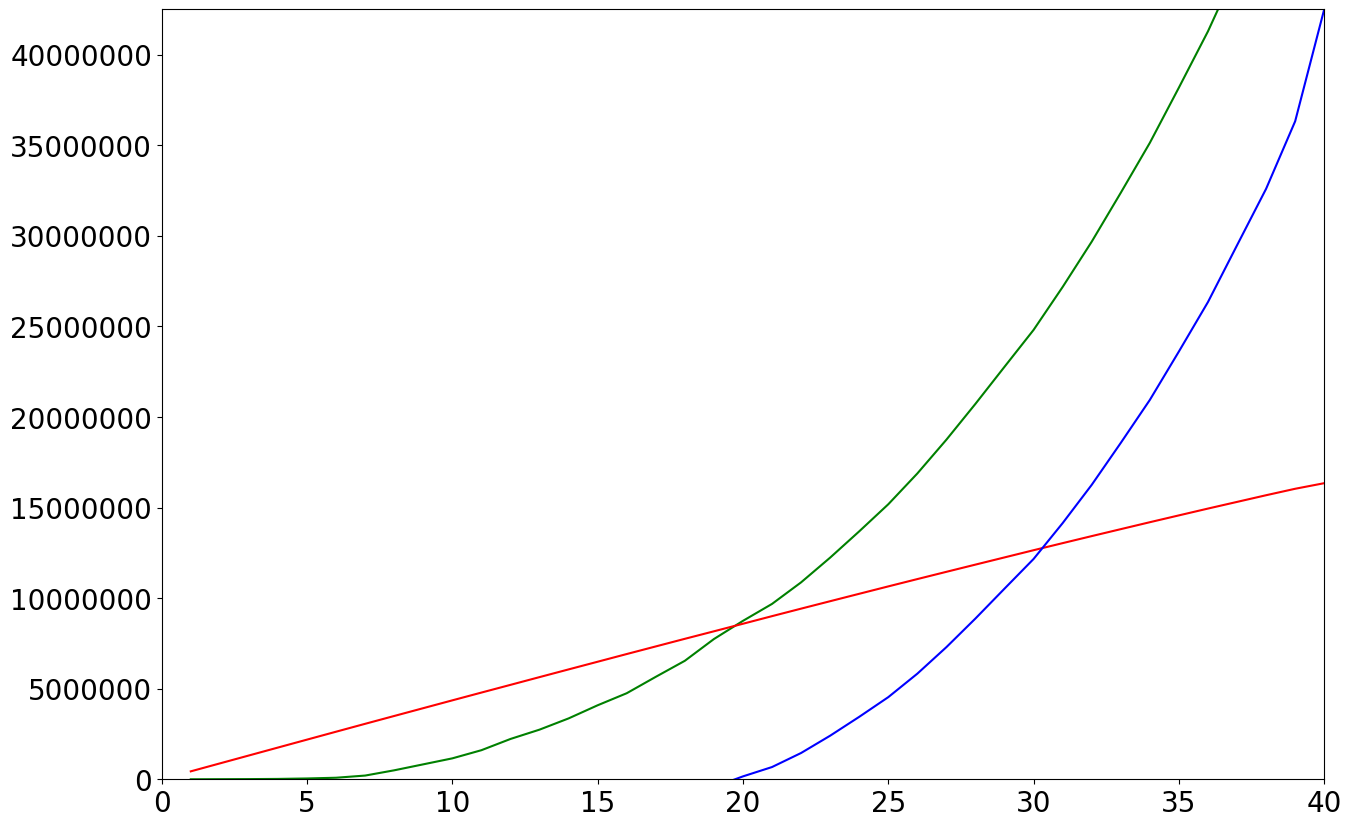

In [187]:
cost_Bad = 5000
cost_fp = 100
xval = 1
Financials_trn = pd.DataFrame(np.zeros((nbins, 4)), columns = ['bin','Bad Savings','FP Loss','Overall Savings'])
Financials_tst = pd.DataFrame(np.zeros((nbins, 4)), columns = ['bin','Bad Savings','FP Loss','Overall Savings'])
Financials_val = pd.DataFrame(np.zeros((nbins, 4)), columns = ['bin','Bad Savings','FP Loss','Overall Savings'])
for i in range(nbins):
    Financials_trn.loc[i, 'bin'] = i+1
    Financials_trn.loc[i, 'Bad Savings'] = DR_trn.loc[i, 'cB'] * cost_Bad * xval
    Financials_trn.loc[i, 'FP Loss'] = DR_trn.loc[i, 'cG'] * cost_fp * xval
    Financials_trn.loc[i, 'Overall Savings'] = Financials_trn.loc[i, 'Bad Savings'] - Financials_trn.loc[i, 'FP Loss']
    Financials_tst.loc[i, 'bin'] = i+1
    Financials_tst.loc[i, 'Bad Savings'] = DR_tst.loc[i, 'cB'] * cost_Bad * xval
    Financials_tst.loc[i, 'FP Loss'] = DR_tst.loc[i, 'cG'] * cost_fp * xval
    Financials_tst.loc[i, 'Overall Savings'] = Financials_tst.loc[i, 'Bad Savings'] - Financials_tst.loc[i, 'FP Loss']
    Financials_val.loc[i, 'bin'] = i+1
    Financials_val.loc[i, 'Bad Savings'] = DR_val.loc[i, 'cB'] * cost_Bad * xval
    Financials_val.loc[i, 'FP Loss'] = DR_val.loc[i, 'cG'] * cost_fp * xval
    Financials_val.loc[i, 'Overall Savings'] = Financials_val.loc[i, 'Bad Savings'] - Financials_val.loc[i, 'FP Loss']

max_savings = Financials_val['Overall Savings'].max(0)
print('Max possible savings: '+'{:,}'.format(max_savings))
yupper = max_savings
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(15,10))
plt.plot(Financials_val['bin'],Financials_val['Bad Savings'], color='green')
plt.plot(Financials_val['bin'],Financials_val['FP Loss'], color='red')
plt.plot(Financials_val['bin'],Financials_val['Overall Savings'], color='blue')
xlimit = 40
interval = 5
plt.xlim(0,xlimit)
plt.ylim(0,yupper)
plt.xticks(ticks=np.linspace(0,xlimit, num=int(xlimit/interval)+1))
plt.ticklabel_format(style='plain')
plt.savefig('savings.png', format='png')

In [188]:
Financials_val.head()

,bin,Bad Savings,FP Loss,Overall Savings
0,1.0,0.0,438000.0,-438000.0
1,2.0,5000.0,875900.0,-870900.0
2,3.0,10000.0,1313800.0,-1303800.0
3,4.0,20000.0,1751600.0,-1731600.0
4,5.0,45000.0,2189100.0,-2144100.0


In [189]:
Metrics = DR_val.copy()
num_Good = Metrics['#G'].sum()
num_Bad = Metrics['#B'].sum()
num_tot = Metrics['#recs'].sum()
print(num_Good,num_Bad,num_Good+num_Bad,num_tot)

163435.0 11769.0 175204.0 175204.0


In [190]:
Metrics['TP'] = num_Good - Metrics['cG']
Metrics['TN'] = Metrics['cB']
Metrics['FN'] = num_Bad - Metrics['cB']
Metrics['FP'] = Metrics['cG']
Metrics['Accuracy'] = (Metrics['TP'] + Metrics['TN']) / num_tot
Metrics['Misclass'] = (Metrics['FP'] + Metrics['FN']) / num_tot
Metrics['FPRate'] = Metrics['FP'] / (Metrics['FP'] + Metrics['TN'])
Metrics['FPRatio'] = Metrics['FP'] / Metrics['TP']
Metrics['TPR'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FN'])
Metrics['TNR'] = Metrics['TN'] / (Metrics['TN'] + Metrics['FP'])
Metrics['Precision'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FP'])
Metrics['f1'] = 2 * Metrics['Precision'] * Metrics['TPR'] / (Metrics['Precision'] + Metrics['TPR'])
Metrics.to_csv('Metrics.csv')

Text(0, 0.5, 'DR')

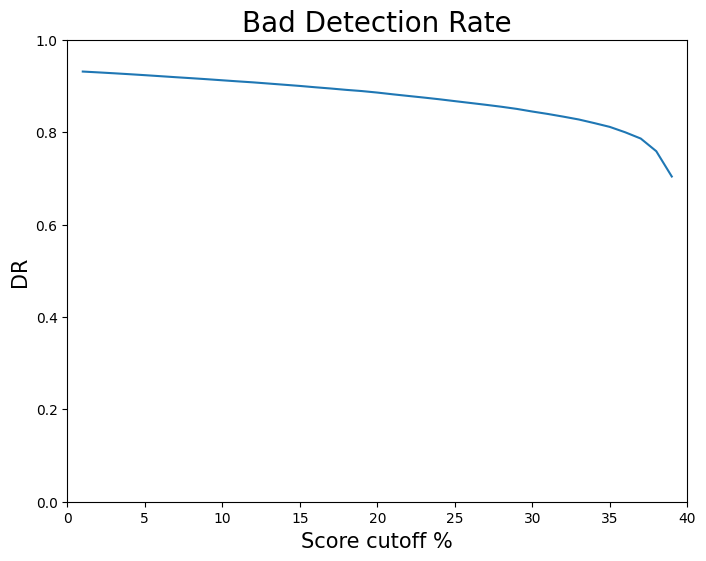

In [191]:
plt.rcParams.update({'font.size':10})
plt.plot(Metrics['bin'], Metrics['TPR'])
plt.title('Bad Detection Rate', fontsize=20)
plt.xlim(0,nbins)
plt.ylim(0,1)
plt.xlabel('Score cutoff %', fontsize=15)
plt.ylabel('DR', fontsize=15)

# Score Calibration

In [192]:
base = 700
odds_at_base = 20
delta = 30

In [193]:
df = pd.concat([X_trn_eval,X_tst_eval,X_val_eval])
df.shape

(876020, 12)

In [194]:
df.head()

,investor_funds/last_pymnt_amnt,interest_payments_Low,inq_last_6mths/total_rev_hi_lim,installment/last_pymnt_amnt,grade+application_type_TE,revol_util/last_pymnt_amnt,annual_income/last_pymnt_amnt,last_pymnt_amnt,open_acc/last_pymnt_amnt,total_acc/last_pymnt_amnt,predicted,target
552479,-0.122419,-1.055318,-0.007649,-0.122967,-0.954614,-0.128681,-0.101072,-0.352702,-0.127977,-0.128025,0.899880,1
739969,-0.122419,0.947580,-0.007649,-0.122967,1.267607,-0.128681,-0.101072,-0.432198,-0.127977,-0.128025,0.969926,1
448176,-0.122419,0.947580,-0.007649,-0.122967,0.560320,-0.128681,-0.101072,-0.328260,-0.127977,-0.128025,0.944251,1
368164,-0.122419,-1.055318,-0.007649,-0.122967,-0.954614,-0.128681,-0.101072,-0.267379,-0.127977,-0.128025,0.894116,1
658239,-0.122419,-1.055318,-0.007649,-0.122967,-0.031003,-0.128681,-0.101072,0.780214,-0.127977,-0.128025,0.990468,1


In [195]:
calib = df.iloc[:,df.shape[1]-2:]
trn_sorted = X_trn_eval.sort_values('predicted',ascending=True)
calib = calib.sort_values('predicted')
calib.rename(columns={'predicted':'score_raw'}, inplace=True)
calib['score_raw'].clip(upper=.999, inplace=True)
calib['score_raw'].clip(lower=.00001, inplace=True)
calib.head()

,score_raw,target
4328,0.333536,0
33336,0.336261,1
19397,0.341877,0
183899,0.343809,0
136250,0.344916,0


In [196]:
calib.shape

(876020, 2)

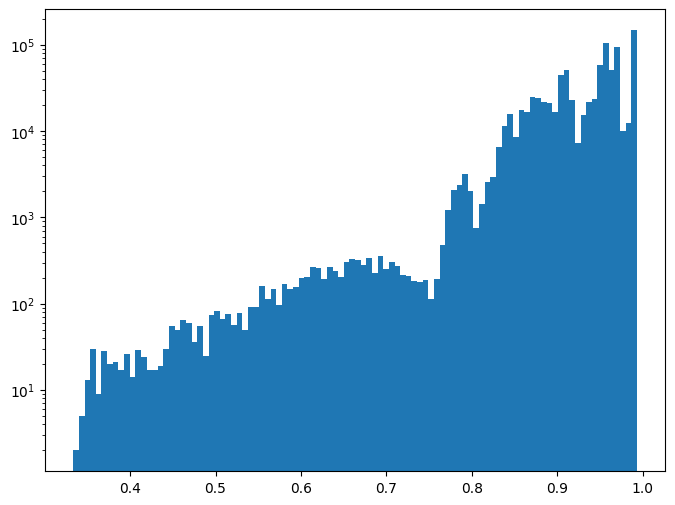

In [197]:
plt.hist(calib['score_raw'],bins=100)
plt.yscale('log')

In [198]:
# The reason we bin the records is to calculate the odds. We can then find the relationship between the raw score and the log odds.
nbins=100
cols = ['bin','#recs','#B','#G','%B','%G','tot','cB','cG','score_raw','prob(%)','odds','log_odds', 'log_odds_adj']
cal_bins = pd.DataFrame(np.zeros((nbins+1, 14)), columns = cols)

In [199]:
frac = 1/nbins
nrecs = calib.shape[0]
cal_bins.loc[0,'log_odds_adj'] = -8
for i in range(nbins+1):
    percent_rows_top = int(round(nrecs*frac*i))
    percent_rows_bottom = max(int(round(nrecs*frac*(i-1))),0)
    temp = calib.iloc[percent_rows_bottom:percent_rows_top,:]
    cal_bins.loc[i, 'score_raw'] = temp['score_raw'].mean()
    num_GOOD = int(sum(temp.loc[:,'target']))
    num_tot = len(temp) * i
    num_BAD = int(num_tot - num_GOOD)
    cal_bins.loc[i, 'bin'] = i
    cal_bins.loc[i,'#recs'] = 0
    cal_bins.loc[i, 'tot'] = num_tot
    cal_bins.loc[i, 'cB'] = num_BAD
    cal_bins.loc[i, 'cG'] = num_GOOD
    if i != 0:
        cal_bins.loc[i, '#recs'] = len(temp)
        cal_bins.loc[i, '#G'] = int(sum(temp.loc[:, 'target']))
        cal_bins.loc[i, '#B'] = cal_bins.loc[i, '#recs'] - cal_bins.loc[i, '#G']
        cal_bins.loc[i, '%B'] = 100* cal_bins.loc[i, '#B'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, '%G'] = 100 - cal_bins.loc[i, '%B']
        cal_bins.loc[i, 'cB'] = cal_bins.loc[i-1, 'cB'] + cal_bins.loc[i, '#B']
        cal_bins.loc[i, 'cG'] = cal_bins.loc[i-1, 'cG'] + cal_bins.loc[i, '#G']
        cal_bins.loc[i, 'prob(%)'] = 100 * cal_bins.loc[i, '#G'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, 'odds'] = (cal_bins.loc[i, '#G'] + .001) / cal_bins.loc[i, '#B']
        cal_bins.loc[i, 'log_odds'] = np.log2(cal_bins.loc[i, 'odds'])
        cal_bins.loc[i, 'log_odds_adj'] = max(cal_bins.loc[i, 'log_odds'], cal_bins.loc[i-1, 'log_odds_adj'])
        
cal_bins.drop(index=0,axis=0,inplace=True)
cal_bins.fillna(0)

,bin,#recs,#B,#G,%B,%G,tot,cB,cG,score_raw,prob(%),odds,log_odds,log_odds_adj
1,1.0,8760.0,3515.0,5245.0,40.125571,59.874429,8760.0,3515.0,5245.0,0.638426,59.874429,1.492177,0.577418,0.577418
2,2.0,8760.0,2138.0,6622.0,24.406393,75.593607,17520.0,5653.0,11867.0,0.783458,75.593607,3.097288,1.631005,1.631005
3,3.0,8761.0,1866.0,6895.0,21.298938,78.701062,26283.0,7519.0,18762.0,0.812160,78.701062,3.695070,1.885602,1.885602
4,4.0,8760.0,1684.0,7076.0,19.223744,80.776256,35040.0,9203.0,25838.0,0.832010,80.776256,4.201901,2.071042,2.071042
5,5.0,8760.0,1526.0,7234.0,17.420091,82.579909,43800.0,10729.0,33072.0,0.837854,82.579909,4.740499,2.245039,2.245039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,8760.0,4.0,8756.0,0.045662,99.954338,840960.0,58048.0,782931.0,0.992079,99.954338,2189.000250,11.096056,11.511259
97,97.0,8760.0,2.0,8758.0,0.022831,99.977169,849720.0,58050.0,791689.0,0.992445,99.977169,4379.000500,12.096386,12.096386
98,98.0,8761.0,4.0,8757.0,0.045657,99.954343,858578.0,58054.0,800446.0,0.992533,99.954343,2189.250250,11.096221,12.096386
99,99.0,8760.0,4.0,8756.0,0.045662,99.954338,867240.0,58058.0,809202.0,0.992587,99.954338,2189.000250,11.096056,12.096386


In [200]:
cal_bins.tail(20)

,bin,#recs,#B,#G,%B,%G,tot,cB,cG,score_raw,prob(%),odds,log_odds,log_odds_adj
81,81.0,8760.0,102.0,8658.0,1.164384,98.835616,709560.0,57663.0,651913.0,0.973360,98.835616,84.882363,6.407393,6.407393
82,82.0,8760.0,141.0,8619.0,1.609589,98.390411,718320.0,57804.0,660532.0,0.978529,98.390411,61.127667,5.933754,6.407393
83,83.0,8761.0,80.0,8681.0,0.913138,99.086862,727163.0,57884.0,669213.0,0.984279,99.086862,108.512512,6.761718,6.761718
84,84.0,8760.0,37.0,8723.0,0.422374,99.577626,735840.0,57921.0,677936.0,0.986996,99.577626,235.756784,7.881155,7.881155
85,85.0,8760.0,29.0,8731.0,0.331050,99.668950,744600.0,57950.0,686667.0,0.988292,99.668950,301.069000,8.233950,8.233950
86,86.0,8760.0,15.0,8745.0,0.171233,99.828767,753360.0,57965.0,695412.0,0.989111,99.828767,583.000067,9.187352,9.187352
87,87.0,8760.0,18.0,8742.0,0.205479,99.794521,762120.0,57983.0,704154.0,0.989534,99.794521,485.666722,8.923823,9.187352
88,88.0,8761.0,13.0,8748.0,0.148385,99.851615,770968.0,57996.0,712902.0,0.990198,99.851615,672.923154,9.394298,9.394298
89,89.0,8760.0,9.0,8751.0,0.102740,99.897260,779640.0,58005.0,721653.0,0.990438,99.897260,972.333444,9.925307,9.925307
90,90.0,8760.0,7.0,8753.0,0.079909,99.920091,788400.0,58012.0,730406.0,0.990481,99.920091,1250.428714,10.288207,10.288207


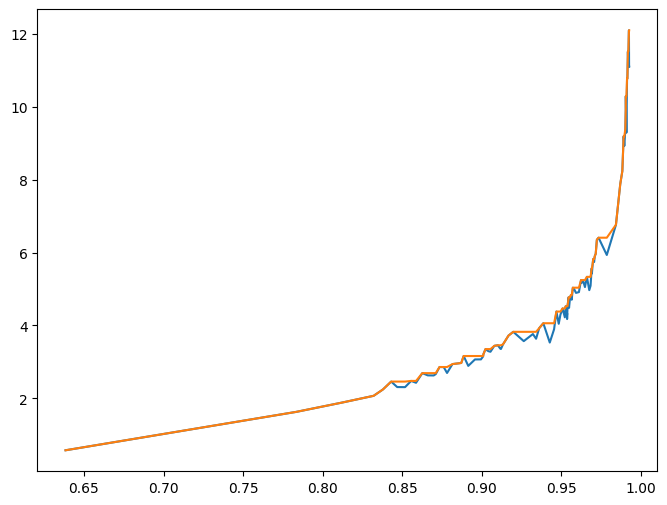

In [201]:
plt.plot(cal_bins['score_raw'],cal_bins['log_odds'])
plt.plot(cal_bins['score_raw'],cal_bins['log_odds_adj'])
# plt.xlim([0,1])

In [202]:
def funcg(x, a, b, c):
    return c + b/(1 + np.exp(-a * x))

def funcf(x, a, b, c):
    return -np.log(-1 + b/(x - c))/a

In [203]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(funcg, cal_bins['log_odds_adj'],cal_bins['score_raw'])   
print(popt)

[0.65810374 0.84592513 0.14512743]


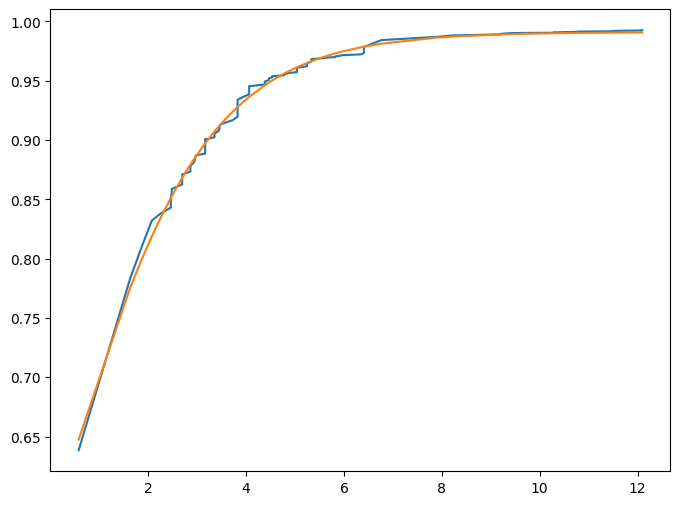

In [204]:
# plt.plot(cal_bins['log_odds'],cal_bins['score'])
plt.plot(cal_bins['log_odds_adj'],cal_bins['score_raw'])
plt.plot(cal_bins['log_odds_adj'],funcg(cal_bins['log_odds_adj'], *popt))

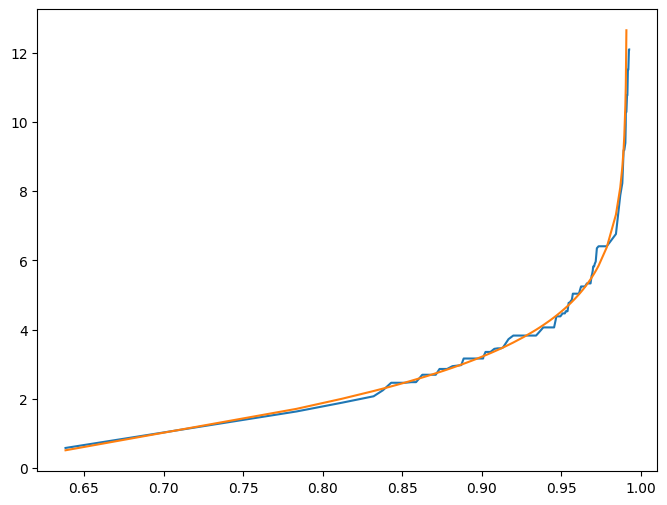

In [205]:
# look at the smooth curve fit to see if it's OK.
plt.plot(cal_bins['score_raw'], cal_bins['log_odds_adj'])
plt.plot(cal_bins['score_raw'], funcf(cal_bins['score_raw'], *popt))

In [206]:
# The fit looks pretty good
cal_bins['fit'] = funcf(cal_bins['score_raw'], *popt)
cal_bins.head(10)

,bin,#recs,#B,#G,%B,%G,tot,cB,cG,score_raw,prob(%),odds,log_odds,log_odds_adj,fit
1,1.0,8760.0,3515.0,5245.0,40.125571,59.874429,8760.0,3515.0,5245.0,0.638426,59.874429,1.492177,0.577418,0.577418,0.510107
2,2.0,8760.0,2138.0,6622.0,24.406393,75.593607,17520.0,5653.0,11867.0,0.783458,75.593607,3.097288,1.631005,1.631005,1.706830
3,3.0,8761.0,1866.0,6895.0,21.298938,78.701062,26283.0,7519.0,18762.0,0.812160,78.701062,3.695070,1.885602,1.885602,1.999767
4,4.0,8760.0,1684.0,7076.0,19.223744,80.776256,35040.0,9203.0,25838.0,0.832010,80.776256,4.201901,2.071042,2.071042,2.223043
5,5.0,8760.0,1526.0,7234.0,17.420091,82.579909,43800.0,10729.0,33072.0,0.837854,82.579909,4.740499,2.245039,2.245039,2.292803
6,6.0,8760.0,1346.0,7414.0,15.365297,84.634703,52560.0,12075.0,40486.0,0.843055,84.634703,5.508173,2.461574,2.461574,2.356644
7,7.0,8760.0,1469.0,7291.0,16.769406,83.230594,61320.0,13544.0,47777.0,0.846825,83.230594,4.963241,2.311283,2.461574,2.404041
8,8.0,8761.0,1471.0,7290.0,16.790321,83.209679,70088.0,15015.0,55067.0,0.851764,83.209679,4.955813,2.309122,2.461574,2.467648
9,9.0,8760.0,1332.0,7428.0,15.205479,84.794521,78840.0,16347.0,62495.0,0.855603,84.794521,5.576577,2.479380,2.479380,2.518348
10,10.0,8760.0,1372.0,7388.0,15.662100,84.337900,87600.0,17719.0,69883.0,0.858675,84.337900,5.384840,2.428904,2.479380,2.559759


In [207]:
# Here's the calibrated score
cal_bins['score_calib'] = base + delta * cal_bins['fit'] - delta * np.log2(odds_at_base)
cal_bins['score_calib'].fillna(850, inplace=True)
cal_bins['score_calib'].clip(upper=850, inplace=True)

In [208]:
pd.set_option('display.max_rows', 100)
cal_bins.to_csv('cal_bins.csv')
cal_bins.tail(60)

,bin,#recs,#B,#G,%B,%G,tot,cB,cG,score_raw,prob(%),odds,log_odds,log_odds_adj,fit,score_calib
41,41.0,8760.0,652.0,8108.0,7.442922,92.557078,359160.0,45057.0,314111.0,0.934101,92.557078,12.435584,3.636402,3.826163,3.994112,690.165513
42,42.0,8760.0,541.0,8219.0,6.175799,93.824201,367920.0,45598.0,322330.0,0.936037,93.824201,15.192238,3.925263,3.925263,4.050370,691.853245
43,43.0,8761.0,495.0,8266.0,5.650040,94.349960,376723.0,46093.0,330596.0,0.938641,94.349960,16.698992,4.061689,4.061689,4.129057,694.213867
44,44.0,8760.0,697.0,8063.0,7.956621,92.043379,385440.0,46790.0,338659.0,0.942697,92.043379,11.568151,3.532086,4.061689,4.259201,698.118192
45,45.0,8760.0,551.0,8209.0,6.289954,93.710046,394200.0,47341.0,346868.0,0.945414,93.710046,14.898368,3.897082,4.061689,4.352217,700.908666
46,46.0,8760.0,401.0,8359.0,4.577626,95.422374,402960.0,47742.0,355227.0,0.946876,95.422374,20.845389,4.381656,4.381656,4.404490,702.476854
47,47.0,8760.0,500.0,8260.0,5.707763,94.292237,411720.0,48242.0,363487.0,0.948330,94.292237,16.520002,4.046142,4.381656,4.458094,704.084984
48,48.0,8761.0,425.0,8336.0,4.851044,95.148956,420528.0,48667.0,371823.0,0.949382,95.148956,19.614120,4.293821,4.381656,4.497944,705.280480
49,49.0,8760.0,379.0,8381.0,4.326484,95.673516,429240.0,49046.0,380204.0,0.950741,95.673516,22.113459,4.466853,4.466853,4.550915,706.869600
50,50.0,8760.0,445.0,8315.0,5.079909,94.920091,438000.0,49491.0,388519.0,0.952170,94.920091,18.685396,4.223839,4.466853,4.608438,708.595302


In [209]:
calib.head()

,score_raw,target
4328,0.333536,0
33336,0.336261,1
19397,0.341877,0
183899,0.343809,0
136250,0.344916,0


In [210]:
# Now put the calibrated score on each record
calib['score_calib'] = base - delta * np.log2(odds_at_base) + delta * funcf(calib['score_raw'], *popt)
calib['score_calib'].fillna(850, inplace=True)
calib['score_calib'].clip(upper=850, inplace=True)
calib.head(20)

,score_raw,target,score_calib
4328,0.333536,0,513.366682
33336,0.336261,1,514.210700
19397,0.341877,0,515.923396
183899,0.343809,0,516.504662
136250,0.344916,0,516.835979
230422,0.345683,0,517.065015
12576,0.345683,0,517.065015
190668,0.347296,0,517.544060
187262,0.347472,0,517.596397
214262,0.347472,0,517.596397


In [211]:
calib.tail(20)

,score_raw,target,score_calib
151600,0.993043,1,850.0
456615,0.993043,1,850.0
178096,0.993043,1,850.0
55725,0.993043,1,850.0
7078,0.993043,1,850.0
156427,0.993043,1,850.0
363773,0.993043,1,850.0
257100,0.993043,1,850.0
790153,0.993043,1,850.0
816024,0.993043,1,850.0


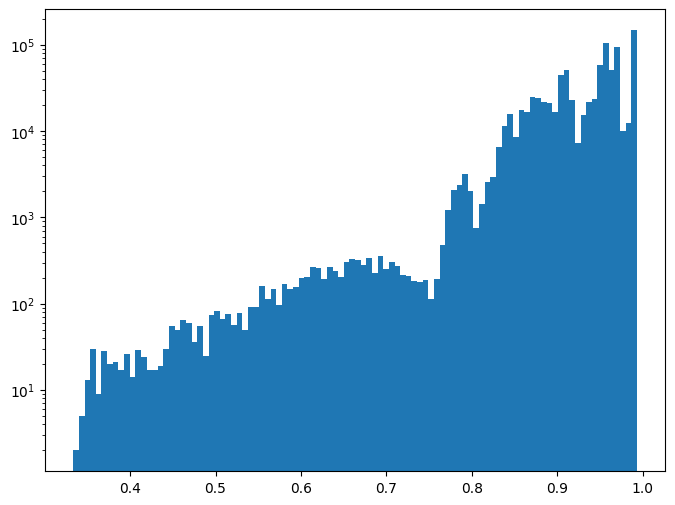

In [212]:
nbins=100
plt.hist(calib['score_raw'],bins=nbins)
plt.yscale('log')

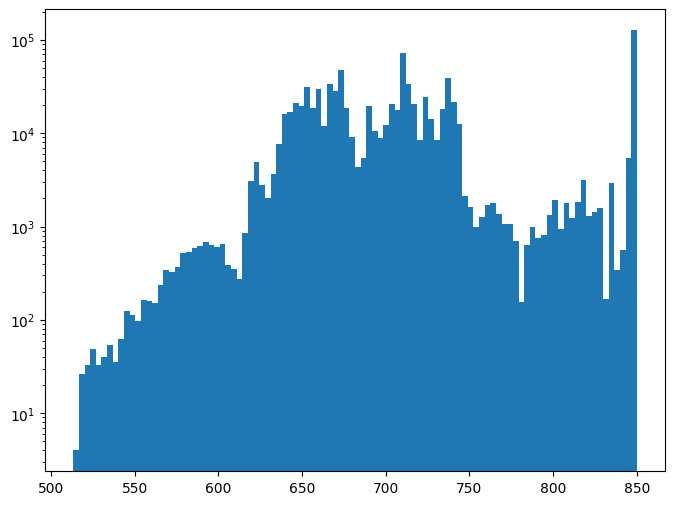

In [213]:
plt.hist(calib['score_calib'],bins=nbins)
plt.yscale('log')

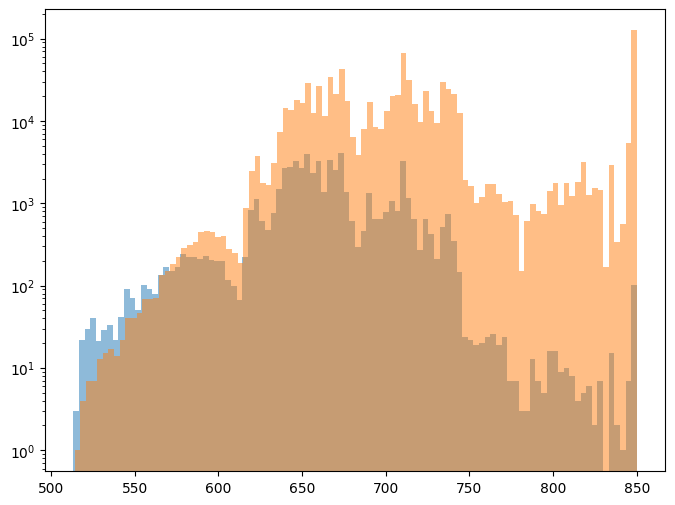

In [214]:
BADs = calib[calib['target']==0]
GOODs = calib[calib['target']==1]
plt.hist(BADs['score_calib'],bins = nbins, alpha = .5)
plt.hist(GOODs['score_calib'],bins = nbins, alpha = .5)
plt.yscale('log')

In [215]:
KS = sps.ks_2samp(GOODs['score_raw'],BADs['score_raw'])[0]
print(KS)

0.3922852618108169


In [216]:
KS = sps.ks_2samp(GOODs['score_calib'],BADs['score_calib'])[0]
print(KS)

0.3922852618108169


In [217]:
DR_trn['score_avg'] = base - delta * np.log2(odds_at_base) + delta * funcf(DR_trn['score_avg'], *popt)
DR_trn['score_avg'].clip(upper=850, inplace=True)

In [218]:
DR_tst['score_avg'] = base - delta * np.log2(odds_at_base) + delta * funcf(DR_tst['score_avg'], *popt)
DR_tst['score_avg'].clip(upper=850, inplace=True)

In [219]:
DR_val['score_avg'] = base - delta * np.log2(odds_at_base) + delta * funcf(DR_val['score_avg'], *popt)
DR_val['score_avg'].clip(upper=850, inplace=True)

In [220]:
DR_trn.to_excel('DR_trn.xlsx')
DR_tst.to_excel('DR_tst.xlsx')
DR_val.to_excel('DR_val.xlsx')

In [221]:
print('Duration: ', datetime.now() - start_time)

Duration:  0:11:17.877321


In [222]:
%pwd

'/Users/stevecoggeshall/Documents/Teaching/Data sets/done/Lending Club 2024'